**IMPORT LIBRARIES**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os  
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

**ULTIS**


In [2]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv(r'D:\thanh_v2\data_Thanh\japandata.csv',header=0)
    df.set_index('Time', inplace=True)
    df = df.fillna(method = 'ffill')
    
    return df

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
    num_columns = len(corr_matrix.columns) 
    for i in range(num_columns):
        if i != 0:
            if abs(corr_matrix.iloc[i,17 ]) < threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="D:/thanh_v2/saved_model/FFNN/checkpoint/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data


**MODEL**

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import torch.nn.functional as F
class FFNN(nn.Module):
    def __init__(self,seq_length,num_feature):
        super(FFNN,self).__init__()
        self.fc1 = nn.Linear(seq_length*num_feature,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,seq_length)
    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

**DATASET**

In [4]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24
    
    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

        

        return torch.tensor(features),torch.tensor(targets)

In [5]:
df = concat_csv()

target_column = 'Active power of purchased electricity at the receiving end'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

C:\Users\AVN\AppData\Local\Temp\ipykernel_17972\2193929049.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


In [6]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [7]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)



The shape of the original data: (29040, 5)
The shape of the train data: (23232, 5)
The shape of the train target: (23232, 1)
The shape of the val data: (2904, 5)
The shape of the val target: (2904, 1)
The shape of the test data: (2904, 5)
The shape of the test target: (2904, 1)
967
120
120


**TRAIN**

In [8]:
#HYPERPARAMETERS
input_size = 5
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.01
batch_size = 16
num_epochs = 1000
min_valid_loss = np.inf

In [9]:
# MODEL
model = FFNN(num_feature=input_size,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [10]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [11]:
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data) 
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    print("Train Loss:",train_loss / len(train_data_loader))
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    print("Validation Loss:", valid_loss/len(val_data_loader))

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, r"D:\thanh_v2\saved_model\FFNN\prediction\model_predict_.pth.tar")

Epoch:  0


100%|██████████| 61/61 [00:02<00:00, 22.13it/s]


Train Loss: 0.8186373559177899


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.6175778657197952
Validation Loss Decreased(inf--->0.617578 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 61/61 [00:00<00:00, 328.09it/s]


Train Loss: 0.6028803611387972


100%|██████████| 8/8 [00:00<00:00, 696.09it/s]


Validation Loss: 0.4989002104848623
Validation Loss Decreased(0.617578--->0.498900 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 61/61 [00:00<00:00, 291.19it/s]


Train Loss: 0.5643477393466918


100%|██████████| 8/8 [00:00<00:00, 695.63it/s]


Validation Loss: 0.4463042486459017
Validation Loss Decreased(0.498900--->0.446304 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 61/61 [00:00<00:00, 351.75it/s]


Train Loss: 0.4220307928616883


100%|██████████| 8/8 [00:00<00:00, 890.56it/s]


Validation Loss: 0.445744127035141
Validation Loss Decreased(0.446304--->0.445744 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 61/61 [00:00<00:00, 241.09it/s]


Train Loss: 0.4102961907132727


100%|██████████| 8/8 [00:00<00:00, 696.25it/s]


Validation Loss: 0.39345661364495754
Validation Loss Decreased(0.445744--->0.393457 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 61/61 [00:00<00:00, 319.41it/s]


Train Loss: 0.3888378375377811


100%|██████████| 8/8 [00:00<00:00, 842.21it/s]


Validation Loss: 0.3959547411650419
Epoch:  6


100%|██████████| 61/61 [00:00<00:00, 311.12it/s]


Train Loss: 0.3794520253040751


100%|██████████| 8/8 [00:00<00:00, 762.43it/s]


Validation Loss: 0.3998144082725048
Epoch:  7


100%|██████████| 61/61 [00:00<00:00, 338.02it/s]


Train Loss: 0.37471402057858766


100%|██████████| 8/8 [00:00<00:00, 842.31it/s]


Validation Loss: 0.40290009044110775
Epoch:  8


100%|██████████| 61/61 [00:00<00:00, 346.66it/s]


Train Loss: 0.3722062914586458


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.40486281737685204
Epoch:  9


100%|██████████| 61/61 [00:00<00:00, 355.82it/s]


Train Loss: 0.37064221257069074


100%|██████████| 8/8 [00:00<00:00, 941.03it/s]


Validation Loss: 0.4059840515255928
Epoch:  10


100%|██████████| 61/61 [00:00<00:00, 339.87it/s]


Train Loss: 0.36955140335638015


100%|██████████| 8/8 [00:00<00:00, 762.55it/s]


Validation Loss: 0.40646001510322094
Epoch:  11


100%|██████████| 61/61 [00:00<00:00, 256.32it/s]


Train Loss: 0.3687116540357715


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.4065328799188137
Epoch:  12


100%|██████████| 61/61 [00:00<00:00, 335.25it/s]


Train Loss: 0.36799649906451587


100%|██████████| 8/8 [00:00<00:00, 666.91it/s]


Validation Loss: 0.4063850827515125
Epoch:  13


100%|██████████| 61/61 [00:00<00:00, 351.67it/s]


Train Loss: 0.36733155477730955


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.4060283824801445
Epoch:  14


100%|██████████| 61/61 [00:00<00:00, 328.87it/s]


Train Loss: 0.3666974152209329


100%|██████████| 8/8 [00:00<00:00, 666.25it/s]


Validation Loss: 0.4054953418672085
Epoch:  15


100%|██████████| 61/61 [00:00<00:00, 306.58it/s]


Train Loss: 0.3661153475280668


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.4049236010760069
Epoch:  16


100%|██████████| 61/61 [00:00<00:00, 306.63it/s]


Train Loss: 0.36555419227138897


100%|██████████| 8/8 [00:00<00:00, 890.30it/s]


Validation Loss: 0.40440452098846436
Epoch:  17


100%|██████████| 61/61 [00:00<00:00, 234.08it/s]


Train Loss: 0.36497530976279835


100%|██████████| 8/8 [00:00<00:00, 695.86it/s]


Validation Loss: 0.4039262440055609
Epoch:  18


100%|██████████| 61/61 [00:00<00:00, 305.74it/s]


Train Loss: 0.3644362187287847


100%|██████████| 8/8 [00:00<00:00, 801.82it/s]


Validation Loss: 0.4033057764172554
Epoch:  19


100%|██████████| 61/61 [00:00<00:00, 306.58it/s]


Train Loss: 0.36389769516030296


100%|██████████| 8/8 [00:00<00:00, 696.18it/s]


Validation Loss: 0.40271117724478245
Epoch:  20


100%|██████████| 61/61 [00:00<00:00, 329.76it/s]


Train Loss: 0.36336558226679194


100%|██████████| 8/8 [00:00<00:00, 696.50it/s]


Validation Loss: 0.4020887967199087
Epoch:  21


100%|██████████| 61/61 [00:00<00:00, 301.92it/s]


Train Loss: 0.36283511057740353


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.40159645304083824
Epoch:  22


100%|██████████| 61/61 [00:00<00:00, 235.82it/s]


Train Loss: 0.36234100358408006


100%|██████████| 8/8 [00:00<00:00, 842.27it/s]


Validation Loss: 0.4009597823023796
Epoch:  23


100%|██████████| 61/61 [00:00<00:00, 353.74it/s]


Train Loss: 0.3618631509483838


100%|██████████| 8/8 [00:00<00:00, 941.27it/s]


Validation Loss: 0.4005121439695358
Epoch:  24


100%|██████████| 61/61 [00:00<00:00, 312.82it/s]


Train Loss: 0.36130135933883856


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.4000844955444336
Epoch:  25


100%|██████████| 61/61 [00:00<00:00, 327.08it/s]


Train Loss: 0.3608236461877823


100%|██████████| 8/8 [00:00<00:00, 762.24it/s]


Validation Loss: 0.3996703550219536
Epoch:  26


100%|██████████| 61/61 [00:00<00:00, 319.43it/s]


Train Loss: 0.3602972158887347


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.39912028051912785
Epoch:  27


100%|██████████| 61/61 [00:00<00:00, 333.34it/s]


Train Loss: 0.3598018910308353


100%|██████████| 8/8 [00:00<00:00, 890.04it/s]


Validation Loss: 0.39855797961354256
Epoch:  28


100%|██████████| 61/61 [00:00<00:00, 225.45it/s]


Train Loss: 0.3593327498338262


100%|██████████| 8/8 [00:00<00:00, 842.04it/s]


Validation Loss: 0.39820655435323715
Epoch:  29


100%|██████████| 61/61 [00:00<00:00, 315.25it/s]


Train Loss: 0.3588015826754883


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.3976927846670151
Epoch:  30


100%|██████████| 61/61 [00:00<00:00, 355.70it/s]


Train Loss: 0.35832099494386893


100%|██████████| 8/8 [00:00<00:00, 801.47it/s]


Validation Loss: 0.39722406677901745
Epoch:  31


100%|██████████| 61/61 [00:00<00:00, 316.83it/s]


Train Loss: 0.35783013872435837


100%|██████████| 8/8 [00:00<00:00, 695.88it/s]


Validation Loss: 0.39687132090330124
Epoch:  32


100%|██████████| 61/61 [00:00<00:00, 327.08it/s]


Train Loss: 0.35729739118794923


100%|██████████| 8/8 [00:00<00:00, 1001.48it/s]


Validation Loss: 0.39649806171655655
Epoch:  33


100%|██████████| 61/61 [00:00<00:00, 242.97it/s]


Train Loss: 0.3568105168762754


100%|██████████| 8/8 [00:00<00:00, 842.61it/s]


Validation Loss: 0.39601491019129753
Epoch:  34


100%|██████████| 61/61 [00:00<00:00, 319.40it/s]


Train Loss: 0.356290696097202


100%|██████████| 8/8 [00:00<00:00, 640.60it/s]


Validation Loss: 0.3955867439508438
Epoch:  35


100%|██████████| 61/61 [00:00<00:00, 344.72it/s]


Train Loss: 0.3557733426817128


100%|██████████| 8/8 [00:00<00:00, 890.09it/s]


Validation Loss: 0.3952551744878292
Epoch:  36


100%|██████████| 61/61 [00:00<00:00, 325.34it/s]


Train Loss: 0.3552512035506671


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.39482004567980766
Epoch:  37


100%|██████████| 61/61 [00:00<00:00, 321.92it/s]


Train Loss: 0.35478093096467317


100%|██████████| 8/8 [00:00<00:00, 696.08it/s]


Validation Loss: 0.39433979615569115
Epoch:  38


100%|██████████| 61/61 [00:00<00:00, 288.97it/s]


Train Loss: 0.3542732369215762


100%|██████████| 8/8 [00:00<00:00, 139.01it/s]


Validation Loss: 0.39388183504343033
Epoch:  39


100%|██████████| 61/61 [00:00<00:00, 246.24it/s]


Train Loss: 0.35378721649529504


100%|██████████| 8/8 [00:00<00:00, 614.38it/s]


Validation Loss: 0.3934308234602213
Validation Loss Decreased(0.393457--->0.393431 	 Saving The Model
=> Saving checkpoint
Epoch:  40


100%|██████████| 61/61 [00:00<00:00, 234.06it/s]


Train Loss: 0.3532497846200818


100%|██████████| 8/8 [00:00<00:00, 285.64it/s]


Validation Loss: 0.39294832944869995
Validation Loss Decreased(0.393431--->0.392948 	 Saving The Model
=> Saving checkpoint
Epoch:  41


100%|██████████| 61/61 [00:00<00:00, 244.11it/s]


Train Loss: 0.3527350651680446


100%|██████████| 8/8 [00:00<00:00, 726.32it/s]


Validation Loss: 0.3925106171518564
Validation Loss Decreased(0.392948--->0.392511 	 Saving The Model
=> Saving checkpoint
Epoch:  42


100%|██████████| 61/61 [00:00<00:00, 201.11it/s]


Train Loss: 0.35221959565018046


100%|██████████| 8/8 [00:00<00:00, 759.80it/s]


Validation Loss: 0.39206193946301937
Validation Loss Decreased(0.392511--->0.392062 	 Saving The Model
=> Saving checkpoint
Epoch:  43


100%|██████████| 61/61 [00:00<00:00, 219.70it/s]


Train Loss: 0.35169608964294685


100%|██████████| 8/8 [00:00<00:00, 470.87it/s]


Validation Loss: 0.39161820337176323
Validation Loss Decreased(0.392062--->0.391618 	 Saving The Model
=> Saving checkpoint
Epoch:  44


100%|██████████| 61/61 [00:00<00:00, 280.45it/s]


Train Loss: 0.35117474002916305


100%|██████████| 8/8 [00:00<00:00, 666.52it/s]


Validation Loss: 0.39112498238682747
Validation Loss Decreased(0.391618--->0.391125 	 Saving The Model
=> Saving checkpoint
Epoch:  45


100%|██████████| 61/61 [00:00<00:00, 315.26it/s]


Train Loss: 0.35068767383450367


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.3907005488872528
Validation Loss Decreased(0.391125--->0.390701 	 Saving The Model
=> Saving checkpoint
Epoch:  46


100%|██████████| 61/61 [00:00<00:00, 344.74it/s]


Train Loss: 0.3501954491509766


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.3902927301824093
Validation Loss Decreased(0.390701--->0.390293 	 Saving The Model
=> Saving checkpoint
Epoch:  47


100%|██████████| 61/61 [00:00<00:00, 346.70it/s]


Train Loss: 0.3497093842654932


100%|██████████| 8/8 [00:00<00:00, 941.38it/s]


Validation Loss: 0.38989708572626114
Validation Loss Decreased(0.390293--->0.389897 	 Saving The Model
=> Saving checkpoint
Epoch:  48


100%|██████████| 61/61 [00:00<00:00, 219.36it/s]


Train Loss: 0.34920555792871066


100%|██████████| 8/8 [00:00<00:00, 763.00it/s]


Validation Loss: 0.3895289935171604
Validation Loss Decreased(0.389897--->0.389529 	 Saving The Model
=> Saving checkpoint
Epoch:  49


100%|██████████| 61/61 [00:00<00:00, 316.91it/s]


Train Loss: 0.34871025407900574


100%|██████████| 8/8 [00:00<00:00, 762.58it/s]


Validation Loss: 0.3891387991607189
Validation Loss Decreased(0.389529--->0.389139 	 Saving The Model
=> Saving checkpoint
Epoch:  50


100%|██████████| 61/61 [00:00<00:00, 344.69it/s]


Train Loss: 0.3482041939115915


100%|██████████| 8/8 [00:00<00:00, 890.46it/s]


Validation Loss: 0.38881660252809525
Validation Loss Decreased(0.389139--->0.388817 	 Saving The Model
=> Saving checkpoint
Epoch:  51


100%|██████████| 61/61 [00:00<00:00, 338.05it/s]


Train Loss: 0.34766639500367835


100%|██████████| 8/8 [00:00<00:00, 890.11it/s]


Validation Loss: 0.3884158506989479
Validation Loss Decreased(0.388817--->0.388416 	 Saving The Model
=> Saving checkpoint
Epoch:  52


100%|██████████| 61/61 [00:00<00:00, 316.86it/s]


Train Loss: 0.3471556443904267


100%|██████████| 8/8 [00:00<00:00, 515.50it/s]


Validation Loss: 0.38793092407286167
Validation Loss Decreased(0.388416--->0.387931 	 Saving The Model
=> Saving checkpoint
Epoch:  53


100%|██████████| 61/61 [00:00<00:00, 257.20it/s]


Train Loss: 0.34667338308740836


100%|██████████| 8/8 [00:00<00:00, 615.51it/s]


Validation Loss: 0.38742715679109097
Validation Loss Decreased(0.387931--->0.387427 	 Saving The Model
=> Saving checkpoint
Epoch:  54


100%|██████████| 61/61 [00:00<00:00, 339.85it/s]


Train Loss: 0.34614205335984466


100%|██████████| 8/8 [00:00<00:00, 696.41it/s]


Validation Loss: 0.38696140982210636
Validation Loss Decreased(0.387427--->0.386961 	 Saving The Model
=> Saving checkpoint
Epoch:  55


100%|██████████| 61/61 [00:00<00:00, 337.09it/s]


Train Loss: 0.34562336751183526


100%|██████████| 8/8 [00:00<00:00, 762.34it/s]


Validation Loss: 0.38649567402899265
Validation Loss Decreased(0.386961--->0.386496 	 Saving The Model
=> Saving checkpoint
Epoch:  56


100%|██████████| 61/61 [00:00<00:00, 336.20it/s]


Train Loss: 0.34511442421401134


100%|██████████| 8/8 [00:00<00:00, 890.72it/s]


Validation Loss: 0.3859650492668152
Validation Loss Decreased(0.386496--->0.385965 	 Saving The Model
=> Saving checkpoint
Epoch:  57


100%|██████████| 61/61 [00:00<00:00, 344.78it/s]


Train Loss: 0.3445960995359499


100%|██████████| 8/8 [00:00<00:00, 890.37it/s]


Validation Loss: 0.38547040708363056
Validation Loss Decreased(0.385965--->0.385470 	 Saving The Model
=> Saving checkpoint
Epoch:  58


100%|██████████| 61/61 [00:00<00:00, 252.07it/s]


Train Loss: 0.3441186466666519


100%|██████████| 8/8 [00:00<00:00, 940.90it/s]


Validation Loss: 0.3850889801979065
Validation Loss Decreased(0.385470--->0.385089 	 Saving The Model
=> Saving checkpoint
Epoch:  59


100%|██████████| 61/61 [00:00<00:00, 338.10it/s]


Train Loss: 0.3435844341751005


100%|██████████| 8/8 [00:00<00:00, 941.19it/s]


Validation Loss: 0.3845893479883671
Validation Loss Decreased(0.385089--->0.384589 	 Saving The Model
=> Saving checkpoint
Epoch:  60


100%|██████████| 61/61 [00:00<00:00, 332.57it/s]


Train Loss: 0.34308013222256645


100%|██████████| 8/8 [00:00<00:00, 1001.09it/s]


Validation Loss: 0.38401567563414574
Validation Loss Decreased(0.384589--->0.384016 	 Saving The Model
=> Saving checkpoint
Epoch:  61


100%|██████████| 61/61 [00:00<00:00, 338.01it/s]


Train Loss: 0.3426122457766142


100%|██████████| 8/8 [00:00<00:00, 762.58it/s]


Validation Loss: 0.38368842005729675
Validation Loss Decreased(0.384016--->0.383688 	 Saving The Model
=> Saving checkpoint
Epoch:  62


100%|██████████| 61/61 [00:00<00:00, 346.68it/s]


Train Loss: 0.3420572400581641


100%|██████████| 8/8 [00:00<00:00, 890.98it/s]


Validation Loss: 0.3832692466676235
Validation Loss Decreased(0.383688--->0.383269 	 Saving The Model
=> Saving checkpoint
Epoch:  63


100%|██████████| 61/61 [00:00<00:00, 255.28it/s]


Train Loss: 0.34154689873828264


100%|██████████| 8/8 [00:00<00:00, 842.50it/s]


Validation Loss: 0.38286667317152023
Validation Loss Decreased(0.383269--->0.382867 	 Saving The Model
=> Saving checkpoint
Epoch:  64


100%|██████████| 61/61 [00:00<00:00, 335.21it/s]


Train Loss: 0.3410635795749602


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.38247830234467983
Validation Loss Decreased(0.382867--->0.382478 	 Saving The Model
=> Saving checkpoint
Epoch:  65


100%|██████████| 61/61 [00:00<00:00, 339.89it/s]


Train Loss: 0.3405324645706865


100%|██████████| 8/8 [00:00<00:00, 842.50it/s]


Validation Loss: 0.3821513280272484
Validation Loss Decreased(0.382478--->0.382151 	 Saving The Model
=> Saving checkpoint
Epoch:  66


100%|██████████| 61/61 [00:00<00:00, 348.63it/s]


Train Loss: 0.3400648490327304


100%|██████████| 8/8 [00:00<00:00, 761.98it/s]


Validation Loss: 0.3817620165646076
Validation Loss Decreased(0.382151--->0.381762 	 Saving The Model
=> Saving checkpoint
Epoch:  67


100%|██████████| 61/61 [00:00<00:00, 331.57it/s]


Train Loss: 0.339544411809718


100%|██████████| 8/8 [00:00<00:00, 666.85it/s]


Validation Loss: 0.38143038749694824
Validation Loss Decreased(0.381762--->0.381430 	 Saving The Model
=> Saving checkpoint
Epoch:  68


100%|██████████| 61/61 [00:00<00:00, 242.04it/s]


Train Loss: 0.3390450635161556


100%|██████████| 8/8 [00:00<00:00, 695.79it/s]


Validation Loss: 0.38112857565283775
Validation Loss Decreased(0.381430--->0.381129 	 Saving The Model
=> Saving checkpoint
Epoch:  69


100%|██████████| 61/61 [00:00<00:00, 349.69it/s]


Train Loss: 0.33852084420743533


100%|██████████| 8/8 [00:00<00:00, 890.49it/s]


Validation Loss: 0.3807856421917677
Validation Loss Decreased(0.381129--->0.380786 	 Saving The Model
=> Saving checkpoint
Epoch:  70


100%|██████████| 61/61 [00:00<00:00, 339.91it/s]


Train Loss: 0.33803778874580975


100%|██████████| 8/8 [00:00<00:00, 762.55it/s]


Validation Loss: 0.3804265782237053
Validation Loss Decreased(0.380786--->0.380427 	 Saving The Model
=> Saving checkpoint
Epoch:  71


100%|██████████| 61/61 [00:00<00:00, 338.06it/s]


Train Loss: 0.33751418942310774


100%|██████████| 8/8 [00:00<00:00, 842.08it/s]


Validation Loss: 0.3799587693065405
Validation Loss Decreased(0.380427--->0.379959 	 Saving The Model
=> Saving checkpoint
Epoch:  72


100%|██████████| 61/61 [00:00<00:00, 338.05it/s]


Train Loss: 0.33703219353175556


100%|██████████| 8/8 [00:00<00:00, 941.54it/s]


Validation Loss: 0.37968447990715504
Validation Loss Decreased(0.379959--->0.379684 	 Saving The Model
=> Saving checkpoint
Epoch:  73


100%|██████████| 61/61 [00:00<00:00, 257.93it/s]


Train Loss: 0.3365360323767193


100%|██████████| 8/8 [00:00<00:00, 640.25it/s]


Validation Loss: 0.37914763763546944
Validation Loss Decreased(0.379684--->0.379148 	 Saving The Model
=> Saving checkpoint
Epoch:  74


100%|██████████| 61/61 [00:00<00:00, 332.57it/s]


Train Loss: 0.3360370055573886


100%|██████████| 8/8 [00:00<00:00, 889.92it/s]


Validation Loss: 0.3786642476916313
Validation Loss Decreased(0.379148--->0.378664 	 Saving The Model
=> Saving checkpoint
Epoch:  75


100%|██████████| 61/61 [00:00<00:00, 339.03it/s]


Train Loss: 0.33554956707798067


100%|██████████| 8/8 [00:00<00:00, 762.05it/s]


Validation Loss: 0.37828083522617817
Validation Loss Decreased(0.378664--->0.378281 	 Saving The Model
=> Saving checkpoint
Epoch:  76


100%|██████████| 61/61 [00:00<00:00, 344.74it/s]


Train Loss: 0.3350296086463772


100%|██████████| 8/8 [00:00<00:00, 801.19it/s]


Validation Loss: 0.37779251486063004
Validation Loss Decreased(0.378281--->0.377793 	 Saving The Model
=> Saving checkpoint
Epoch:  77


100%|██████████| 61/61 [00:00<00:00, 298.31it/s]


Train Loss: 0.3345180446984338


100%|██████████| 8/8 [00:00<00:00, 890.11it/s]


Validation Loss: 0.3774197828024626
Validation Loss Decreased(0.377793--->0.377420 	 Saving The Model
=> Saving checkpoint
Epoch:  78


100%|██████████| 61/61 [00:00<00:00, 243.02it/s]


Train Loss: 0.3340271587987415


100%|██████████| 8/8 [00:00<00:00, 762.03it/s]


Validation Loss: 0.3769489750266075
Validation Loss Decreased(0.377420--->0.376949 	 Saving The Model
=> Saving checkpoint
Epoch:  79


100%|██████████| 61/61 [00:00<00:00, 346.65it/s]


Train Loss: 0.3335349007708127


100%|██████████| 8/8 [00:00<00:00, 762.18it/s]


Validation Loss: 0.37654539942741394
Validation Loss Decreased(0.376949--->0.376545 	 Saving The Model
=> Saving checkpoint
Epoch:  80


100%|██████████| 61/61 [00:00<00:00, 328.80it/s]


Train Loss: 0.3330480765368118


100%|██████████| 8/8 [00:00<00:00, 696.19it/s]


Validation Loss: 0.3762078732252121
Validation Loss Decreased(0.376545--->0.376208 	 Saving The Model
=> Saving checkpoint
Epoch:  81


100%|██████████| 61/61 [00:00<00:00, 319.47it/s]


Train Loss: 0.3325537421175691


100%|██████████| 8/8 [00:00<00:00, 890.51it/s]


Validation Loss: 0.37577493861317635
Validation Loss Decreased(0.376208--->0.375775 	 Saving The Model
=> Saving checkpoint
Epoch:  82


100%|██████████| 61/61 [00:00<00:00, 338.99it/s]


Train Loss: 0.33205649183421837


100%|██████████| 8/8 [00:00<00:00, 1001.39it/s]


Validation Loss: 0.37543165497481823
Validation Loss Decreased(0.375775--->0.375432 	 Saving The Model
=> Saving checkpoint
Epoch:  83


100%|██████████| 61/61 [00:00<00:00, 260.61it/s]


Train Loss: 0.3315778186575311


100%|██████████| 8/8 [00:00<00:00, 760.82it/s]


Validation Loss: 0.3751210141927004
Validation Loss Decreased(0.375432--->0.375121 	 Saving The Model
=> Saving checkpoint
Epoch:  84


100%|██████████| 61/61 [00:00<00:00, 344.71it/s]


Train Loss: 0.3310700760024493


100%|██████████| 8/8 [00:00<00:00, 889.97it/s]


Validation Loss: 0.3747755251824856
Validation Loss Decreased(0.375121--->0.374776 	 Saving The Model
=> Saving checkpoint
Epoch:  85


100%|██████████| 61/61 [00:00<00:00, 340.89it/s]


Train Loss: 0.3305637680116247


100%|██████████| 8/8 [00:00<00:00, 1001.18it/s]


Validation Loss: 0.3744094278663397
Validation Loss Decreased(0.374776--->0.374409 	 Saving The Model
=> Saving checkpoint
Epoch:  86


100%|██████████| 61/61 [00:00<00:00, 349.64it/s]


Train Loss: 0.330109210043657


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.37413789331912994
Validation Loss Decreased(0.374409--->0.374138 	 Saving The Model
=> Saving checkpoint
Epoch:  87


100%|██████████| 61/61 [00:00<00:00, 333.35it/s]


Train Loss: 0.3295981984158031


100%|██████████| 8/8 [00:00<00:00, 842.72it/s]


Validation Loss: 0.3738533705472946
Validation Loss Decreased(0.374138--->0.373853 	 Saving The Model
=> Saving checkpoint
Epoch:  88


100%|██████████| 61/61 [00:00<00:00, 255.76it/s]


Train Loss: 0.3291262805950446


100%|██████████| 8/8 [00:00<00:00, 695.88it/s]


Validation Loss: 0.37344643846154213
Validation Loss Decreased(0.373853--->0.373446 	 Saving The Model
=> Saving checkpoint
Epoch:  89


100%|██████████| 61/61 [00:00<00:00, 345.82it/s]


Train Loss: 0.32863921904173055


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.37314713932573795
Validation Loss Decreased(0.373446--->0.373147 	 Saving The Model
=> Saving checkpoint
Epoch:  90


100%|██████████| 61/61 [00:00<00:00, 324.58it/s]


Train Loss: 0.32817621919952455


100%|██████████| 8/8 [00:00<00:00, 891.01it/s]


Validation Loss: 0.3728881850838661
Validation Loss Decreased(0.373147--->0.372888 	 Saving The Model
=> Saving checkpoint
Epoch:  91


100%|██████████| 61/61 [00:00<00:00, 333.43it/s]


Train Loss: 0.32771214806154125


100%|██████████| 8/8 [00:00<00:00, 889.83it/s]


Validation Loss: 0.3725633919239044
Validation Loss Decreased(0.372888--->0.372563 	 Saving The Model
=> Saving checkpoint
Epoch:  92


100%|██████████| 61/61 [00:00<00:00, 333.45it/s]


Train Loss: 0.32723599782244106


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.37226306088268757
Validation Loss Decreased(0.372563--->0.372263 	 Saving The Model
=> Saving checkpoint
Epoch:  93


100%|██████████| 61/61 [00:00<00:00, 243.01it/s]


Train Loss: 0.32676342911407597


100%|██████████| 8/8 [00:00<00:00, 615.42it/s]


Validation Loss: 0.3719442952424288
Validation Loss Decreased(0.372263--->0.371944 	 Saving The Model
=> Saving checkpoint
Epoch:  94


100%|██████████| 61/61 [00:00<00:00, 319.45it/s]


Train Loss: 0.32631734428835696


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.3715832121670246
Validation Loss Decreased(0.371944--->0.371583 	 Saving The Model
=> Saving checkpoint
Epoch:  95


100%|██████████| 61/61 [00:00<00:00, 338.06it/s]


Train Loss: 0.32584164706898516


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.3713493347167969
Validation Loss Decreased(0.371583--->0.371349 	 Saving The Model
=> Saving checkpoint
Epoch:  96


100%|██████████| 61/61 [00:00<00:00, 336.19it/s]


Train Loss: 0.3254091808053314


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.37102595530450344
Validation Loss Decreased(0.371349--->0.371026 	 Saving The Model
=> Saving checkpoint
Epoch:  97


100%|██████████| 61/61 [00:00<00:00, 334.32it/s]


Train Loss: 0.32493749578468134


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.3708041273057461
Validation Loss Decreased(0.371026--->0.370804 	 Saving The Model
=> Saving checkpoint
Epoch:  98


100%|██████████| 61/61 [00:00<00:00, 286.42it/s]


Train Loss: 0.3244767621403835


100%|██████████| 8/8 [00:00<00:00, 726.87it/s]


Validation Loss: 0.37042306549847126
Validation Loss Decreased(0.370804--->0.370423 	 Saving The Model
=> Saving checkpoint
Epoch:  99


100%|██████████| 61/61 [00:00<00:00, 349.70it/s]


Train Loss: 0.32406624711927823


100%|██████████| 8/8 [00:00<00:00, 891.20it/s]


Validation Loss: 0.3701649121940136
Validation Loss Decreased(0.370423--->0.370165 	 Saving The Model
=> Saving checkpoint
Epoch:  100


100%|██████████| 61/61 [00:00<00:00, 323.68it/s]


Train Loss: 0.32360837523077357


100%|██████████| 8/8 [00:00<00:00, 727.12it/s]


Validation Loss: 0.36990764550864697
Validation Loss Decreased(0.370165--->0.369908 	 Saving The Model
=> Saving checkpoint
Epoch:  101


100%|██████████| 61/61 [00:00<00:00, 329.80it/s]


Train Loss: 0.3231563472845515


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.36961250379681587
Validation Loss Decreased(0.369908--->0.369613 	 Saving The Model
=> Saving checkpoint
Epoch:  102


100%|██████████| 61/61 [00:00<00:00, 329.76it/s]


Train Loss: 0.32272436286582323


100%|██████████| 8/8 [00:00<00:00, 1001.09it/s]


Validation Loss: 0.36927229538559914
Validation Loss Decreased(0.369613--->0.369272 	 Saving The Model
=> Saving checkpoint
Epoch:  103


100%|██████████| 61/61 [00:00<00:00, 241.99it/s]


Train Loss: 0.32230418187672977


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.36891590990126133
Validation Loss Decreased(0.369272--->0.368916 	 Saving The Model
=> Saving checkpoint
Epoch:  104


100%|██████████| 61/61 [00:00<00:00, 344.71it/s]


Train Loss: 0.3218470736116659


100%|██████████| 8/8 [00:00<00:00, 695.47it/s]


Validation Loss: 0.3686536140739918
Validation Loss Decreased(0.368916--->0.368654 	 Saving The Model
=> Saving checkpoint
Epoch:  105


100%|██████████| 61/61 [00:00<00:00, 336.21it/s]


Train Loss: 0.3214329492117538


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.36836916022002697
Validation Loss Decreased(0.368654--->0.368369 	 Saving The Model
=> Saving checkpoint
Epoch:  106


100%|██████████| 61/61 [00:00<00:00, 319.42it/s]


Train Loss: 0.3209942987219232


100%|██████████| 8/8 [00:00<00:00, 890.46it/s]


Validation Loss: 0.3680598586797714
Validation Loss Decreased(0.368369--->0.368060 	 Saving The Model
=> Saving checkpoint
Epoch:  107


100%|██████████| 61/61 [00:00<00:00, 262.94it/s]


Train Loss: 0.3205754584709152


100%|██████████| 8/8 [00:00<00:00, 696.03it/s]


Validation Loss: 0.3678343929350376
Validation Loss Decreased(0.368060--->0.367834 	 Saving The Model
=> Saving checkpoint
Epoch:  108


100%|██████████| 61/61 [00:00<00:00, 294.73it/s]


Train Loss: 0.32014653111090424


100%|██████████| 8/8 [00:00<00:00, 666.91it/s]


Validation Loss: 0.3675618190318346
Validation Loss Decreased(0.367834--->0.367562 	 Saving The Model
=> Saving checkpoint
Epoch:  109


100%|██████████| 61/61 [00:00<00:00, 338.07it/s]


Train Loss: 0.3197053300796962


100%|██████████| 8/8 [00:00<00:00, 841.72it/s]


Validation Loss: 0.36722487956285477
Validation Loss Decreased(0.367562--->0.367225 	 Saving The Model
=> Saving checkpoint
Epoch:  110


100%|██████████| 61/61 [00:00<00:00, 340.93it/s]


Train Loss: 0.3192722435857429


100%|██████████| 8/8 [00:00<00:00, 890.20it/s]


Validation Loss: 0.3668598085641861
Validation Loss Decreased(0.367225--->0.366860 	 Saving The Model
=> Saving checkpoint
Epoch:  111


100%|██████████| 61/61 [00:00<00:00, 334.33it/s]


Train Loss: 0.3188485749920861


100%|██████████| 8/8 [00:00<00:00, 889.97it/s]


Validation Loss: 0.3666628412902355
Validation Loss Decreased(0.366860--->0.366663 	 Saving The Model
=> Saving checkpoint
Epoch:  112


100%|██████████| 61/61 [00:00<00:00, 251.03it/s]


Train Loss: 0.31841787402747107


100%|██████████| 8/8 [00:00<00:00, 842.17it/s]


Validation Loss: 0.36642797477543354
Validation Loss Decreased(0.366663--->0.366428 	 Saving The Model
=> Saving checkpoint
Epoch:  113


100%|██████████| 61/61 [00:00<00:00, 324.53it/s]


Train Loss: 0.3179425409094232


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.36615240201354027
Validation Loss Decreased(0.366428--->0.366152 	 Saving The Model
=> Saving checkpoint
Epoch:  114


100%|██████████| 61/61 [00:00<00:00, 346.74it/s]


Train Loss: 0.3174911669043244


100%|██████████| 8/8 [00:00<00:00, 614.96it/s]


Validation Loss: 0.3659403473138809
Validation Loss Decreased(0.366152--->0.365940 	 Saving The Model
=> Saving checkpoint
Epoch:  115


100%|██████████| 61/61 [00:00<00:00, 338.06it/s]


Train Loss: 0.3170362023300812


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.365553779527545
Validation Loss Decreased(0.365940--->0.365554 	 Saving The Model
=> Saving checkpoint
Epoch:  116


100%|██████████| 61/61 [00:00<00:00, 329.76it/s]


Train Loss: 0.3166034079965998


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.36533193849027157
Validation Loss Decreased(0.365554--->0.365332 	 Saving The Model
=> Saving checkpoint
Epoch:  117


100%|██████████| 61/61 [00:00<00:00, 235.99it/s]


Train Loss: 0.31616400988375554


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.3651452101767063
Validation Loss Decreased(0.365332--->0.365145 	 Saving The Model
=> Saving checkpoint
Epoch:  118


100%|██████████| 61/61 [00:00<00:00, 331.61it/s]


Train Loss: 0.31571285585399533


100%|██████████| 8/8 [00:00<00:00, 696.28it/s]


Validation Loss: 0.3647727333009243
Validation Loss Decreased(0.365145--->0.364773 	 Saving The Model
=> Saving checkpoint
Epoch:  119


100%|██████████| 61/61 [00:00<00:00, 330.70it/s]


Train Loss: 0.3153038572092525


100%|██████████| 8/8 [00:00<00:00, 841.91it/s]


Validation Loss: 0.3646009135991335
Validation Loss Decreased(0.364773--->0.364601 	 Saving The Model
=> Saving checkpoint
Epoch:  120


100%|██████████| 61/61 [00:00<00:00, 334.35it/s]


Train Loss: 0.3148336603504712


100%|██████████| 8/8 [00:00<00:00, 762.32it/s]


Validation Loss: 0.36426408775150776
Validation Loss Decreased(0.364601--->0.364264 	 Saving The Model
=> Saving checkpoint
Epoch:  121


100%|██████████| 61/61 [00:00<00:00, 298.31it/s]


Train Loss: 0.31442399347414735


100%|██████████| 8/8 [00:00<00:00, 764.18it/s]


Validation Loss: 0.36393933184444904
Validation Loss Decreased(0.364264--->0.363939 	 Saving The Model
=> Saving checkpoint
Epoch:  122


100%|██████████| 61/61 [00:00<00:00, 237.32it/s]


Train Loss: 0.3139711617202055


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.3637324068695307
Validation Loss Decreased(0.363939--->0.363732 	 Saving The Model
=> Saving checkpoint
Epoch:  123


100%|██████████| 61/61 [00:00<00:00, 344.69it/s]


Train Loss: 0.31356506440483156


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.3636111468076706
Validation Loss Decreased(0.363732--->0.363611 	 Saving The Model
=> Saving checkpoint
Epoch:  124


100%|██████████| 61/61 [00:00<00:00, 341.77it/s]


Train Loss: 0.31309635876143566


100%|██████████| 8/8 [00:00<00:00, 762.18it/s]


Validation Loss: 0.36334453523159027
Validation Loss Decreased(0.363611--->0.363345 	 Saving The Model
=> Saving checkpoint
Epoch:  125


100%|██████████| 61/61 [00:00<00:00, 338.97it/s]


Train Loss: 0.31267678835352913


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.36303938925266266
Validation Loss Decreased(0.363345--->0.363039 	 Saving The Model
=> Saving checkpoint
Epoch:  126


100%|██████████| 61/61 [00:00<00:00, 346.70it/s]


Train Loss: 0.3122423723584316


100%|██████████| 8/8 [00:00<00:00, 762.83it/s]


Validation Loss: 0.36295352689921856
Validation Loss Decreased(0.363039--->0.362954 	 Saving The Model
=> Saving checkpoint
Epoch:  127


100%|██████████| 61/61 [00:00<00:00, 272.30it/s]


Train Loss: 0.31181842931469933


100%|██████████| 8/8 [00:00<00:00, 728.75it/s]


Validation Loss: 0.36267209984362125
Validation Loss Decreased(0.362954--->0.362672 	 Saving The Model
=> Saving checkpoint
Epoch:  128


100%|██████████| 61/61 [00:00<00:00, 349.76it/s]


Train Loss: 0.31136668925402594


100%|██████████| 8/8 [00:00<00:00, 841.79it/s]


Validation Loss: 0.36240868642926216
Validation Loss Decreased(0.362672--->0.362409 	 Saving The Model
=> Saving checkpoint
Epoch:  129


100%|██████████| 61/61 [00:00<00:00, 366.62it/s]


Train Loss: 0.31091923510930575


100%|██████████| 8/8 [00:00<00:00, 761.87it/s]


Validation Loss: 0.3622047547250986
Validation Loss Decreased(0.362409--->0.362205 	 Saving The Model
=> Saving checkpoint
Epoch:  130


100%|██████████| 61/61 [00:00<00:00, 361.06it/s]


Train Loss: 0.3105144269886564


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.36204670928418636
Validation Loss Decreased(0.362205--->0.362047 	 Saving The Model
=> Saving checkpoint
Epoch:  131


100%|██████████| 61/61 [00:00<00:00, 353.69it/s]


Train Loss: 0.31007073221148035


100%|██████████| 8/8 [00:00<00:00, 761.41it/s]


Validation Loss: 0.3617408089339733
Validation Loss Decreased(0.362047--->0.361741 	 Saving The Model
=> Saving checkpoint
Epoch:  132


100%|██████████| 61/61 [00:00<00:00, 348.71it/s]


Train Loss: 0.3096563276208815


100%|██████████| 8/8 [00:00<00:00, 727.29it/s]


Validation Loss: 0.3614710159599781
Validation Loss Decreased(0.361741--->0.361471 	 Saving The Model
=> Saving checkpoint
Epoch:  133


100%|██████████| 61/61 [00:00<00:00, 361.14it/s]


Train Loss: 0.30923589612128305


100%|██████████| 8/8 [00:00<00:00, 666.64it/s]


Validation Loss: 0.36129274778068066
Validation Loss Decreased(0.361471--->0.361293 	 Saving The Model
=> Saving checkpoint
Epoch:  134


100%|██████████| 61/61 [00:00<00:00, 261.78it/s]


Train Loss: 0.3088087572670374


100%|██████████| 8/8 [00:00<00:00, 695.70it/s]


Validation Loss: 0.3611354883760214
Validation Loss Decreased(0.361293--->0.361135 	 Saving The Model
=> Saving checkpoint
Epoch:  135


100%|██████████| 61/61 [00:00<00:00, 353.82it/s]


Train Loss: 0.3084009449745788


100%|██████████| 8/8 [00:00<00:00, 940.93it/s]


Validation Loss: 0.3610873091965914
Validation Loss Decreased(0.361135--->0.361087 	 Saving The Model
=> Saving checkpoint
Epoch:  136


100%|██████████| 61/61 [00:00<00:00, 347.76it/s]


Train Loss: 0.30792493116660197


100%|██████████| 8/8 [00:00<00:00, 801.34it/s]


Validation Loss: 0.36069647781550884
Validation Loss Decreased(0.361087--->0.360696 	 Saving The Model
=> Saving checkpoint
Epoch:  137


100%|██████████| 61/61 [00:00<00:00, 315.32it/s]


Train Loss: 0.3075490735593389


100%|██████████| 8/8 [00:00<00:00, 761.37it/s]


Validation Loss: 0.36058435402810574
Validation Loss Decreased(0.360696--->0.360584 	 Saving The Model
=> Saving checkpoint
Epoch:  138


100%|██████████| 61/61 [00:00<00:00, 339.02it/s]


Train Loss: 0.3071269913286459


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.3604303225874901
Validation Loss Decreased(0.360584--->0.360430 	 Saving The Model
=> Saving checkpoint
Epoch:  139


100%|██████████| 61/61 [00:00<00:00, 348.64it/s]


Train Loss: 0.3066642301493004


100%|██████████| 8/8 [00:00<00:00, 800.84it/s]


Validation Loss: 0.36032929830253124
Validation Loss Decreased(0.360430--->0.360329 	 Saving The Model
=> Saving checkpoint
Epoch:  140


100%|██████████| 61/61 [00:00<00:00, 259.64it/s]


Train Loss: 0.30622642963636115


100%|██████████| 8/8 [00:00<00:00, 666.05it/s]


Validation Loss: 0.3599494509398937
Validation Loss Decreased(0.360329--->0.359949 	 Saving The Model
=> Saving checkpoint
Epoch:  141


100%|██████████| 61/61 [00:00<00:00, 354.83it/s]


Train Loss: 0.30583197415852154


100%|██████████| 8/8 [00:00<00:00, 762.29it/s]


Validation Loss: 0.360029811039567
Epoch:  142


100%|██████████| 61/61 [00:00<00:00, 347.70it/s]


Train Loss: 0.3053564607608514


100%|██████████| 8/8 [00:00<00:00, 941.40it/s]


Validation Loss: 0.35975603200495243
Validation Loss Decreased(0.359949--->0.359756 	 Saving The Model
=> Saving checkpoint
Epoch:  143


100%|██████████| 61/61 [00:00<00:00, 354.82it/s]


Train Loss: 0.30496074955482955


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.3595629520714283
Validation Loss Decreased(0.359756--->0.359563 	 Saving The Model
=> Saving checkpoint
Epoch:  144


100%|██████████| 61/61 [00:00<00:00, 355.87it/s]


Train Loss: 0.30450004534643205


100%|██████████| 8/8 [00:00<00:00, 762.06it/s]


Validation Loss: 0.35920308716595173
Validation Loss Decreased(0.359563--->0.359203 	 Saving The Model
=> Saving checkpoint
Epoch:  145


100%|██████████| 61/61 [00:00<00:00, 374.43it/s]


Train Loss: 0.304088397470654


100%|██████████| 8/8 [00:00<00:00, 1002.37it/s]


Validation Loss: 0.35909772850573063
Validation Loss Decreased(0.359203--->0.359098 	 Saving The Model
=> Saving checkpoint
Epoch:  146


100%|██████████| 61/61 [00:00<00:00, 274.16it/s]


Train Loss: 0.3036695872662497


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.359080309048295
Validation Loss Decreased(0.359098--->0.359080 	 Saving The Model
=> Saving checkpoint
Epoch:  147


100%|██████████| 61/61 [00:00<00:00, 349.71it/s]


Train Loss: 0.30324687332403466


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3589582294225693
Validation Loss Decreased(0.359080--->0.358958 	 Saving The Model
=> Saving checkpoint
Epoch:  148


100%|██████████| 61/61 [00:00<00:00, 339.04it/s]


Train Loss: 0.3028528349565678


100%|██████████| 8/8 [00:00<00:00, 891.34it/s]


Validation Loss: 0.35872953571379185
Validation Loss Decreased(0.358958--->0.358730 	 Saving The Model
=> Saving checkpoint
Epoch:  149


100%|██████████| 61/61 [00:00<00:00, 342.85it/s]


Train Loss: 0.30244185006032226


100%|██████████| 8/8 [00:00<00:00, 941.30it/s]


Validation Loss: 0.3586305994540453
Validation Loss Decreased(0.358730--->0.358631 	 Saving The Model
=> Saving checkpoint
Epoch:  150


100%|██████████| 61/61 [00:00<00:00, 367.70it/s]


Train Loss: 0.30207766091725863


100%|██████████| 8/8 [00:00<00:00, 841.81it/s]


Validation Loss: 0.358505429700017
Validation Loss Decreased(0.358631--->0.358505 	 Saving The Model
=> Saving checkpoint
Epoch:  151


100%|██████████| 61/61 [00:00<00:00, 356.92it/s]


Train Loss: 0.30163687577501674


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.35847544856369495
Validation Loss Decreased(0.358505--->0.358475 	 Saving The Model
=> Saving checkpoint
Epoch:  152


100%|██████████| 61/61 [00:00<00:00, 221.43it/s]


Train Loss: 0.3012886871812773


100%|██████████| 8/8 [00:00<00:00, 762.43it/s]


Validation Loss: 0.3583336230367422
Validation Loss Decreased(0.358475--->0.358334 	 Saving The Model
=> Saving checkpoint
Epoch:  153


100%|██████████| 61/61 [00:00<00:00, 332.54it/s]


Train Loss: 0.3008459855298527


100%|██████████| 8/8 [00:00<00:00, 841.87it/s]


Validation Loss: 0.358283381909132
Validation Loss Decreased(0.358334--->0.358283 	 Saving The Model
=> Saving checkpoint
Epoch:  154


100%|██████████| 61/61 [00:00<00:00, 334.40it/s]


Train Loss: 0.3004932616089211


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.3581723254173994
Validation Loss Decreased(0.358283--->0.358172 	 Saving The Model
=> Saving checkpoint
Epoch:  155


100%|██████████| 61/61 [00:00<00:00, 362.22it/s]


Train Loss: 0.30008125781524375


100%|██████████| 8/8 [00:00<00:00, 842.02it/s]


Validation Loss: 0.358104495331645
Validation Loss Decreased(0.358172--->0.358104 	 Saving The Model
=> Saving checkpoint
Epoch:  156


100%|██████████| 61/61 [00:00<00:00, 359.03it/s]


Train Loss: 0.2997297720342386


100%|██████████| 8/8 [00:00<00:00, 800.94it/s]


Validation Loss: 0.3580783996731043
Validation Loss Decreased(0.358104--->0.358078 	 Saving The Model
=> Saving checkpoint
Epoch:  157


100%|██████████| 61/61 [00:00<00:00, 347.74it/s]


Train Loss: 0.299283216356254


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.35801146924495697
Validation Loss Decreased(0.358078--->0.358011 	 Saving The Model
=> Saving checkpoint
Epoch:  158


100%|██████████| 61/61 [00:00<00:00, 252.10it/s]


Train Loss: 0.2989174487893699


100%|██████████| 8/8 [00:00<00:00, 762.58it/s]


Validation Loss: 0.357991348952055
Validation Loss Decreased(0.358011--->0.357991 	 Saving The Model
=> Saving checkpoint
Epoch:  159


100%|██████████| 61/61 [00:00<00:00, 351.71it/s]


Train Loss: 0.2985189122254731


100%|██████████| 8/8 [00:00<00:00, 762.34it/s]


Validation Loss: 0.35795310139656067
Validation Loss Decreased(0.357991--->0.357953 	 Saving The Model
=> Saving checkpoint
Epoch:  160


100%|██████████| 61/61 [00:00<00:00, 345.78it/s]


Train Loss: 0.29811121047031686


100%|██████████| 8/8 [00:00<00:00, 841.91it/s]


Validation Loss: 0.3579162135720253
Validation Loss Decreased(0.357953--->0.357916 	 Saving The Model
=> Saving checkpoint
Epoch:  161


100%|██████████| 61/61 [00:00<00:00, 377.92it/s]


Train Loss: 0.29772423867319453


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.3578315284103155
Validation Loss Decreased(0.357916--->0.357832 	 Saving The Model
=> Saving checkpoint
Epoch:  162


100%|██████████| 61/61 [00:00<00:00, 347.76it/s]


Train Loss: 0.29731331838936104


100%|██████████| 8/8 [00:00<00:00, 890.11it/s]


Validation Loss: 0.3578445892781019
Epoch:  163


100%|██████████| 61/61 [00:00<00:00, 337.18it/s]


Train Loss: 0.2969209415013673


100%|██████████| 8/8 [00:00<00:00, 842.00it/s]


Validation Loss: 0.357786713168025
Validation Loss Decreased(0.357832--->0.357787 	 Saving The Model
=> Saving checkpoint
Epoch:  164


100%|██████████| 61/61 [00:00<00:00, 252.54it/s]


Train Loss: 0.2964927472296308


100%|██████████| 8/8 [00:00<00:00, 801.28it/s]


Validation Loss: 0.3578513003885746
Epoch:  165


100%|██████████| 61/61 [00:00<00:00, 353.75it/s]


Train Loss: 0.2961126493870235


100%|██████████| 8/8 [00:00<00:00, 762.20it/s]


Validation Loss: 0.3578143771737814
Epoch:  166


100%|██████████| 61/61 [00:00<00:00, 365.40it/s]


Train Loss: 0.2956792119829381


100%|██████████| 8/8 [00:00<00:00, 1001.42it/s]


Validation Loss: 0.3576672840863466
Validation Loss Decreased(0.357787--->0.357667 	 Saving The Model
=> Saving checkpoint
Epoch:  167


100%|██████████| 61/61 [00:00<00:00, 353.75it/s]


Train Loss: 0.2952792512588814


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.35775717720389366
Epoch:  168


100%|██████████| 61/61 [00:00<00:00, 339.93it/s]


Train Loss: 0.2948720309822286


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.3577855434268713
Epoch:  169


100%|██████████| 61/61 [00:00<00:00, 339.88it/s]


Train Loss: 0.29447599732484975


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.35795802995562553
Epoch:  170


100%|██████████| 61/61 [00:00<00:00, 284.41it/s]


Train Loss: 0.2940315120532864


100%|██████████| 8/8 [00:00<00:00, 1000.85it/s]


Validation Loss: 0.3578594643622637
Epoch:  171


100%|██████████| 61/61 [00:00<00:00, 331.51it/s]


Train Loss: 0.2935955289934502


100%|██████████| 8/8 [00:00<00:00, 696.15it/s]


Validation Loss: 0.358131704851985
Epoch:  172


100%|██████████| 61/61 [00:00<00:00, 344.72it/s]


Train Loss: 0.29318737580639415


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.35804600827395916
Epoch:  173


100%|██████████| 61/61 [00:00<00:00, 331.65it/s]


Train Loss: 0.29277189796576736


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.3581878375262022
Epoch:  174


100%|██████████| 61/61 [00:00<00:00, 334.36it/s]


Train Loss: 0.2923652124209482


100%|██████████| 8/8 [00:00<00:00, 842.17it/s]


Validation Loss: 0.3580377008765936
Epoch:  175


100%|██████████| 61/61 [00:00<00:00, 348.70it/s]


Train Loss: 0.2919492714229177


100%|██████████| 8/8 [00:00<00:00, 801.07it/s]


Validation Loss: 0.35820863023400307
Epoch:  176


100%|██████████| 61/61 [00:00<00:00, 336.21it/s]


Train Loss: 0.29157143525901386


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.35830121859908104
Epoch:  177


100%|██████████| 61/61 [00:00<00:00, 243.00it/s]


Train Loss: 0.2911475766144815


100%|██████████| 8/8 [00:00<00:00, 762.22it/s]


Validation Loss: 0.35831414721906185
Epoch:  178


100%|██████████| 61/61 [00:00<00:00, 340.88it/s]


Train Loss: 0.29074317363441965


100%|██████████| 8/8 [00:00<00:00, 347.76it/s]


Validation Loss: 0.35830660350620747
Epoch:  179


100%|██████████| 61/61 [00:00<00:00, 348.71it/s]


Train Loss: 0.2903678237659032


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.3583074826747179
Epoch:  180


100%|██████████| 61/61 [00:00<00:00, 364.33it/s]


Train Loss: 0.2898880984695231


100%|██████████| 8/8 [00:00<00:00, 695.95it/s]


Validation Loss: 0.3582413885742426
Epoch:  181


100%|██████████| 61/61 [00:00<00:00, 349.70it/s]


Train Loss: 0.28945270486053876


100%|██████████| 8/8 [00:00<00:00, 801.38it/s]


Validation Loss: 0.3583209849894047
Epoch:  182


100%|██████████| 61/61 [00:00<00:00, 342.77it/s]


Train Loss: 0.2890104983673721


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.35831559635698795
Epoch:  183


100%|██████████| 61/61 [00:00<00:00, 269.29it/s]


Train Loss: 0.28860764352024576


100%|██████████| 8/8 [00:00<00:00, 533.18it/s]


Validation Loss: 0.3584387991577387
Epoch:  184


100%|██████████| 61/61 [00:00<00:00, 332.46it/s]


Train Loss: 0.28817331119150413


100%|██████████| 8/8 [00:00<00:00, 762.05it/s]


Validation Loss: 0.358437180519104
Epoch:  185


100%|██████████| 61/61 [00:00<00:00, 361.10it/s]


Train Loss: 0.28776720825765956


100%|██████████| 8/8 [00:00<00:00, 762.15it/s]


Validation Loss: 0.358419269323349
Epoch:  186


100%|██████████| 61/61 [00:00<00:00, 342.79it/s]


Train Loss: 0.2873292456640572


100%|██████████| 8/8 [00:00<00:00, 839.81it/s]


Validation Loss: 0.3584535140544176
Epoch:  187


100%|██████████| 61/61 [00:00<00:00, 350.62it/s]


Train Loss: 0.28693125409181003


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.35827063769102097
Epoch:  188


100%|██████████| 61/61 [00:00<00:00, 333.37it/s]


Train Loss: 0.2865282383854272


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.3584075216203928
Epoch:  189


100%|██████████| 61/61 [00:00<00:00, 359.04it/s]


Train Loss: 0.2861146483509267


100%|██████████| 8/8 [00:00<00:00, 694.06it/s]


Validation Loss: 0.35852257534861565
Epoch:  190


100%|██████████| 61/61 [00:00<00:00, 264.67it/s]


Train Loss: 0.2857108174777422


100%|██████████| 8/8 [00:00<00:00, 890.11it/s]


Validation Loss: 0.35847910679876804
Epoch:  191


100%|██████████| 61/61 [00:00<00:00, 338.07it/s]


Train Loss: 0.28532270293255324


100%|██████████| 8/8 [00:00<00:00, 696.61it/s]


Validation Loss: 0.35848863050341606
Epoch:  192


100%|██████████| 61/61 [00:00<00:00, 333.36it/s]


Train Loss: 0.2849050296134636


100%|██████████| 8/8 [00:00<00:00, 763.47it/s]


Validation Loss: 0.3583533689379692
Epoch:  193


100%|██████████| 61/61 [00:00<00:00, 353.70it/s]


Train Loss: 0.28449242818550985


100%|██████████| 8/8 [00:00<00:00, 761.89it/s]


Validation Loss: 0.3583203312009573
Epoch:  194


100%|██████████| 61/61 [00:00<00:00, 363.27it/s]


Train Loss: 0.2841153451409496


100%|██████████| 8/8 [00:00<00:00, 798.67it/s]


Validation Loss: 0.35838358849287033
Epoch:  195


100%|██████████| 61/61 [00:00<00:00, 333.47it/s]


Train Loss: 0.2837117394951523


100%|██████████| 8/8 [00:00<00:00, 726.88it/s]


Validation Loss: 0.3582901917397976
Epoch:  196


100%|██████████| 61/61 [00:00<00:00, 232.36it/s]


Train Loss: 0.28329359801089177


100%|██████████| 8/8 [00:00<00:00, 841.95it/s]


Validation Loss: 0.35823049768805504
Epoch:  197


100%|██████████| 61/61 [00:00<00:00, 335.29it/s]


Train Loss: 0.28292360999545113


100%|██████████| 8/8 [00:00<00:00, 696.12it/s]


Validation Loss: 0.3582562617957592
Epoch:  198


100%|██████████| 61/61 [00:00<00:00, 334.37it/s]


Train Loss: 0.28251584130721014


100%|██████████| 8/8 [00:00<00:00, 696.02it/s]


Validation Loss: 0.3581845574080944
Epoch:  199


100%|██████████| 61/61 [00:00<00:00, 374.43it/s]


Train Loss: 0.28210403990061556


100%|██████████| 8/8 [00:00<00:00, 1066.17it/s]


Validation Loss: 0.35834458470344543
Epoch:  200


100%|██████████| 61/61 [00:00<00:00, 343.71it/s]


Train Loss: 0.2817312778263796


100%|██████████| 8/8 [00:00<00:00, 801.30it/s]


Validation Loss: 0.35834652557969093
Epoch:  201


100%|██████████| 61/61 [00:00<00:00, 342.77it/s]


Train Loss: 0.28126884715967493


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.3583386745303869
Epoch:  202


100%|██████████| 61/61 [00:00<00:00, 255.21it/s]


Train Loss: 0.28095955157377683


100%|██████████| 8/8 [00:00<00:00, 640.67it/s]


Validation Loss: 0.35830616392195225
Epoch:  203


100%|██████████| 61/61 [00:00<00:00, 341.80it/s]


Train Loss: 0.28050417269839617


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.3584315963089466
Epoch:  204


100%|██████████| 61/61 [00:00<00:00, 332.45it/s]


Train Loss: 0.2801231425560889


100%|██████████| 8/8 [00:00<00:00, 762.18it/s]


Validation Loss: 0.3585252966731787
Epoch:  205


100%|██████████| 61/61 [00:00<00:00, 331.62it/s]


Train Loss: 0.2797348884041192


100%|██████████| 8/8 [00:00<00:00, 762.34it/s]


Validation Loss: 0.3585841581225395
Epoch:  206


100%|██████████| 61/61 [00:00<00:00, 339.88it/s]


Train Loss: 0.2793158683620515


100%|██████████| 8/8 [00:00<00:00, 842.10it/s]


Validation Loss: 0.35861650481820107
Epoch:  207


100%|██████████| 61/61 [00:00<00:00, 357.82it/s]


Train Loss: 0.2789229419632036


100%|██████████| 8/8 [00:00<00:00, 842.27it/s]


Validation Loss: 0.35865770280361176
Epoch:  208


100%|██████████| 61/61 [00:00<00:00, 356.87it/s]


Train Loss: 0.27849939392238365


100%|██████████| 8/8 [00:00<00:00, 695.70it/s]


Validation Loss: 0.35863534547388554
Epoch:  209


100%|██████████| 61/61 [00:00<00:00, 275.42it/s]


Train Loss: 0.278113101105221


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.35876387916505337
Epoch:  210


100%|██████████| 61/61 [00:00<00:00, 365.37it/s]


Train Loss: 0.27769040682765306


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.3587508946657181
Epoch:  211


100%|██████████| 61/61 [00:00<00:00, 359.00it/s]


Train Loss: 0.277310848968928


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.3589201457798481
Epoch:  212


100%|██████████| 61/61 [00:00<00:00, 351.75it/s]


Train Loss: 0.27687892171203116


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.35890951193869114
Epoch:  213


100%|██████████| 61/61 [00:00<00:00, 351.76it/s]


Train Loss: 0.2764952248725735


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.3589330092072487
Epoch:  214


100%|██████████| 61/61 [00:00<00:00, 362.19it/s]


Train Loss: 0.2760656020436131


100%|██████████| 8/8 [00:00<00:00, 640.50it/s]


Validation Loss: 0.3589464835822582
Epoch:  215


100%|██████████| 61/61 [00:00<00:00, 248.50it/s]


Train Loss: 0.2757016377615147


100%|██████████| 8/8 [00:00<00:00, 1001.00it/s]


Validation Loss: 0.3589892201125622
Epoch:  216


100%|██████████| 61/61 [00:00<00:00, 352.81it/s]


Train Loss: 0.2752985113956889


100%|██████████| 8/8 [00:00<00:00, 762.20it/s]


Validation Loss: 0.3590803723782301
Epoch:  217


100%|██████████| 61/61 [00:00<00:00, 355.84it/s]


Train Loss: 0.27486967063340983


100%|██████████| 8/8 [00:00<00:00, 801.01it/s]


Validation Loss: 0.3590701296925545
Epoch:  218


100%|██████████| 61/61 [00:00<00:00, 354.90it/s]


Train Loss: 0.2745156711975082


100%|██████████| 8/8 [00:00<00:00, 696.38it/s]


Validation Loss: 0.359033465385437
Epoch:  219


100%|██████████| 61/61 [00:00<00:00, 366.59it/s]


Train Loss: 0.2741031622300383


100%|██████████| 8/8 [00:00<00:00, 842.67it/s]


Validation Loss: 0.35914288461208344
Epoch:  220


100%|██████████| 61/61 [00:00<00:00, 354.83it/s]


Train Loss: 0.2736979394418294


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3592118825763464
Epoch:  221


100%|██████████| 61/61 [00:00<00:00, 262.44it/s]


Train Loss: 0.2732650367695777


100%|██████████| 8/8 [00:00<00:00, 1000.94it/s]


Validation Loss: 0.35905157774686813
Epoch:  222


100%|██████████| 61/61 [00:00<00:00, 362.25it/s]


Train Loss: 0.2728916941607585


100%|██████████| 8/8 [00:00<00:00, 890.18it/s]


Validation Loss: 0.3591943923383951
Epoch:  223


100%|██████████| 61/61 [00:00<00:00, 360.10it/s]


Train Loss: 0.2724914699792862


100%|██████████| 8/8 [00:00<00:00, 1001.33it/s]


Validation Loss: 0.35934969410300255
Epoch:  224


100%|██████████| 61/61 [00:00<00:00, 358.00it/s]


Train Loss: 0.2720458480666895


100%|██████████| 8/8 [00:00<00:00, 842.27it/s]


Validation Loss: 0.3592558465898037
Epoch:  225


100%|██████████| 61/61 [00:00<00:00, 356.88it/s]


Train Loss: 0.2716520660724796


100%|██████████| 8/8 [00:00<00:00, 842.78it/s]


Validation Loss: 0.3593322467058897
Epoch:  226


100%|██████████| 61/61 [00:00<00:00, 273.01it/s]


Train Loss: 0.2712492165995426


100%|██████████| 8/8 [00:00<00:00, 842.36it/s]


Validation Loss: 0.3595543820410967
Epoch:  227


100%|██████████| 61/61 [00:00<00:00, 351.78it/s]


Train Loss: 0.27083896039450756


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.35947216488420963
Epoch:  228


100%|██████████| 61/61 [00:00<00:00, 360.15it/s]


Train Loss: 0.27043523138663805


100%|██████████| 8/8 [00:00<00:00, 695.95it/s]


Validation Loss: 0.3595949672162533
Epoch:  229


100%|██████████| 61/61 [00:00<00:00, 358.02it/s]


Train Loss: 0.27002116036219675


100%|██████████| 8/8 [00:00<00:00, 763.94it/s]


Validation Loss: 0.3595504704862833
Epoch:  230


100%|██████████| 61/61 [00:00<00:00, 354.87it/s]


Train Loss: 0.26962860856876997


100%|██████████| 8/8 [00:00<00:00, 800.84it/s]


Validation Loss: 0.35961308144032955
Epoch:  231


100%|██████████| 61/61 [00:00<00:00, 361.15it/s]


Train Loss: 0.2692076681090183


100%|██████████| 8/8 [00:00<00:00, 940.82it/s]


Validation Loss: 0.35976187884807587
Epoch:  232


100%|██████████| 61/61 [00:00<00:00, 276.08it/s]


Train Loss: 0.26882548776806375


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.35983265563845634
Epoch:  233


100%|██████████| 61/61 [00:00<00:00, 361.16it/s]


Train Loss: 0.2683848158502188


100%|██████████| 8/8 [00:00<00:00, 762.17it/s]


Validation Loss: 0.3596193455159664
Epoch:  234


100%|██████████| 61/61 [00:00<00:00, 359.03it/s]


Train Loss: 0.26797631468440664


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.35972321778535843
Epoch:  235


100%|██████████| 61/61 [00:00<00:00, 345.76it/s]


Train Loss: 0.267573671384913


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.35976768285036087
Epoch:  236


100%|██████████| 61/61 [00:00<00:00, 366.53it/s]


Train Loss: 0.26711138044712973


100%|██████████| 8/8 [00:00<00:00, 890.56it/s]


Validation Loss: 0.35971901565790176
Epoch:  237


100%|██████████| 61/61 [00:00<00:00, 313.75it/s]


Train Loss: 0.2667257063945786


100%|██████████| 8/8 [00:00<00:00, 181.76it/s]


Validation Loss: 0.35969614051282406
Epoch:  238


100%|██████████| 61/61 [00:00<00:00, 355.86it/s]


Train Loss: 0.2662906781083248


100%|██████████| 8/8 [00:00<00:00, 762.32it/s]


Validation Loss: 0.3598437048494816
Epoch:  239


100%|██████████| 61/61 [00:00<00:00, 349.74it/s]


Train Loss: 0.26585808787189547


100%|██████████| 8/8 [00:00<00:00, 762.53it/s]


Validation Loss: 0.35982929915189743
Epoch:  240


100%|██████████| 61/61 [00:00<00:00, 368.73it/s]


Train Loss: 0.26546055554855064


100%|██████████| 8/8 [00:00<00:00, 762.60it/s]


Validation Loss: 0.36001498997211456
Epoch:  241


100%|██████████| 61/61 [00:00<00:00, 344.73it/s]


Train Loss: 0.26504868733101206


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.36008456349372864
Epoch:  242


100%|██████████| 61/61 [00:00<00:00, 365.41it/s]


Train Loss: 0.26461185343929977


100%|██████████| 8/8 [00:00<00:00, 890.23it/s]


Validation Loss: 0.36009579710662365
Epoch:  243


100%|██████████| 61/61 [00:00<00:00, 268.79it/s]


Train Loss: 0.26422664095632364


100%|██████████| 8/8 [00:00<00:00, 615.01it/s]


Validation Loss: 0.36042176373302937
Epoch:  244


100%|██████████| 61/61 [00:00<00:00, 326.27it/s]


Train Loss: 0.2638087190809797


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.3602962028235197
Epoch:  245


100%|██████████| 61/61 [00:00<00:00, 358.89it/s]


Train Loss: 0.26342178172752506


100%|██████████| 8/8 [00:00<00:00, 762.58it/s]


Validation Loss: 0.36047956719994545
Epoch:  246


100%|██████████| 61/61 [00:00<00:00, 354.81it/s]


Train Loss: 0.2629814161384692


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.36067773774266243
Epoch:  247


100%|██████████| 61/61 [00:00<00:00, 355.86it/s]


Train Loss: 0.26258741636745264


100%|██████████| 8/8 [00:00<00:00, 1000.43it/s]


Validation Loss: 0.3607179243117571
Epoch:  248


100%|██████████| 61/61 [00:00<00:00, 355.85it/s]


Train Loss: 0.2621999330452231


100%|██████████| 8/8 [00:00<00:00, 941.43it/s]


Validation Loss: 0.36091839522123337
Epoch:  249


100%|██████████| 61/61 [00:00<00:00, 259.04it/s]


Train Loss: 0.2617929783023772


100%|██████████| 8/8 [00:00<00:00, 802.10it/s]


Validation Loss: 0.3611451517790556
Epoch:  250


100%|██████████| 61/61 [00:00<00:00, 358.97it/s]


Train Loss: 0.26139782552347807


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.3611859604716301
Epoch:  251


100%|██████████| 61/61 [00:00<00:00, 344.79it/s]


Train Loss: 0.2609540049414166


100%|██████████| 8/8 [00:00<00:00, 890.65it/s]


Validation Loss: 0.3613278977572918
Epoch:  252


100%|██████████| 61/61 [00:00<00:00, 359.04it/s]


Train Loss: 0.2605513734895675


100%|██████████| 8/8 [00:00<00:00, 941.72it/s]


Validation Loss: 0.3615310098975897
Epoch:  253


100%|██████████| 61/61 [00:00<00:00, 371.01it/s]


Train Loss: 0.260159219630429


100%|██████████| 8/8 [00:00<00:00, 801.22it/s]


Validation Loss: 0.3615264277905226
Epoch:  254


100%|██████████| 61/61 [00:00<00:00, 297.60it/s]


Train Loss: 0.2597471912864779


100%|██████████| 8/8 [00:00<00:00, 841.55it/s]


Validation Loss: 0.36151679791510105
Epoch:  255


100%|██████████| 61/61 [00:00<00:00, 345.68it/s]


Train Loss: 0.2593903723554533


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.36178454011678696
Epoch:  256


100%|██████████| 61/61 [00:00<00:00, 359.99it/s]


Train Loss: 0.25899173832330546


100%|██████████| 8/8 [00:00<00:00, 666.69it/s]


Validation Loss: 0.3617255799472332
Epoch:  257


100%|██████████| 61/61 [00:00<00:00, 359.01it/s]


Train Loss: 0.2585763817683595


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.361984558403492
Epoch:  258


100%|██████████| 61/61 [00:00<00:00, 373.25it/s]


Train Loss: 0.2581678082952734


100%|██████████| 8/8 [00:00<00:00, 842.67it/s]


Validation Loss: 0.3619699366390705
Epoch:  259


100%|██████████| 61/61 [00:00<00:00, 357.93it/s]


Train Loss: 0.2578137651330135


100%|██████████| 8/8 [00:00<00:00, 941.59it/s]


Validation Loss: 0.36252384446561337
Epoch:  260


100%|██████████| 61/61 [00:00<00:00, 255.83it/s]


Train Loss: 0.2573868991410146


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.3626570925116539
Epoch:  261


100%|██████████| 61/61 [00:00<00:00, 357.94it/s]


Train Loss: 0.2569983992420259


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3627111781388521
Epoch:  262


100%|██████████| 61/61 [00:00<00:00, 364.39it/s]


Train Loss: 0.2565940100638593


100%|██████████| 8/8 [00:00<00:00, 801.15it/s]


Validation Loss: 0.36297082155942917
Epoch:  263


100%|██████████| 61/61 [00:00<00:00, 371.00it/s]


Train Loss: 0.2562043810965585


100%|██████████| 8/8 [00:00<00:00, 842.70it/s]


Validation Loss: 0.3628683667629957
Epoch:  264


100%|██████████| 61/61 [00:00<00:00, 357.94it/s]


Train Loss: 0.25581872829648317


100%|██████████| 8/8 [00:00<00:00, 800.50it/s]


Validation Loss: 0.36309919506311417
Epoch:  265


100%|██████████| 61/61 [00:00<00:00, 353.82it/s]


Train Loss: 0.2554380770345203


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.3631872795522213
Epoch:  266


100%|██████████| 61/61 [00:00<00:00, 261.82it/s]


Train Loss: 0.2550006485620483


100%|██████████| 8/8 [00:00<00:00, 941.35it/s]


Validation Loss: 0.3632045052945614
Epoch:  267


100%|██████████| 61/61 [00:00<00:00, 352.71it/s]


Train Loss: 0.2546139917657024


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.3634688276797533
Epoch:  268


100%|██████████| 61/61 [00:00<00:00, 366.60it/s]


Train Loss: 0.25421709994800756


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.3634730875492096
Epoch:  269


100%|██████████| 61/61 [00:00<00:00, 361.15it/s]


Train Loss: 0.2538126578829328


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.3636523764580488
Epoch:  270


100%|██████████| 61/61 [00:00<00:00, 346.73it/s]


Train Loss: 0.25342380194390407


100%|██████████| 8/8 [00:00<00:00, 1001.59it/s]


Validation Loss: 0.3637911528348923
Epoch:  271


100%|██████████| 61/61 [00:00<00:00, 265.20it/s]


Train Loss: 0.253019458202065


100%|██████████| 8/8 [00:00<00:00, 696.18it/s]


Validation Loss: 0.363881878554821
Epoch:  272


100%|██████████| 61/61 [00:00<00:00, 348.75it/s]


Train Loss: 0.252617814501778


100%|██████████| 8/8 [00:00<00:00, 936.52it/s]


Validation Loss: 0.3641400597989559
Epoch:  273


100%|██████████| 61/61 [00:00<00:00, 363.30it/s]


Train Loss: 0.25219514086598255


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.3641021326184273
Epoch:  274


100%|██████████| 61/61 [00:00<00:00, 365.41it/s]


Train Loss: 0.2518327839550425


100%|██████████| 8/8 [00:00<00:00, 842.15it/s]


Validation Loss: 0.3642858136445284
Epoch:  275


100%|██████████| 61/61 [00:00<00:00, 351.70it/s]


Train Loss: 0.25142802139286136


100%|██████████| 8/8 [00:00<00:00, 890.60it/s]


Validation Loss: 0.36436309292912483
Epoch:  276


100%|██████████| 61/61 [00:00<00:00, 305.11it/s]


Train Loss: 0.25102554481537614


100%|██████████| 8/8 [00:00<00:00, 571.47it/s]


Validation Loss: 0.3644675724208355
Epoch:  277


100%|██████████| 61/61 [00:00<00:00, 338.04it/s]


Train Loss: 0.25059905978011304


100%|██████████| 8/8 [00:00<00:00, 941.27it/s]


Validation Loss: 0.36466067656874657
Epoch:  278


100%|██████████| 61/61 [00:00<00:00, 363.25it/s]


Train Loss: 0.25021162335989905


100%|██████████| 8/8 [00:00<00:00, 696.21it/s]


Validation Loss: 0.36467157676815987
Epoch:  279


100%|██████████| 61/61 [00:00<00:00, 361.09it/s]


Train Loss: 0.249798913226753


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.3649652320891619
Epoch:  280


100%|██████████| 61/61 [00:00<00:00, 341.86it/s]


Train Loss: 0.24938105645238376


100%|██████████| 8/8 [00:00<00:00, 941.32it/s]


Validation Loss: 0.3648528456687927
Epoch:  281


100%|██████████| 61/61 [00:00<00:00, 357.84it/s]


Train Loss: 0.24898868701497062


100%|██████████| 8/8 [00:00<00:00, 940.90it/s]


Validation Loss: 0.3650416787713766
Epoch:  282


100%|██████████| 61/61 [00:00<00:00, 261.80it/s]


Train Loss: 0.24858776137965624


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.3653915151953697
Epoch:  283


100%|██████████| 61/61 [00:00<00:00, 341.87it/s]


Train Loss: 0.24815928765007708


100%|██████████| 8/8 [00:00<00:00, 801.36it/s]


Validation Loss: 0.3657458182424307
Epoch:  284


100%|██████████| 61/61 [00:00<00:00, 361.04it/s]


Train Loss: 0.24778210176307647


100%|██████████| 8/8 [00:00<00:00, 696.29it/s]


Validation Loss: 0.36585015431046486
Epoch:  285


100%|██████████| 61/61 [00:00<00:00, 344.78it/s]


Train Loss: 0.24733647447629054


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.3660395033657551
Epoch:  286


100%|██████████| 61/61 [00:00<00:00, 365.44it/s]


Train Loss: 0.246922495912333


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.3660570941865444
Epoch:  287


100%|██████████| 61/61 [00:00<00:00, 283.10it/s]


Train Loss: 0.24654535387383134


100%|██████████| 8/8 [00:00<00:00, 761.96it/s]


Validation Loss: 0.36628041602671146
Epoch:  288


100%|██████████| 61/61 [00:00<00:00, 350.71it/s]


Train Loss: 0.2461330453391935


100%|██████████| 8/8 [00:00<00:00, 941.46it/s]


Validation Loss: 0.3663240969181061
Epoch:  289


100%|██████████| 61/61 [00:00<00:00, 366.52it/s]


Train Loss: 0.24573378655754152


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.36668824777007103
Epoch:  290


100%|██████████| 61/61 [00:00<00:00, 350.65it/s]


Train Loss: 0.24529475718736649


100%|██████████| 8/8 [00:00<00:00, 939.61it/s]


Validation Loss: 0.36689510755240917
Epoch:  291


100%|██████████| 61/61 [00:00<00:00, 372.18it/s]


Train Loss: 0.24490159982052007


100%|██████████| 8/8 [00:00<00:00, 841.98it/s]


Validation Loss: 0.36660755425691605
Epoch:  292


100%|██████████| 61/61 [00:00<00:00, 263.57it/s]


Train Loss: 0.24449617391238448


100%|██████████| 8/8 [00:00<00:00, 801.45it/s]


Validation Loss: 0.3669981863349676
Epoch:  293


100%|██████████| 61/61 [00:00<00:00, 345.76it/s]


Train Loss: 0.24406110055622507


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.3671656884253025
Epoch:  294


100%|██████████| 61/61 [00:00<00:00, 354.87it/s]


Train Loss: 0.24366505871542166


100%|██████████| 8/8 [00:00<00:00, 696.28it/s]


Validation Loss: 0.3673366867005825
Epoch:  295


100%|██████████| 61/61 [00:00<00:00, 344.80it/s]


Train Loss: 0.24324193389200774


100%|██████████| 8/8 [00:00<00:00, 941.22it/s]


Validation Loss: 0.36769611947238445
Epoch:  296


100%|██████████| 61/61 [00:00<00:00, 351.82it/s]


Train Loss: 0.24281214458532022


100%|██████████| 8/8 [00:00<00:00, 725.22it/s]


Validation Loss: 0.36790231987833977
Epoch:  297


100%|██████████| 61/61 [00:00<00:00, 262.42it/s]


Train Loss: 0.24238043791446529


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.368094801902771
Epoch:  298


100%|██████████| 61/61 [00:00<00:00, 369.93it/s]


Train Loss: 0.2419772127368411


100%|██████████| 8/8 [00:00<00:00, 889.99it/s]


Validation Loss: 0.36829717457294464
Epoch:  299


100%|██████████| 61/61 [00:00<00:00, 362.23it/s]


Train Loss: 0.24160415789142983


100%|██████████| 8/8 [00:00<00:00, 842.36it/s]


Validation Loss: 0.3685998413711786
Epoch:  300


100%|██████████| 61/61 [00:00<00:00, 358.93it/s]


Train Loss: 0.24118027494090502


100%|██████████| 8/8 [00:00<00:00, 762.53it/s]


Validation Loss: 0.3686330933123827
Epoch:  301


100%|██████████| 61/61 [00:00<00:00, 361.16it/s]


Train Loss: 0.2407453681846134


100%|██████████| 8/8 [00:00<00:00, 842.48it/s]


Validation Loss: 0.36905099637806416
Epoch:  302


100%|██████████| 61/61 [00:00<00:00, 272.34it/s]


Train Loss: 0.2403177515160842


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.36892610043287277
Epoch:  303


100%|██████████| 61/61 [00:00<00:00, 351.74it/s]


Train Loss: 0.23994650423038202


100%|██████████| 8/8 [00:00<00:00, 890.53it/s]


Validation Loss: 0.36914608255028725
Epoch:  304


100%|██████████| 61/61 [00:00<00:00, 374.40it/s]


Train Loss: 0.23952062208144392


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.3695485554635525
Epoch:  305


100%|██████████| 61/61 [00:00<00:00, 371.03it/s]


Train Loss: 0.23913099555695644


100%|██████████| 8/8 [00:00<00:00, 800.96it/s]


Validation Loss: 0.3694813344627619
Epoch:  306


100%|██████████| 61/61 [00:00<00:00, 363.35it/s]


Train Loss: 0.23867462868573236


100%|██████████| 8/8 [00:00<00:00, 666.50it/s]


Validation Loss: 0.36956552788615227
Epoch:  307


100%|██████████| 61/61 [00:00<00:00, 271.71it/s]


Train Loss: 0.23824998076821938


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.3695245496928692
Epoch:  308


100%|██████████| 61/61 [00:00<00:00, 352.78it/s]


Train Loss: 0.2378722679663877


100%|██████████| 8/8 [00:00<00:00, 885.79it/s]


Validation Loss: 0.37002353370189667
Epoch:  309


100%|██████████| 61/61 [00:00<00:00, 348.74it/s]


Train Loss: 0.23747014364258187


100%|██████████| 8/8 [00:00<00:00, 842.67it/s]


Validation Loss: 0.3702233098447323
Epoch:  310


100%|██████████| 61/61 [00:00<00:00, 373.27it/s]


Train Loss: 0.2370496091784024


100%|██████████| 8/8 [00:00<00:00, 762.15it/s]


Validation Loss: 0.3705621100962162
Epoch:  311


100%|██████████| 61/61 [00:00<00:00, 358.99it/s]


Train Loss: 0.23666749686979857


100%|██████████| 8/8 [00:00<00:00, 696.38it/s]


Validation Loss: 0.3706725034862757
Epoch:  312


100%|██████████| 61/61 [00:00<00:00, 266.98it/s]


Train Loss: 0.23622139262371375


100%|██████████| 8/8 [00:00<00:00, 890.44it/s]


Validation Loss: 0.3707034979015589
Epoch:  313


100%|██████████| 61/61 [00:00<00:00, 353.72it/s]


Train Loss: 0.23585425463856244


100%|██████████| 8/8 [00:00<00:00, 842.70it/s]


Validation Loss: 0.3709141258150339
Epoch:  314


100%|██████████| 61/61 [00:00<00:00, 361.09it/s]


Train Loss: 0.23543007451979842


100%|██████████| 8/8 [00:00<00:00, 726.92it/s]


Validation Loss: 0.37113701179623604
Epoch:  315


100%|██████████| 61/61 [00:00<00:00, 373.25it/s]


Train Loss: 0.23504461311414593


100%|██████████| 8/8 [00:00<00:00, 842.78it/s]


Validation Loss: 0.3712754361331463
Epoch:  316


100%|██████████| 61/61 [00:00<00:00, 346.71it/s]


Train Loss: 0.23457607003997583


100%|██████████| 8/8 [00:00<00:00, 762.72it/s]


Validation Loss: 0.37176177836954594
Epoch:  317


100%|██████████| 61/61 [00:00<00:00, 271.13it/s]


Train Loss: 0.23419000904579632


100%|██████████| 8/8 [00:00<00:00, 696.15it/s]


Validation Loss: 0.3717191480100155
Epoch:  318


100%|██████████| 61/61 [00:00<00:00, 361.09it/s]


Train Loss: 0.2337771453818337


100%|██████████| 8/8 [00:00<00:00, 762.25it/s]


Validation Loss: 0.37188513204455376
Epoch:  319


100%|██████████| 61/61 [00:00<00:00, 342.86it/s]


Train Loss: 0.23343726809396118


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.37197173573076725
Epoch:  320


100%|██████████| 61/61 [00:00<00:00, 361.16it/s]


Train Loss: 0.23299219703576604


100%|██████████| 8/8 [00:00<00:00, 1066.40it/s]


Validation Loss: 0.3721501100808382
Epoch:  321


100%|██████████| 61/61 [00:00<00:00, 360.04it/s]


Train Loss: 0.23259780788030782


100%|██████████| 8/8 [00:00<00:00, 839.34it/s]


Validation Loss: 0.37236079201102257
Epoch:  322


100%|██████████| 61/61 [00:00<00:00, 253.65it/s]


Train Loss: 0.23219199991617046


100%|██████████| 8/8 [00:00<00:00, 615.67it/s]


Validation Loss: 0.3726487848907709
Epoch:  323


100%|██████████| 61/61 [00:00<00:00, 345.75it/s]


Train Loss: 0.23186972932737382


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.3725625351071358
Epoch:  324


100%|██████████| 61/61 [00:00<00:00, 348.66it/s]


Train Loss: 0.23138421725054256


100%|██████████| 8/8 [00:00<00:00, 1001.95it/s]


Validation Loss: 0.3728615641593933
Epoch:  325


100%|██████████| 61/61 [00:00<00:00, 375.60it/s]


Train Loss: 0.23091611376062768


100%|██████████| 8/8 [00:00<00:00, 888.46it/s]


Validation Loss: 0.37272070720791817
Epoch:  326


100%|██████████| 61/61 [00:00<00:00, 350.77it/s]


Train Loss: 0.2304701316552084


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.37291797809302807
Epoch:  327


100%|██████████| 61/61 [00:00<00:00, 264.64it/s]


Train Loss: 0.23006950844018187


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3729254938662052
Epoch:  328


100%|██████████| 61/61 [00:00<00:00, 355.76it/s]


Train Loss: 0.22963573905776757


100%|██████████| 8/8 [00:00<00:00, 666.89it/s]


Validation Loss: 0.37319899909198284
Epoch:  329


100%|██████████| 61/61 [00:00<00:00, 348.76it/s]


Train Loss: 0.22924580999085162


100%|██████████| 8/8 [00:00<00:00, 889.83it/s]


Validation Loss: 0.37308385595679283
Epoch:  330


100%|██████████| 61/61 [00:00<00:00, 361.07it/s]


Train Loss: 0.22880785558067385


100%|██████████| 8/8 [00:00<00:00, 890.84it/s]


Validation Loss: 0.37324851006269455
Epoch:  331


100%|██████████| 61/61 [00:00<00:00, 341.89it/s]


Train Loss: 0.22837488731888475


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.37308521941304207
Epoch:  332


100%|██████████| 61/61 [00:00<00:00, 263.49it/s]


Train Loss: 0.22798501920016084


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.37337676435709
Epoch:  333


100%|██████████| 61/61 [00:00<00:00, 356.92it/s]


Train Loss: 0.22761376592956606


100%|██████████| 8/8 [00:00<00:00, 890.68it/s]


Validation Loss: 0.3731607235968113
Epoch:  334


100%|██████████| 61/61 [00:00<00:00, 376.78it/s]


Train Loss: 0.22717996857693937


100%|██████████| 8/8 [00:00<00:00, 666.49it/s]


Validation Loss: 0.37338948994874954
Epoch:  335


100%|██████████| 61/61 [00:00<00:00, 367.62it/s]


Train Loss: 0.22676200871584845


100%|██████████| 8/8 [00:00<00:00, 696.29it/s]


Validation Loss: 0.3736015856266022
Epoch:  336


100%|██████████| 61/61 [00:00<00:00, 353.67it/s]


Train Loss: 0.22633944146457266


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.3737909011542797
Epoch:  337


100%|██████████| 61/61 [00:00<00:00, 250.53it/s]


Train Loss: 0.22594880190540534


100%|██████████| 8/8 [00:00<00:00, 934.07it/s]


Validation Loss: 0.3738953061401844
Epoch:  338


100%|██████████| 61/61 [00:00<00:00, 352.73it/s]


Train Loss: 0.22555481556986198


100%|██████████| 8/8 [00:00<00:00, 941.54it/s]


Validation Loss: 0.3739861324429512
Epoch:  339


100%|██████████| 61/61 [00:00<00:00, 361.09it/s]


Train Loss: 0.22511470562121907


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.3739534951746464
Epoch:  340


100%|██████████| 61/61 [00:00<00:00, 353.74it/s]


Train Loss: 0.22472225667023268


100%|██████████| 8/8 [00:00<00:00, 890.49it/s]


Validation Loss: 0.3744769021868706
Epoch:  341


100%|██████████| 61/61 [00:00<00:00, 259.55it/s]


Train Loss: 0.22437270120030545


100%|██████████| 8/8 [00:00<00:00, 799.75it/s]


Validation Loss: 0.3744482733309269
Epoch:  342


100%|██████████| 61/61 [00:00<00:00, 353.81it/s]


Train Loss: 0.2239075915002432


100%|██████████| 8/8 [00:00<00:00, 801.53it/s]


Validation Loss: 0.3744387999176979
Epoch:  343


100%|██████████| 61/61 [00:00<00:00, 358.99it/s]


Train Loss: 0.2235032344450716


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.37459443137049675
Epoch:  344


100%|██████████| 61/61 [00:00<00:00, 376.69it/s]


Train Loss: 0.22308076661629755


100%|██████████| 8/8 [00:00<00:00, 666.05it/s]


Validation Loss: 0.37462736293673515
Epoch:  345


100%|██████████| 61/61 [00:00<00:00, 363.29it/s]


Train Loss: 0.22265255939765055


100%|██████████| 8/8 [00:00<00:00, 666.86it/s]


Validation Loss: 0.37523575499653816
Epoch:  346


100%|██████████| 61/61 [00:00<00:00, 262.94it/s]


Train Loss: 0.22221887258232617


100%|██████████| 8/8 [00:00<00:00, 640.73it/s]


Validation Loss: 0.37500714883208275
Epoch:  347


100%|██████████| 61/61 [00:00<00:00, 351.74it/s]


Train Loss: 0.22182203218585156


100%|██████████| 8/8 [00:00<00:00, 666.52it/s]


Validation Loss: 0.3747478052973747
Epoch:  348


100%|██████████| 61/61 [00:00<00:00, 353.73it/s]


Train Loss: 0.22142556969259605


100%|██████████| 8/8 [00:00<00:00, 762.88it/s]


Validation Loss: 0.3751241136342287
Epoch:  349


100%|██████████| 61/61 [00:00<00:00, 356.90it/s]


Train Loss: 0.22093931145843912


100%|██████████| 8/8 [00:00<00:00, 940.80it/s]


Validation Loss: 0.3751743044704199
Epoch:  350


100%|██████████| 61/61 [00:00<00:00, 365.46it/s]


Train Loss: 0.2204497450443565


100%|██████████| 8/8 [00:00<00:00, 762.48it/s]


Validation Loss: 0.3749861903488636
Epoch:  351


100%|██████████| 61/61 [00:00<00:00, 278.55it/s]


Train Loss: 0.22011549697547664


100%|██████████| 8/8 [00:00<00:00, 841.26it/s]


Validation Loss: 0.3752659633755684
Epoch:  352


100%|██████████| 61/61 [00:00<00:00, 348.71it/s]


Train Loss: 0.2197052556716028


100%|██████████| 8/8 [00:00<00:00, 801.70it/s]


Validation Loss: 0.37546488642692566
Epoch:  353


100%|██████████| 61/61 [00:00<00:00, 348.70it/s]


Train Loss: 0.2192907468950162


100%|██████████| 8/8 [00:00<00:00, 762.43it/s]


Validation Loss: 0.37515648640692234
Epoch:  354


100%|██████████| 61/61 [00:00<00:00, 365.38it/s]


Train Loss: 0.21879921242839


100%|██████████| 8/8 [00:00<00:00, 941.35it/s]


Validation Loss: 0.37536995857954025
Epoch:  355


100%|██████████| 61/61 [00:00<00:00, 305.84it/s]


Train Loss: 0.2184270075598701


100%|██████████| 8/8 [00:00<00:00, 615.09it/s]


Validation Loss: 0.37544963136315346
Epoch:  356


100%|██████████| 61/61 [00:00<00:00, 329.82it/s]


Train Loss: 0.21798073695819886


100%|██████████| 8/8 [00:00<00:00, 802.93it/s]


Validation Loss: 0.375315485522151
Epoch:  357


100%|██████████| 61/61 [00:00<00:00, 356.90it/s]


Train Loss: 0.21755672795850722


100%|██████████| 8/8 [00:00<00:00, 839.89it/s]


Validation Loss: 0.3753288071602583
Epoch:  358


100%|██████████| 61/61 [00:00<00:00, 353.75it/s]


Train Loss: 0.21706935433579272


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.37550479359924793
Epoch:  359


100%|██████████| 61/61 [00:00<00:00, 357.93it/s]


Train Loss: 0.21664406334767577


100%|██████████| 8/8 [00:00<00:00, 941.32it/s]


Validation Loss: 0.3753385804593563
Epoch:  360


100%|██████████| 61/61 [00:00<00:00, 275.41it/s]


Train Loss: 0.2162122587200071


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.3754172660410404
Epoch:  361


100%|██████████| 61/61 [00:00<00:00, 356.89it/s]


Train Loss: 0.21581420656598982


100%|██████████| 8/8 [00:00<00:00, 762.53it/s]


Validation Loss: 0.3760069664567709
Epoch:  362


100%|██████████| 61/61 [00:00<00:00, 348.70it/s]


Train Loss: 0.2153341561311581


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.37581562623381615
Epoch:  363


100%|██████████| 61/61 [00:00<00:00, 364.34it/s]


Train Loss: 0.2149046224648835


100%|██████████| 8/8 [00:00<00:00, 842.15it/s]


Validation Loss: 0.3754555955529213
Epoch:  364


100%|██████████| 61/61 [00:00<00:00, 374.45it/s]


Train Loss: 0.214469598819975


100%|██████████| 8/8 [00:00<00:00, 842.17it/s]


Validation Loss: 0.3755686730146408
Epoch:  365


100%|██████████| 61/61 [00:00<00:00, 275.39it/s]


Train Loss: 0.21404268934589918


100%|██████████| 8/8 [00:00<00:00, 761.72it/s]


Validation Loss: 0.3755434527993202
Epoch:  366


100%|██████████| 61/61 [00:00<00:00, 349.68it/s]


Train Loss: 0.21360532206590058


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.37592723593115807
Epoch:  367


100%|██████████| 61/61 [00:00<00:00, 339.96it/s]


Train Loss: 0.21320030117621186


100%|██████████| 8/8 [00:00<00:00, 1001.03it/s]


Validation Loss: 0.3756942916661501
Epoch:  368


100%|██████████| 61/61 [00:00<00:00, 366.55it/s]


Train Loss: 0.21278286029080876


100%|██████████| 8/8 [00:00<00:00, 890.34it/s]


Validation Loss: 0.3755003698170185
Epoch:  369


100%|██████████| 61/61 [00:00<00:00, 265.83it/s]


Train Loss: 0.2123318588147398


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.3758625127375126
Epoch:  370


100%|██████████| 61/61 [00:00<00:00, 368.71it/s]


Train Loss: 0.21195192109854494


100%|██████████| 8/8 [00:00<00:00, 842.48it/s]


Validation Loss: 0.37525472417473793
Epoch:  371


100%|██████████| 61/61 [00:00<00:00, 338.08it/s]


Train Loss: 0.21149886814785784


100%|██████████| 8/8 [00:00<00:00, 890.30it/s]


Validation Loss: 0.37577481009066105
Epoch:  372


100%|██████████| 61/61 [00:00<00:00, 340.91it/s]


Train Loss: 0.2111015272189359


100%|██████████| 8/8 [00:00<00:00, 762.53it/s]


Validation Loss: 0.3758723624050617
Epoch:  373


100%|██████████| 61/61 [00:00<00:00, 261.26it/s]


Train Loss: 0.21068501936607673


100%|██████████| 8/8 [00:00<00:00, 842.38it/s]


Validation Loss: 0.37555573135614395
Epoch:  374


100%|██████████| 61/61 [00:00<00:00, 366.54it/s]


Train Loss: 0.210239657124535


100%|██████████| 8/8 [00:00<00:00, 890.94it/s]


Validation Loss: 0.3758009187877178
Epoch:  375


100%|██████████| 61/61 [00:00<00:00, 334.33it/s]


Train Loss: 0.20981981422080367


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.3757128268480301
Epoch:  376


100%|██████████| 61/61 [00:00<00:00, 341.81it/s]


Train Loss: 0.20939680225536472


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.3763212375342846
Epoch:  377


100%|██████████| 61/61 [00:00<00:00, 269.88it/s]


Train Loss: 0.2089821619332814


100%|██████████| 8/8 [00:00<00:00, 762.55it/s]


Validation Loss: 0.376010412350297
Epoch:  378


100%|██████████| 61/61 [00:00<00:00, 336.27it/s]


Train Loss: 0.20853666252777225


100%|██████████| 8/8 [00:00<00:00, 762.20it/s]


Validation Loss: 0.37592438980937004
Epoch:  379


100%|██████████| 61/61 [00:00<00:00, 356.91it/s]


Train Loss: 0.2081608488911488


100%|██████████| 8/8 [00:00<00:00, 762.22it/s]


Validation Loss: 0.3765375670045614
Epoch:  380


100%|██████████| 61/61 [00:00<00:00, 334.45it/s]


Train Loss: 0.20768738586883076


100%|██████████| 8/8 [00:00<00:00, 696.16it/s]


Validation Loss: 0.3761877529323101
Epoch:  381


100%|██████████| 61/61 [00:00<00:00, 258.51it/s]


Train Loss: 0.2073045272807606


100%|██████████| 8/8 [00:00<00:00, 842.72it/s]


Validation Loss: 0.37637248635292053
Epoch:  382


100%|██████████| 61/61 [00:00<00:00, 355.88it/s]


Train Loss: 0.20691641859832358


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.37623506039381027
Epoch:  383


100%|██████████| 61/61 [00:00<00:00, 361.14it/s]


Train Loss: 0.20646657709215507


100%|██████████| 8/8 [00:00<00:00, 842.06it/s]


Validation Loss: 0.3763593416661024
Epoch:  384


100%|██████████| 61/61 [00:00<00:00, 347.77it/s]


Train Loss: 0.20607847085253136


100%|██████████| 8/8 [00:00<00:00, 841.85it/s]


Validation Loss: 0.37664568796753883
Epoch:  385


100%|██████████| 61/61 [00:00<00:00, 259.62it/s]


Train Loss: 0.20564034422401523


100%|██████████| 8/8 [00:00<00:00, 761.87it/s]


Validation Loss: 0.37670491449534893
Epoch:  386


100%|██████████| 61/61 [00:00<00:00, 339.08it/s]


Train Loss: 0.20523868342403506


100%|██████████| 8/8 [00:00<00:00, 890.11it/s]


Validation Loss: 0.3769819736480713
Epoch:  387


100%|██████████| 61/61 [00:00<00:00, 369.93it/s]


Train Loss: 0.20485335454100467


100%|██████████| 8/8 [00:00<00:00, 803.22it/s]


Validation Loss: 0.37700536102056503
Epoch:  388


100%|██████████| 61/61 [00:00<00:00, 349.76it/s]


Train Loss: 0.20439688091883895


100%|██████████| 8/8 [00:00<00:00, 842.23it/s]


Validation Loss: 0.3772920239716768
Epoch:  389


100%|██████████| 61/61 [00:00<00:00, 347.76it/s]


Train Loss: 0.2039665185281488


100%|██████████| 8/8 [00:00<00:00, 761.77it/s]


Validation Loss: 0.37749551609158516
Epoch:  390


100%|██████████| 61/61 [00:00<00:00, 253.14it/s]


Train Loss: 0.20356199646093806


100%|██████████| 8/8 [00:00<00:00, 762.53it/s]


Validation Loss: 0.3771813977509737
Epoch:  391


100%|██████████| 61/61 [00:00<00:00, 339.10it/s]


Train Loss: 0.20315993174177702


100%|██████████| 8/8 [00:00<00:00, 941.75it/s]


Validation Loss: 0.3774859942495823
Epoch:  392


100%|██████████| 61/61 [00:00<00:00, 360.14it/s]


Train Loss: 0.20280050058833887


100%|██████████| 8/8 [00:00<00:00, 695.80it/s]


Validation Loss: 0.3778078593313694
Epoch:  393


100%|██████████| 61/61 [00:00<00:00, 367.72it/s]


Train Loss: 0.20229891382279944


100%|██████████| 8/8 [00:00<00:00, 842.67it/s]


Validation Loss: 0.37780749052762985
Epoch:  394


100%|██████████| 61/61 [00:00<00:00, 274.18it/s]


Train Loss: 0.20190438420557585


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.37747813388705254
Epoch:  395


100%|██████████| 61/61 [00:00<00:00, 353.76it/s]


Train Loss: 0.20149515459283454


100%|██████████| 8/8 [00:00<00:00, 842.48it/s]


Validation Loss: 0.3777268975973129
Epoch:  396


100%|██████████| 61/61 [00:00<00:00, 358.95it/s]


Train Loss: 0.2010276085529171


100%|██████████| 8/8 [00:00<00:00, 697.13it/s]


Validation Loss: 0.37783669121563435
Epoch:  397


100%|██████████| 61/61 [00:00<00:00, 353.80it/s]


Train Loss: 0.20060366587560685


100%|██████████| 8/8 [00:00<00:00, 842.00it/s]


Validation Loss: 0.37810635194182396
Epoch:  398


100%|██████████| 61/61 [00:00<00:00, 268.12it/s]


Train Loss: 0.20020351864275385


100%|██████████| 8/8 [00:00<00:00, 941.56it/s]


Validation Loss: 0.37813305482268333
Epoch:  399


100%|██████████| 61/61 [00:00<00:00, 368.70it/s]


Train Loss: 0.19974350159774062


100%|██████████| 8/8 [00:00<00:00, 842.12it/s]


Validation Loss: 0.377657875418663
Epoch:  400


100%|██████████| 61/61 [00:00<00:00, 345.72it/s]


Train Loss: 0.1993627340578642


100%|██████████| 8/8 [00:00<00:00, 695.99it/s]


Validation Loss: 0.37803230807185173
Epoch:  401


100%|██████████| 61/61 [00:00<00:00, 356.87it/s]


Train Loss: 0.1989069021627551


100%|██████████| 8/8 [00:00<00:00, 614.97it/s]


Validation Loss: 0.37792077101767063
Epoch:  402


100%|██████████| 61/61 [00:00<00:00, 274.76it/s]


Train Loss: 0.19855525369038346


100%|██████████| 8/8 [00:00<00:00, 941.19it/s]


Validation Loss: 0.3779302779585123
Epoch:  403


100%|██████████| 61/61 [00:00<00:00, 361.09it/s]


Train Loss: 0.19809873157837352


100%|██████████| 8/8 [00:00<00:00, 762.55it/s]


Validation Loss: 0.3778740428388119
Epoch:  404


100%|██████████| 61/61 [00:00<00:00, 337.07it/s]


Train Loss: 0.197685678352098


100%|██████████| 8/8 [00:00<00:00, 640.69it/s]


Validation Loss: 0.37788064405322075
Epoch:  405


100%|██████████| 61/61 [00:00<00:00, 339.98it/s]


Train Loss: 0.19725984518156678


100%|██████████| 8/8 [00:00<00:00, 842.65it/s]


Validation Loss: 0.37764835357666016
Epoch:  406


100%|██████████| 61/61 [00:00<00:00, 343.81it/s]


Train Loss: 0.19689111094005773


100%|██████████| 8/8 [00:00<00:00, 313.54it/s]


Validation Loss: 0.37807312421500683
Epoch:  407


100%|██████████| 61/61 [00:00<00:00, 264.71it/s]


Train Loss: 0.19643527183864937


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.37817808985710144
Epoch:  408


100%|██████████| 61/61 [00:00<00:00, 362.20it/s]


Train Loss: 0.1960577124454936


100%|██████████| 8/8 [00:00<00:00, 890.04it/s]


Validation Loss: 0.37787299044430256
Epoch:  409


100%|██████████| 61/61 [00:00<00:00, 367.64it/s]


Train Loss: 0.19564139684204196


100%|██████████| 8/8 [00:00<00:00, 762.69it/s]


Validation Loss: 0.3785351309925318
Epoch:  410


100%|██████████| 61/61 [00:00<00:00, 349.74it/s]


Train Loss: 0.19517995661399404


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.37819897197186947
Epoch:  411


100%|██████████| 61/61 [00:00<00:00, 270.56it/s]


Train Loss: 0.19484513423970487


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.3785996176302433
Epoch:  412


100%|██████████| 61/61 [00:00<00:00, 343.83it/s]


Train Loss: 0.19439113274460934


100%|██████████| 8/8 [00:00<00:00, 842.67it/s]


Validation Loss: 0.3781739715486765
Epoch:  413


100%|██████████| 61/61 [00:00<00:00, 349.75it/s]


Train Loss: 0.19398291347945323


100%|██████████| 8/8 [00:00<00:00, 941.67it/s]


Validation Loss: 0.3789061475545168
Epoch:  414


100%|██████████| 61/61 [00:00<00:00, 342.85it/s]


Train Loss: 0.19356960742200008


100%|██████████| 8/8 [00:00<00:00, 727.26it/s]


Validation Loss: 0.3788481876254082
Epoch:  415


100%|██████████| 61/61 [00:00<00:00, 265.85it/s]


Train Loss: 0.19323981797597448


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3786381743848324
Epoch:  416


100%|██████████| 61/61 [00:00<00:00, 373.34it/s]


Train Loss: 0.19283277529184936


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.378835316747427
Epoch:  417


100%|██████████| 61/61 [00:00<00:00, 348.75it/s]


Train Loss: 0.19240549536513502


100%|██████████| 8/8 [00:00<00:00, 842.50it/s]


Validation Loss: 0.37925835698843
Epoch:  418


100%|██████████| 61/61 [00:00<00:00, 355.77it/s]


Train Loss: 0.19200675055140354


100%|██████████| 8/8 [00:00<00:00, 801.76it/s]


Validation Loss: 0.3791169002652168
Epoch:  419


100%|██████████| 61/61 [00:00<00:00, 251.56it/s]


Train Loss: 0.19159995056078083


100%|██████████| 8/8 [00:00<00:00, 762.13it/s]


Validation Loss: 0.37915787659585476
Epoch:  420


100%|██████████| 61/61 [00:00<00:00, 342.85it/s]


Train Loss: 0.19122604976912014


100%|██████████| 8/8 [00:00<00:00, 801.32it/s]


Validation Loss: 0.37937160581350327
Epoch:  421


100%|██████████| 61/61 [00:00<00:00, 355.82it/s]


Train Loss: 0.19077872045216013


100%|██████████| 8/8 [00:00<00:00, 941.59it/s]


Validation Loss: 0.37939710542559624
Epoch:  422


100%|██████████| 61/61 [00:00<00:00, 330.72it/s]


Train Loss: 0.19042210793886027


100%|██████████| 8/8 [00:00<00:00, 842.38it/s]


Validation Loss: 0.37952727265655994
Epoch:  423


100%|██████████| 61/61 [00:00<00:00, 262.91it/s]


Train Loss: 0.19005430856200514


100%|██████████| 8/8 [00:00<00:00, 725.85it/s]


Validation Loss: 0.3797404933720827
Epoch:  424


100%|██████████| 61/61 [00:00<00:00, 351.76it/s]


Train Loss: 0.18961789263565032


100%|██████████| 8/8 [00:00<00:00, 842.63it/s]


Validation Loss: 0.3798081651329994
Epoch:  425


100%|██████████| 61/61 [00:00<00:00, 339.96it/s]


Train Loss: 0.1892120761216664


100%|██████████| 8/8 [00:00<00:00, 696.11it/s]


Validation Loss: 0.37971457466483116
Epoch:  426


100%|██████████| 61/61 [00:00<00:00, 349.70it/s]


Train Loss: 0.18884057600478657


100%|██████████| 8/8 [00:00<00:00, 842.72it/s]


Validation Loss: 0.37991137988865376
Epoch:  427


100%|██████████| 61/61 [00:00<00:00, 258.95it/s]


Train Loss: 0.18841827123380098


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.3799755070358515
Epoch:  428


100%|██████████| 61/61 [00:00<00:00, 336.18it/s]


Train Loss: 0.18800030612066143


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.37970646284520626
Epoch:  429


100%|██████████| 61/61 [00:00<00:00, 343.82it/s]


Train Loss: 0.18761041858157174


100%|██████████| 8/8 [00:00<00:00, 939.01it/s]


Validation Loss: 0.37984418496489525
Epoch:  430


100%|██████████| 61/61 [00:00<00:00, 335.32it/s]


Train Loss: 0.18724044143665033


100%|██████████| 8/8 [00:00<00:00, 695.28it/s]


Validation Loss: 0.38001758232712746
Epoch:  431


100%|██████████| 61/61 [00:00<00:00, 242.57it/s]


Train Loss: 0.18683133506384053


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.3798073623329401
Epoch:  432


100%|██████████| 61/61 [00:00<00:00, 348.72it/s]


Train Loss: 0.18645293815214126


100%|██████████| 8/8 [00:00<00:00, 1001.18it/s]


Validation Loss: 0.3802039213478565
Epoch:  433


100%|██████████| 61/61 [00:00<00:00, 359.00it/s]


Train Loss: 0.18598832727455702


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.3795583136379719
Epoch:  434


100%|██████████| 61/61 [00:00<00:00, 336.25it/s]


Train Loss: 0.18565147931947082


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.3799596279859543
Epoch:  435


100%|██████████| 61/61 [00:00<00:00, 256.27it/s]


Train Loss: 0.18522063581669918


100%|██████████| 8/8 [00:00<00:00, 890.01it/s]


Validation Loss: 0.37974729388952255
Epoch:  436


100%|██████████| 61/61 [00:00<00:00, 343.86it/s]


Train Loss: 0.18478982187196857


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.37975744903087616
Epoch:  437


100%|██████████| 61/61 [00:00<00:00, 360.12it/s]


Train Loss: 0.18437659569451068


100%|██████████| 8/8 [00:00<00:00, 1001.21it/s]


Validation Loss: 0.3798460625112057
Epoch:  438


100%|██████████| 61/61 [00:00<00:00, 349.77it/s]


Train Loss: 0.18404226591352557


100%|██████████| 8/8 [00:00<00:00, 941.30it/s]


Validation Loss: 0.3799348399043083
Epoch:  439


100%|██████████| 61/61 [00:00<00:00, 263.51it/s]


Train Loss: 0.18358921968057507


100%|██████████| 8/8 [00:00<00:00, 842.25it/s]


Validation Loss: 0.3797840792685747
Epoch:  440


100%|██████████| 61/61 [00:00<00:00, 352.79it/s]


Train Loss: 0.1832328488836523


100%|██████████| 8/8 [00:00<00:00, 762.88it/s]


Validation Loss: 0.37980230897665024
Epoch:  441


100%|██████████| 61/61 [00:00<00:00, 332.61it/s]


Train Loss: 0.18274858642797


100%|██████████| 8/8 [00:00<00:00, 696.02it/s]


Validation Loss: 0.37926581129431725
Epoch:  442


100%|██████████| 61/61 [00:00<00:00, 358.00it/s]


Train Loss: 0.1823873328136616


100%|██████████| 8/8 [00:00<00:00, 842.31it/s]


Validation Loss: 0.3796625789254904
Epoch:  443


100%|██████████| 61/61 [00:00<00:00, 249.53it/s]


Train Loss: 0.18192237615585327


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3799329958856106
Epoch:  444


100%|██████████| 61/61 [00:00<00:00, 341.89it/s]


Train Loss: 0.1815684965399445


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.37974908389151096
Epoch:  445


100%|██████████| 61/61 [00:00<00:00, 344.80it/s]


Train Loss: 0.18112873395935433


100%|██████████| 8/8 [00:00<00:00, 941.38it/s]


Validation Loss: 0.3793010860681534
Epoch:  446


100%|██████████| 61/61 [00:00<00:00, 270.56it/s]


Train Loss: 0.18081525114716077


100%|██████████| 8/8 [00:00<00:00, 762.03it/s]


Validation Loss: 0.38013662584125996
Epoch:  447


100%|██████████| 61/61 [00:00<00:00, 332.58it/s]


Train Loss: 0.18029393622132597


100%|██████████| 8/8 [00:00<00:00, 695.99it/s]


Validation Loss: 0.38000600785017014
Epoch:  448


100%|██████████| 61/61 [00:00<00:00, 356.93it/s]


Train Loss: 0.17998541512938795


100%|██████████| 8/8 [00:00<00:00, 842.15it/s]


Validation Loss: 0.3796141166239977
Epoch:  449


100%|██████████| 61/61 [00:00<00:00, 330.80it/s]


Train Loss: 0.1795522519310967


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.379881514236331
Epoch:  450


100%|██████████| 61/61 [00:00<00:00, 349.75it/s]


Train Loss: 0.17914230877258738


100%|██████████| 8/8 [00:00<00:00, 801.05it/s]


Validation Loss: 0.3799086678773165
Epoch:  451


100%|██████████| 61/61 [00:00<00:00, 245.02it/s]


Train Loss: 0.17874861960528327


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.37988971546292305
Epoch:  452


100%|██████████| 61/61 [00:00<00:00, 340.95it/s]


Train Loss: 0.178302278162026


100%|██████████| 8/8 [00:00<00:00, 842.21it/s]


Validation Loss: 0.3797586318105459
Epoch:  453


100%|██████████| 61/61 [00:00<00:00, 347.80it/s]


Train Loss: 0.17790571307061148


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.379323648288846
Epoch:  454


100%|██████████| 61/61 [00:00<00:00, 360.07it/s]


Train Loss: 0.17755457172628308


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.37925853580236435
Epoch:  455


100%|██████████| 61/61 [00:00<00:00, 254.74it/s]


Train Loss: 0.17714198116884858


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.37969975732266903
Epoch:  456


100%|██████████| 61/61 [00:00<00:00, 354.83it/s]


Train Loss: 0.17665006940970657


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.3796556554734707
Epoch:  457


100%|██████████| 61/61 [00:00<00:00, 368.78it/s]


Train Loss: 0.17623696036514688


100%|██████████| 8/8 [00:00<00:00, 762.15it/s]


Validation Loss: 0.37945812940597534
Epoch:  458


100%|██████████| 61/61 [00:00<00:00, 362.25it/s]


Train Loss: 0.1758680547602841


100%|██████████| 8/8 [00:00<00:00, 801.09it/s]


Validation Loss: 0.38001912273466587
Epoch:  459


100%|██████████| 61/61 [00:00<00:00, 251.09it/s]


Train Loss: 0.1754996604362472


100%|██████████| 8/8 [00:00<00:00, 842.25it/s]


Validation Loss: 0.380262715741992
Epoch:  460


100%|██████████| 61/61 [00:00<00:00, 358.98it/s]


Train Loss: 0.17501728908448924


100%|██████████| 8/8 [00:00<00:00, 941.30it/s]


Validation Loss: 0.3802042305469513
Epoch:  461


100%|██████████| 61/61 [00:00<00:00, 336.20it/s]


Train Loss: 0.1746369800606712


100%|██████████| 8/8 [00:00<00:00, 666.87it/s]


Validation Loss: 0.3798220492899418
Epoch:  462


100%|██████████| 61/61 [00:00<00:00, 362.25it/s]


Train Loss: 0.17428286141548


100%|██████████| 8/8 [00:00<00:00, 696.53it/s]


Validation Loss: 0.3802983332425356
Epoch:  463


100%|██████████| 61/61 [00:00<00:00, 267.60it/s]


Train Loss: 0.17386877316920485


100%|██████████| 8/8 [00:00<00:00, 842.61it/s]


Validation Loss: 0.38037776947021484
Epoch:  464


100%|██████████| 61/61 [00:00<00:00, 338.10it/s]


Train Loss: 0.17344027721002453


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.3804794605821371
Epoch:  465


100%|██████████| 61/61 [00:00<00:00, 347.76it/s]


Train Loss: 0.1730236714003516


100%|██████████| 8/8 [00:00<00:00, 941.32it/s]


Validation Loss: 0.38058297149837017
Epoch:  466


100%|██████████| 61/61 [00:00<00:00, 292.65it/s]


Train Loss: 0.17267556390801414


100%|██████████| 8/8 [00:00<00:00, 761.94it/s]


Validation Loss: 0.3806356955319643
Epoch:  467


100%|██████████| 61/61 [00:00<00:00, 327.20it/s]


Train Loss: 0.17222952488504473


100%|██████████| 8/8 [00:00<00:00, 640.60it/s]


Validation Loss: 0.37995707243680954
Epoch:  468


100%|██████████| 61/61 [00:00<00:00, 336.25it/s]


Train Loss: 0.17188284082002328


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.3804347477853298
Epoch:  469


100%|██████████| 61/61 [00:00<00:00, 343.85it/s]


Train Loss: 0.1714581588252646


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.38019045256078243
Epoch:  470


100%|██████████| 61/61 [00:00<00:00, 347.78it/s]


Train Loss: 0.17106203270740197


100%|██████████| 8/8 [00:00<00:00, 890.23it/s]


Validation Loss: 0.380318034440279
Epoch:  471


100%|██████████| 61/61 [00:00<00:00, 273.60it/s]


Train Loss: 0.17065567083534647


100%|██████████| 8/8 [00:00<00:00, 762.22it/s]


Validation Loss: 0.3802750874310732
Epoch:  472


100%|██████████| 61/61 [00:00<00:00, 359.01it/s]


Train Loss: 0.1702471729673323


100%|██████████| 8/8 [00:00<00:00, 1001.15it/s]


Validation Loss: 0.38000209629535675
Epoch:  473


100%|██████████| 61/61 [00:00<00:00, 339.10it/s]


Train Loss: 0.16983931267359217


100%|██████████| 8/8 [00:00<00:00, 762.62it/s]


Validation Loss: 0.3799723833799362
Epoch:  474


100%|██████████| 61/61 [00:00<00:00, 268.19it/s]


Train Loss: 0.1694163404038695


100%|██████████| 8/8 [00:00<00:00, 890.01it/s]


Validation Loss: 0.3798996899276972
Epoch:  475


100%|██████████| 61/61 [00:00<00:00, 338.10it/s]


Train Loss: 0.16904897047359435


100%|██████████| 8/8 [00:00<00:00, 762.15it/s]


Validation Loss: 0.37999519146978855
Epoch:  476


100%|██████████| 61/61 [00:00<00:00, 347.77it/s]


Train Loss: 0.16862382275647805


100%|██████████| 8/8 [00:00<00:00, 890.46it/s]


Validation Loss: 0.38008895702660084
Epoch:  477


100%|██████████| 61/61 [00:00<00:00, 361.13it/s]


Train Loss: 0.16825799192072916


100%|██████████| 8/8 [00:00<00:00, 842.38it/s]


Validation Loss: 0.38029519096016884
Epoch:  478


100%|██████████| 61/61 [00:00<00:00, 271.75it/s]


Train Loss: 0.16790419096340897


100%|██████████| 8/8 [00:00<00:00, 696.24it/s]


Validation Loss: 0.3806946687400341
Epoch:  479


100%|██████████| 61/61 [00:00<00:00, 316.94it/s]


Train Loss: 0.16746905543765084


100%|██████████| 8/8 [00:00<00:00, 842.65it/s]


Validation Loss: 0.38011758774518967
Epoch:  480


100%|██████████| 61/61 [00:00<00:00, 347.68it/s]


Train Loss: 0.16712622527704865


100%|██████████| 8/8 [00:00<00:00, 890.16it/s]


Validation Loss: 0.38006503134965897
Epoch:  481


100%|██████████| 61/61 [00:00<00:00, 353.74it/s]


Train Loss: 0.16664058934958254


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.3803486507385969
Epoch:  482


100%|██████████| 61/61 [00:00<00:00, 240.67it/s]


Train Loss: 0.16629895958744112


100%|██████████| 8/8 [00:00<00:00, 801.38it/s]


Validation Loss: 0.3809374514967203
Epoch:  483


100%|██████████| 61/61 [00:00<00:00, 345.78it/s]


Train Loss: 0.16585434692316367


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.3806060329079628
Epoch:  484


100%|██████████| 61/61 [00:00<00:00, 354.85it/s]


Train Loss: 0.16544269269607106


100%|██████████| 8/8 [00:00<00:00, 762.58it/s]


Validation Loss: 0.380371505394578
Epoch:  485


100%|██████████| 61/61 [00:00<00:00, 281.80it/s]


Train Loss: 0.16509094309122835


100%|██████████| 8/8 [00:00<00:00, 695.49it/s]


Validation Loss: 0.3806404769420624
Epoch:  486


100%|██████████| 61/61 [00:00<00:00, 337.17it/s]


Train Loss: 0.16466600264682144


100%|██████████| 8/8 [00:00<00:00, 762.29it/s]


Validation Loss: 0.3807459603995085
Epoch:  487


100%|██████████| 61/61 [00:00<00:00, 353.80it/s]


Train Loss: 0.1642400005557498


100%|██████████| 8/8 [00:00<00:00, 941.22it/s]


Validation Loss: 0.38054757565259933
Epoch:  488


100%|██████████| 61/61 [00:00<00:00, 356.91it/s]


Train Loss: 0.16390334057514785


100%|██████████| 8/8 [00:00<00:00, 890.53it/s]


Validation Loss: 0.38086192309856415
Epoch:  489


100%|██████████| 61/61 [00:00<00:00, 253.68it/s]


Train Loss: 0.16344522147393617


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.38109795562922955
Epoch:  490


100%|██████████| 61/61 [00:00<00:00, 341.90it/s]


Train Loss: 0.16307689774720396


100%|██████████| 8/8 [00:00<00:00, 762.25it/s]


Validation Loss: 0.38120549730956554
Epoch:  491


100%|██████████| 61/61 [00:00<00:00, 351.77it/s]


Train Loss: 0.16275884491986917


100%|██████████| 8/8 [00:00<00:00, 666.53it/s]


Validation Loss: 0.3808417972177267
Epoch:  492


100%|██████████| 61/61 [00:00<00:00, 345.82it/s]


Train Loss: 0.16232530833756337


100%|██████████| 8/8 [00:00<00:00, 1001.24it/s]


Validation Loss: 0.3806813396513462
Epoch:  493


100%|██████████| 61/61 [00:00<00:00, 262.40it/s]


Train Loss: 0.1619842919658442


100%|██████████| 8/8 [00:00<00:00, 941.48it/s]


Validation Loss: 0.38089390844106674
Epoch:  494


100%|██████████| 61/61 [00:00<00:00, 345.78it/s]


Train Loss: 0.16158684825555222


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.3812311068177223
Epoch:  495


100%|██████████| 61/61 [00:00<00:00, 341.89it/s]


Train Loss: 0.16118036387640922


100%|██████████| 8/8 [00:00<00:00, 842.31it/s]


Validation Loss: 0.3810997400432825
Epoch:  496


100%|██████████| 61/61 [00:00<00:00, 365.39it/s]


Train Loss: 0.16078623225454425


100%|██████████| 8/8 [00:00<00:00, 762.10it/s]


Validation Loss: 0.3805999793112278
Epoch:  497


100%|██████████| 61/61 [00:00<00:00, 273.56it/s]


Train Loss: 0.16035301494793813


100%|██████████| 8/8 [00:00<00:00, 802.10it/s]


Validation Loss: 0.3809558469802141
Epoch:  498


100%|██████████| 61/61 [00:00<00:00, 335.28it/s]


Train Loss: 0.16000520022677595


100%|██████████| 8/8 [00:00<00:00, 941.17it/s]


Validation Loss: 0.38112328201532364
Epoch:  499


100%|██████████| 61/61 [00:00<00:00, 341.81it/s]


Train Loss: 0.1595220909621872


100%|██████████| 8/8 [00:00<00:00, 727.34it/s]


Validation Loss: 0.38140821643173695
Epoch:  500


100%|██████████| 61/61 [00:00<00:00, 355.81it/s]


Train Loss: 0.15911830741851057


100%|██████████| 8/8 [00:00<00:00, 726.92it/s]


Validation Loss: 0.38083743304014206
Epoch:  501


100%|██████████| 61/61 [00:00<00:00, 287.65it/s]


Train Loss: 0.15869393669923798


100%|██████████| 8/8 [00:00<00:00, 940.98it/s]


Validation Loss: 0.38096859492361546
Epoch:  502


100%|██████████| 61/61 [00:00<00:00, 342.85it/s]


Train Loss: 0.15828482269263658


100%|██████████| 8/8 [00:00<00:00, 640.76it/s]


Validation Loss: 0.3810666352510452
Epoch:  503


100%|██████████| 61/61 [00:00<00:00, 345.78it/s]


Train Loss: 0.15785721726104862


100%|██████████| 8/8 [00:00<00:00, 893.17it/s]


Validation Loss: 0.3814212493598461
Epoch:  504


100%|██████████| 61/61 [00:00<00:00, 249.58it/s]


Train Loss: 0.15743746400856581


100%|██████████| 8/8 [00:00<00:00, 799.49it/s]


Validation Loss: 0.38137025013566017
Epoch:  505


100%|██████████| 61/61 [00:00<00:00, 349.59it/s]


Train Loss: 0.15719434014353595


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.3813236001878977
Epoch:  506


100%|██████████| 61/61 [00:00<00:00, 363.28it/s]


Train Loss: 0.15666233467274024


100%|██████████| 8/8 [00:00<00:00, 762.29it/s]


Validation Loss: 0.3822469189763069
Epoch:  507


100%|██████████| 61/61 [00:00<00:00, 330.81it/s]


Train Loss: 0.15623925308712194


100%|██████████| 8/8 [00:00<00:00, 762.76it/s]


Validation Loss: 0.3820485044270754
Epoch:  508


100%|██████████| 61/61 [00:00<00:00, 257.87it/s]


Train Loss: 0.1558906585588807


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.3824896924197674
Epoch:  509


100%|██████████| 61/61 [00:00<00:00, 338.08it/s]


Train Loss: 0.15544844571439947


100%|██████████| 8/8 [00:00<00:00, 1001.59it/s]


Validation Loss: 0.38267422653734684
Epoch:  510


100%|██████████| 61/61 [00:00<00:00, 323.67it/s]


Train Loss: 0.15513657595290511


100%|██████████| 8/8 [00:00<00:00, 696.24it/s]


Validation Loss: 0.38297759741544724
Epoch:  511


100%|██████████| 61/61 [00:00<00:00, 365.42it/s]


Train Loss: 0.15473519100761804


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.3831160292029381
Epoch:  512


100%|██████████| 61/61 [00:00<00:00, 266.95it/s]


Train Loss: 0.15433681591368112


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.383909510448575
Epoch:  513


100%|██████████| 61/61 [00:00<00:00, 344.74it/s]


Train Loss: 0.15390909689127422


100%|██████████| 8/8 [00:00<00:00, 1001.09it/s]


Validation Loss: 0.3837206792086363
Epoch:  514


100%|██████████| 61/61 [00:00<00:00, 343.76it/s]


Train Loss: 0.15360314386789917


100%|██████████| 8/8 [00:00<00:00, 696.22it/s]


Validation Loss: 0.3841863013803959
Epoch:  515


100%|██████████| 61/61 [00:00<00:00, 355.84it/s]


Train Loss: 0.15325091058602097


100%|██████████| 8/8 [00:00<00:00, 762.34it/s]


Validation Loss: 0.38402246311306953
Epoch:  516


100%|██████████| 61/61 [00:00<00:00, 269.96it/s]


Train Loss: 0.15278346482358995


100%|██████████| 8/8 [00:00<00:00, 842.21it/s]


Validation Loss: 0.384697612375021
Epoch:  517


100%|██████████| 61/61 [00:00<00:00, 341.86it/s]


Train Loss: 0.15247442292385413


100%|██████████| 8/8 [00:00<00:00, 762.20it/s]


Validation Loss: 0.38514191657304764
Epoch:  518


100%|██████████| 61/61 [00:00<00:00, 348.61it/s]


Train Loss: 0.15208682594973533


100%|██████████| 8/8 [00:00<00:00, 941.51it/s]


Validation Loss: 0.3850353416055441
Epoch:  519


100%|██████████| 61/61 [00:00<00:00, 350.69it/s]


Train Loss: 0.15174846870244527


100%|██████████| 8/8 [00:00<00:00, 842.25it/s]


Validation Loss: 0.38582163117825985
Epoch:  520


100%|██████████| 61/61 [00:00<00:00, 256.31it/s]


Train Loss: 0.15141031897214594


100%|██████████| 8/8 [00:00<00:00, 890.34it/s]


Validation Loss: 0.3857677448540926
Epoch:  521


100%|██████████| 61/61 [00:00<00:00, 344.75it/s]


Train Loss: 0.15101570843673143


100%|██████████| 8/8 [00:00<00:00, 762.67it/s]


Validation Loss: 0.3861280307173729
Epoch:  522


100%|██████████| 61/61 [00:00<00:00, 335.28it/s]


Train Loss: 0.15067738569417938


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.38628332130610943
Epoch:  523


100%|██████████| 61/61 [00:00<00:00, 285.13it/s]


Train Loss: 0.15046643490185502


100%|██████████| 8/8 [00:00<00:00, 841.70it/s]


Validation Loss: 0.3865205440670252
Epoch:  524


100%|██████████| 61/61 [00:00<00:00, 330.71it/s]


Train Loss: 0.1499688095245205


100%|██████████| 8/8 [00:00<00:00, 842.15it/s]


Validation Loss: 0.3873647637665272
Epoch:  525


100%|██████████| 61/61 [00:00<00:00, 339.95it/s]


Train Loss: 0.1495888521436785


100%|██████████| 8/8 [00:00<00:00, 696.53it/s]


Validation Loss: 0.38757741264998913
Epoch:  526


100%|██████████| 61/61 [00:00<00:00, 338.08it/s]


Train Loss: 0.14924428685278188


100%|██████████| 8/8 [00:00<00:00, 889.97it/s]


Validation Loss: 0.38800205290317535
Epoch:  527


100%|██████████| 61/61 [00:00<00:00, 260.09it/s]


Train Loss: 0.14890972622593895


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.38841414637863636
Epoch:  528


100%|██████████| 61/61 [00:00<00:00, 342.83it/s]


Train Loss: 0.14856540680420202


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.3887468483299017
Epoch:  529


100%|██████████| 61/61 [00:00<00:00, 351.77it/s]


Train Loss: 0.14821189849591646


100%|██████████| 8/8 [00:00<00:00, 762.17it/s]


Validation Loss: 0.3892692755907774
Epoch:  530


100%|██████████| 61/61 [00:00<00:00, 343.78it/s]


Train Loss: 0.14786064117902614


100%|██████████| 8/8 [00:00<00:00, 941.51it/s]


Validation Loss: 0.3899868503212929
Epoch:  531


100%|██████████| 61/61 [00:00<00:00, 239.25it/s]


Train Loss: 0.14751224061016177


100%|██████████| 8/8 [00:00<00:00, 1001.06it/s]


Validation Loss: 0.3900051787495613
Epoch:  532


100%|██████████| 61/61 [00:00<00:00, 346.70it/s]


Train Loss: 0.1471891428847782


100%|██████████| 8/8 [00:00<00:00, 842.29it/s]


Validation Loss: 0.39047286100685596
Epoch:  533


100%|██████████| 61/61 [00:00<00:00, 341.86it/s]


Train Loss: 0.1468179007900543


100%|██████████| 8/8 [00:00<00:00, 696.34it/s]


Validation Loss: 0.39118308387696743
Epoch:  534


100%|██████████| 61/61 [00:00<00:00, 340.95it/s]


Train Loss: 0.14642165387507344


100%|██████████| 8/8 [00:00<00:00, 695.95it/s]


Validation Loss: 0.39135880023241043
Epoch:  535


100%|██████████| 61/61 [00:00<00:00, 256.32it/s]


Train Loss: 0.1461538406791257


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.391303364187479
Epoch:  536


100%|██████████| 61/61 [00:00<00:00, 342.85it/s]


Train Loss: 0.14583072560976762


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.3922608308494091
Epoch:  537


100%|██████████| 61/61 [00:00<00:00, 331.64it/s]


Train Loss: 0.14540112928533164


100%|██████████| 8/8 [00:00<00:00, 842.25it/s]


Validation Loss: 0.39224695414304733
Epoch:  538


100%|██████████| 61/61 [00:00<00:00, 346.64it/s]


Train Loss: 0.14510151560677856


100%|██████████| 8/8 [00:00<00:00, 399.86it/s]


Validation Loss: 0.3935373816639185
Epoch:  539


100%|██████████| 61/61 [00:00<00:00, 281.81it/s]


Train Loss: 0.1447154377571872


100%|██████████| 8/8 [00:00<00:00, 1001.62it/s]


Validation Loss: 0.39332039281725883
Epoch:  540


100%|██████████| 61/61 [00:00<00:00, 346.64it/s]


Train Loss: 0.1444003236342649


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.3936046026647091
Epoch:  541


100%|██████████| 61/61 [00:00<00:00, 336.21it/s]


Train Loss: 0.14412044178022712


100%|██████████| 8/8 [00:00<00:00, 890.44it/s]


Validation Loss: 0.3939753845334053
Epoch:  542


100%|██████████| 61/61 [00:00<00:00, 334.39it/s]


Train Loss: 0.14395305160127703


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.39463615231215954
Epoch:  543


100%|██████████| 61/61 [00:00<00:00, 248.97it/s]


Train Loss: 0.14344586346481666


100%|██████████| 8/8 [00:00<00:00, 615.34it/s]


Validation Loss: 0.39500789530575275
Epoch:  544


100%|██████████| 61/61 [00:00<00:00, 365.42it/s]


Train Loss: 0.14307283524607048


100%|██████████| 8/8 [00:00<00:00, 889.94it/s]


Validation Loss: 0.39507488720119
Epoch:  545


100%|██████████| 61/61 [00:00<00:00, 349.67it/s]


Train Loss: 0.14281412061364923


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.3950732257217169
Epoch:  546


100%|██████████| 61/61 [00:00<00:00, 242.05it/s]


Train Loss: 0.14251872512405037


100%|██████████| 8/8 [00:00<00:00, 761.13it/s]


Validation Loss: 0.396185090765357
Epoch:  547


100%|██████████| 61/61 [00:00<00:00, 350.71it/s]


Train Loss: 0.1421157583350041


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.3965087663382292
Epoch:  548


100%|██████████| 61/61 [00:00<00:00, 334.38it/s]


Train Loss: 0.14199311176284415


100%|██████████| 8/8 [00:00<00:00, 640.29it/s]


Validation Loss: 0.3965700939297676
Epoch:  549


100%|██████████| 61/61 [00:00<00:00, 359.00it/s]


Train Loss: 0.14151253215357906


100%|██████████| 8/8 [00:00<00:00, 890.09it/s]


Validation Loss: 0.39701166935265064
Epoch:  550


100%|██████████| 61/61 [00:00<00:00, 261.77it/s]


Train Loss: 0.14115156428735764


100%|██████████| 8/8 [00:00<00:00, 762.43it/s]


Validation Loss: 0.39769974164664745
Epoch:  551


100%|██████████| 61/61 [00:00<00:00, 338.11it/s]


Train Loss: 0.14076833408631262


100%|██████████| 8/8 [00:00<00:00, 888.60it/s]


Validation Loss: 0.3975799083709717
Epoch:  552


100%|██████████| 61/61 [00:00<00:00, 343.80it/s]


Train Loss: 0.14048023485257977


100%|██████████| 8/8 [00:00<00:00, 762.48it/s]


Validation Loss: 0.39858889766037464
Epoch:  553


100%|██████████| 61/61 [00:00<00:00, 353.77it/s]


Train Loss: 0.14010520096196502


100%|██████████| 8/8 [00:00<00:00, 726.62it/s]


Validation Loss: 0.39884744584560394
Epoch:  554


100%|██████████| 61/61 [00:00<00:00, 254.19it/s]


Train Loss: 0.13975026495144016


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.39916014671325684
Epoch:  555


100%|██████████| 61/61 [00:00<00:00, 327.17it/s]


Train Loss: 0.13944595820102534


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.39960628002882004
Epoch:  556


100%|██████████| 61/61 [00:00<00:00, 342.82it/s]


Train Loss: 0.13912133750368338


100%|██████████| 8/8 [00:00<00:00, 890.27it/s]


Validation Loss: 0.4000812880694866
Epoch:  557


100%|██████████| 61/61 [00:00<00:00, 256.84it/s]


Train Loss: 0.1388459476779719


100%|██████████| 8/8 [00:00<00:00, 696.06it/s]


Validation Loss: 0.4009819012135267
Epoch:  558


100%|██████████| 61/61 [00:00<00:00, 328.92it/s]


Train Loss: 0.13854015221605537


100%|██████████| 8/8 [00:00<00:00, 761.89it/s]


Validation Loss: 0.40110335871577263
Epoch:  559


100%|██████████| 61/61 [00:00<00:00, 349.74it/s]


Train Loss: 0.13830768524623308


100%|██████████| 8/8 [00:00<00:00, 764.01it/s]


Validation Loss: 0.4016421474516392
Epoch:  560


100%|██████████| 61/61 [00:00<00:00, 339.96it/s]


Train Loss: 0.1380572045435671


100%|██████████| 8/8 [00:00<00:00, 890.37it/s]


Validation Loss: 0.40214671567082405
Epoch:  561


100%|██████████| 61/61 [00:00<00:00, 240.17it/s]


Train Loss: 0.1378077351045413


100%|██████████| 8/8 [00:00<00:00, 890.27it/s]


Validation Loss: 0.40223374404013157
Epoch:  562


100%|██████████| 61/61 [00:00<00:00, 327.19it/s]


Train Loss: 0.13751882626140705


100%|██████████| 8/8 [00:00<00:00, 842.65it/s]


Validation Loss: 0.4033576622605324
Epoch:  563


100%|██████████| 61/61 [00:00<00:00, 346.73it/s]


Train Loss: 0.1370720525623345


100%|██████████| 8/8 [00:00<00:00, 842.36it/s]


Validation Loss: 0.40343250147998333
Epoch:  564


100%|██████████| 61/61 [00:00<00:00, 339.99it/s]


Train Loss: 0.13678115923873713


100%|██████████| 8/8 [00:00<00:00, 889.68it/s]


Validation Loss: 0.40378200076520443
Epoch:  565


100%|██████████| 61/61 [00:00<00:00, 240.17it/s]


Train Loss: 0.13630340199490062


100%|██████████| 8/8 [00:00<00:00, 762.62it/s]


Validation Loss: 0.40419252775609493
Epoch:  566


100%|██████████| 61/61 [00:00<00:00, 349.73it/s]


Train Loss: 0.1359480585841859


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.40399716049432755
Epoch:  567


100%|██████████| 61/61 [00:00<00:00, 348.66it/s]


Train Loss: 0.135594904056338


100%|██████████| 8/8 [00:00<00:00, 801.87it/s]


Validation Loss: 0.40487534925341606
Epoch:  568


100%|██████████| 61/61 [00:00<00:00, 260.72it/s]


Train Loss: 0.1352284207451539


100%|██████████| 8/8 [00:00<00:00, 571.21it/s]


Validation Loss: 0.4049103055149317
Epoch:  569


100%|██████████| 61/61 [00:00<00:00, 342.88it/s]


Train Loss: 0.1350059636303636


100%|██████████| 8/8 [00:00<00:00, 761.89it/s]


Validation Loss: 0.4059781711548567
Epoch:  570


100%|██████████| 61/61 [00:00<00:00, 351.73it/s]


Train Loss: 0.13466982305294178


100%|██████████| 8/8 [00:00<00:00, 890.82it/s]


Validation Loss: 0.4066749755293131
Epoch:  571


100%|██████████| 61/61 [00:00<00:00, 340.87it/s]


Train Loss: 0.1345962553483541


100%|██████████| 8/8 [00:00<00:00, 841.83it/s]


Validation Loss: 0.40646460838615894
Epoch:  572


100%|██████████| 61/61 [00:00<00:00, 261.53it/s]


Train Loss: 0.13411904834821575


100%|██████████| 8/8 [00:00<00:00, 890.91it/s]


Validation Loss: 0.4075001887977123
Epoch:  573


100%|██████████| 61/61 [00:00<00:00, 344.83it/s]


Train Loss: 0.13388202644762445


100%|██████████| 8/8 [00:00<00:00, 762.05it/s]


Validation Loss: 0.40803444012999535
Epoch:  574


100%|██████████| 61/61 [00:00<00:00, 352.65it/s]


Train Loss: 0.1336475580197866


100%|██████████| 8/8 [00:00<00:00, 615.00it/s]


Validation Loss: 0.4083502031862736
Epoch:  575


100%|██████████| 61/61 [00:00<00:00, 257.37it/s]


Train Loss: 0.1332512345836788


100%|██████████| 8/8 [00:00<00:00, 761.91it/s]


Validation Loss: 0.4092673510313034
Epoch:  576


100%|██████████| 61/61 [00:00<00:00, 347.64it/s]


Train Loss: 0.13281496253902794


100%|██████████| 8/8 [00:00<00:00, 842.74it/s]


Validation Loss: 0.4098601508885622
Epoch:  577


100%|██████████| 61/61 [00:00<00:00, 343.78it/s]


Train Loss: 0.13248953498044952


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.4100536610931158
Epoch:  578


100%|██████████| 61/61 [00:00<00:00, 346.75it/s]


Train Loss: 0.13219230689230513


100%|██████████| 8/8 [00:00<00:00, 941.14it/s]


Validation Loss: 0.41088221222162247
Epoch:  579


100%|██████████| 61/61 [00:00<00:00, 235.54it/s]


Train Loss: 0.131734342970809


100%|██████████| 8/8 [00:00<00:00, 890.01it/s]


Validation Loss: 0.4112405590713024
Epoch:  580


100%|██████████| 61/61 [00:00<00:00, 337.11it/s]


Train Loss: 0.13144000369261521


100%|██████████| 8/8 [00:00<00:00, 938.59it/s]


Validation Loss: 0.41181642189621925
Epoch:  581


100%|██████████| 61/61 [00:00<00:00, 337.11it/s]


Train Loss: 0.13106771033318315


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.41286025010049343
Epoch:  582


100%|██████████| 61/61 [00:00<00:00, 296.91it/s]


Train Loss: 0.1308261562199866


100%|██████████| 8/8 [00:00<00:00, 213.32it/s]


Validation Loss: 0.4130852296948433
Epoch:  583


100%|██████████| 61/61 [00:00<00:00, 343.68it/s]


Train Loss: 0.1304465912160326


100%|██████████| 8/8 [00:00<00:00, 640.50it/s]


Validation Loss: 0.41413088887929916
Epoch:  584


100%|██████████| 61/61 [00:00<00:00, 342.91it/s]


Train Loss: 0.13021649206515218


100%|██████████| 8/8 [00:00<00:00, 941.46it/s]


Validation Loss: 0.4147332236170769
Epoch:  585


100%|██████████| 61/61 [00:00<00:00, 334.39it/s]


Train Loss: 0.12995279384929626


100%|██████████| 8/8 [00:00<00:00, 842.74it/s]


Validation Loss: 0.41526860371232033
Epoch:  586


100%|██████████| 61/61 [00:00<00:00, 252.11it/s]


Train Loss: 0.129546727130159


100%|██████████| 8/8 [00:00<00:00, 726.81it/s]


Validation Loss: 0.4157041199505329
Epoch:  587


100%|██████████| 61/61 [00:00<00:00, 347.74it/s]


Train Loss: 0.12938573174789303


100%|██████████| 8/8 [00:00<00:00, 941.01it/s]


Validation Loss: 0.4174015186727047
Epoch:  588


100%|██████████| 61/61 [00:00<00:00, 356.91it/s]


Train Loss: 0.12903050253870058


100%|██████████| 8/8 [00:00<00:00, 890.34it/s]


Validation Loss: 0.41728568635880947
Epoch:  589


100%|██████████| 61/61 [00:00<00:00, 343.84it/s]


Train Loss: 0.1286629886656511


100%|██████████| 8/8 [00:00<00:00, 762.41it/s]


Validation Loss: 0.417485561221838
Epoch:  590


100%|██████████| 61/61 [00:00<00:00, 243.52it/s]


Train Loss: 0.128337525930561


100%|██████████| 8/8 [00:00<00:00, 941.24it/s]


Validation Loss: 0.41808564960956573
Epoch:  591


100%|██████████| 61/61 [00:00<00:00, 317.81it/s]


Train Loss: 0.1281288734591398


100%|██████████| 8/8 [00:00<00:00, 801.72it/s]


Validation Loss: 0.41876983642578125
Epoch:  592


100%|██████████| 61/61 [00:00<00:00, 349.69it/s]


Train Loss: 0.12786701187247135


100%|██████████| 8/8 [00:00<00:00, 666.34it/s]


Validation Loss: 0.4186885394155979
Epoch:  593


100%|██████████| 61/61 [00:00<00:00, 276.06it/s]


Train Loss: 0.12769315965840075


100%|██████████| 8/8 [00:00<00:00, 889.73it/s]


Validation Loss: 0.42007278464734554
Epoch:  594


100%|██████████| 61/61 [00:00<00:00, 325.47it/s]


Train Loss: 0.12732844940218768


100%|██████████| 8/8 [00:00<00:00, 889.78it/s]


Validation Loss: 0.4195864610373974
Epoch:  595


100%|██████████| 61/61 [00:00<00:00, 346.73it/s]


Train Loss: 0.12704500549885092


100%|██████████| 8/8 [00:00<00:00, 941.51it/s]


Validation Loss: 0.4198499545454979
Epoch:  596


100%|██████████| 61/61 [00:00<00:00, 247.52it/s]


Train Loss: 0.12691992160971047


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.42116251587867737
Epoch:  597


100%|██████████| 61/61 [00:00<00:00, 349.76it/s]


Train Loss: 0.12672449917089743


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.42138129100203514
Epoch:  598


100%|██████████| 61/61 [00:00<00:00, 350.92it/s]


Train Loss: 0.12644130559485467


100%|██████████| 8/8 [00:00<00:00, 764.11it/s]


Validation Loss: 0.4215813875198364
Epoch:  599


100%|██████████| 61/61 [00:00<00:00, 344.76it/s]


Train Loss: 0.12606841454007586


100%|██████████| 8/8 [00:00<00:00, 842.40it/s]


Validation Loss: 0.42169593274593353
Epoch:  600


100%|██████████| 61/61 [00:00<00:00, 230.12it/s]


Train Loss: 0.12590548133508103


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.42233787663280964
Epoch:  601


100%|██████████| 61/61 [00:00<00:00, 333.44it/s]


Train Loss: 0.1257406946454869


100%|██████████| 8/8 [00:00<00:00, 760.47it/s]


Validation Loss: 0.4227589722722769
Epoch:  602


100%|██████████| 61/61 [00:00<00:00, 350.78it/s]


Train Loss: 0.12538228617584118


100%|██████████| 8/8 [00:00<00:00, 761.06it/s]


Validation Loss: 0.4238673523068428
Epoch:  603


100%|██████████| 61/61 [00:00<00:00, 256.89it/s]


Train Loss: 0.12488944474302355


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.4237775206565857
Epoch:  604


100%|██████████| 61/61 [00:00<00:00, 326.31it/s]


Train Loss: 0.12466048852342074


100%|██████████| 8/8 [00:00<00:00, 666.30it/s]


Validation Loss: 0.42350228875875473
Epoch:  605


100%|██████████| 61/61 [00:00<00:00, 333.41it/s]


Train Loss: 0.12427995378365282


100%|██████████| 8/8 [00:00<00:00, 801.28it/s]


Validation Loss: 0.42465286515653133
Epoch:  606


100%|██████████| 61/61 [00:00<00:00, 244.99it/s]


Train Loss: 0.12405363586349566


100%|██████████| 8/8 [00:00<00:00, 889.97it/s]


Validation Loss: 0.4260733686387539
Epoch:  607


100%|██████████| 61/61 [00:00<00:00, 353.81it/s]


Train Loss: 0.12373456175698609


100%|██████████| 8/8 [00:00<00:00, 571.51it/s]


Validation Loss: 0.4266343414783478
Epoch:  608


100%|██████████| 61/61 [00:00<00:00, 343.80it/s]


Train Loss: 0.12341281893800517


100%|██████████| 8/8 [00:00<00:00, 842.36it/s]


Validation Loss: 0.42631111294031143
Epoch:  609


100%|██████████| 61/61 [00:00<00:00, 251.51it/s]


Train Loss: 0.12332976847642758


100%|██████████| 8/8 [00:00<00:00, 762.64it/s]


Validation Loss: 0.4278759304434061
Epoch:  610


100%|██████████| 61/61 [00:00<00:00, 335.23it/s]


Train Loss: 0.12296798171811417


100%|██████████| 8/8 [00:00<00:00, 941.48it/s]


Validation Loss: 0.4274542983621359
Epoch:  611


100%|██████████| 61/61 [00:00<00:00, 338.08it/s]


Train Loss: 0.12275298977973031


100%|██████████| 8/8 [00:00<00:00, 696.11it/s]


Validation Loss: 0.42764581739902496
Epoch:  612


100%|██████████| 61/61 [00:00<00:00, 281.81it/s]


Train Loss: 0.12246767529210106


100%|██████████| 8/8 [00:00<00:00, 762.60it/s]


Validation Loss: 0.4282639417797327
Epoch:  613


100%|██████████| 61/61 [00:00<00:00, 338.04it/s]


Train Loss: 0.12223839747612594


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.42913045175373554
Epoch:  614


100%|██████████| 61/61 [00:00<00:00, 339.87it/s]


Train Loss: 0.1219196164461433


100%|██████████| 8/8 [00:00<00:00, 762.67it/s]


Validation Loss: 0.4282193146646023
Epoch:  615


100%|██████████| 61/61 [00:00<00:00, 268.08it/s]


Train Loss: 0.12171553130276867


100%|██████████| 8/8 [00:00<00:00, 940.98it/s]


Validation Loss: 0.4296453148126602
Epoch:  616


100%|██████████| 61/61 [00:00<00:00, 350.73it/s]


Train Loss: 0.12145589927180869


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.42936147935688496
Epoch:  617


100%|██████████| 61/61 [00:00<00:00, 334.36it/s]


Train Loss: 0.12119514177568623


100%|██████████| 8/8 [00:00<00:00, 842.61it/s]


Validation Loss: 0.4294445998966694
Epoch:  618


100%|██████████| 61/61 [00:00<00:00, 257.38it/s]


Train Loss: 0.12095261188071282


100%|██████████| 8/8 [00:00<00:00, 941.22it/s]


Validation Loss: 0.4290800280869007
Epoch:  619


100%|██████████| 61/61 [00:00<00:00, 337.12it/s]


Train Loss: 0.12074460846478821


100%|██████████| 8/8 [00:00<00:00, 892.62it/s]


Validation Loss: 0.4306129030883312
Epoch:  620


100%|██████████| 61/61 [00:00<00:00, 339.95it/s]


Train Loss: 0.12050611403633336


100%|██████████| 8/8 [00:00<00:00, 615.47it/s]


Validation Loss: 0.4309956468641758
Epoch:  621


100%|██████████| 61/61 [00:00<00:00, 295.45it/s]


Train Loss: 0.12034855386028524


100%|██████████| 8/8 [00:00<00:00, 301.92it/s]


Validation Loss: 0.4314548186957836
Epoch:  622


100%|██████████| 61/61 [00:00<00:00, 301.33it/s]


Train Loss: 0.12006307942945449


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.4310617409646511
Epoch:  623


100%|██████████| 61/61 [00:00<00:00, 341.87it/s]


Train Loss: 0.12001328958106823


100%|██████████| 8/8 [00:00<00:00, 666.87it/s]


Validation Loss: 0.43114330247044563
Epoch:  624


100%|██████████| 61/61 [00:00<00:00, 337.11it/s]


Train Loss: 0.119916206989132


100%|██████████| 8/8 [00:00<00:00, 1001.57it/s]


Validation Loss: 0.43178635090589523
Epoch:  625


100%|██████████| 61/61 [00:00<00:00, 251.55it/s]


Train Loss: 0.11983780514021389


100%|██████████| 8/8 [00:00<00:00, 695.89it/s]


Validation Loss: 0.4323045499622822
Epoch:  626


100%|██████████| 61/61 [00:00<00:00, 349.70it/s]


Train Loss: 0.11959212737493828


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.4329918399453163
Epoch:  627


100%|██████████| 61/61 [00:00<00:00, 264.01it/s]


Train Loss: 0.11946400755741557


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.432601036503911
Epoch:  628


100%|██████████| 61/61 [00:00<00:00, 346.66it/s]


Train Loss: 0.11933260520950692


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.4329504780471325
Epoch:  629


100%|██████████| 61/61 [00:00<00:00, 335.25it/s]


Train Loss: 0.11924577858604368


100%|██████████| 8/8 [00:00<00:00, 842.36it/s]


Validation Loss: 0.4333319664001465
Epoch:  630


100%|██████████| 61/61 [00:00<00:00, 239.67it/s]


Train Loss: 0.11895137017623322


100%|██████████| 8/8 [00:00<00:00, 801.13it/s]


Validation Loss: 0.43391683138906956
Epoch:  631


100%|██████████| 61/61 [00:00<00:00, 344.78it/s]


Train Loss: 0.11829416117951518


100%|██████████| 8/8 [00:00<00:00, 889.54it/s]


Validation Loss: 0.43349443934857845
Epoch:  632


100%|██████████| 61/61 [00:00<00:00, 338.08it/s]


Train Loss: 0.11817300441812296


100%|██████████| 8/8 [00:00<00:00, 890.63it/s]


Validation Loss: 0.43403923511505127
Epoch:  633


100%|██████████| 61/61 [00:00<00:00, 253.08it/s]


Train Loss: 0.11781930776893115


100%|██████████| 8/8 [00:00<00:00, 890.37it/s]


Validation Loss: 0.43441837280988693
Epoch:  634


100%|██████████| 61/61 [00:00<00:00, 338.08it/s]


Train Loss: 0.1176865285903704


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.43524677120149136
Epoch:  635


100%|██████████| 61/61 [00:00<00:00, 336.23it/s]


Train Loss: 0.11742366471740066


100%|██████████| 8/8 [00:00<00:00, 890.60it/s]


Validation Loss: 0.43618486635386944
Epoch:  636


100%|██████████| 61/61 [00:00<00:00, 356.93it/s]


Train Loss: 0.11705025993898267


100%|██████████| 8/8 [00:00<00:00, 761.53it/s]


Validation Loss: 0.43591275066137314
Epoch:  637


100%|██████████| 61/61 [00:00<00:00, 255.79it/s]


Train Loss: 0.11677502633118239


100%|██████████| 8/8 [00:00<00:00, 762.43it/s]


Validation Loss: 0.4362287800759077
Epoch:  638


100%|██████████| 61/61 [00:00<00:00, 341.94it/s]


Train Loss: 0.11657250825254643


100%|██████████| 8/8 [00:00<00:00, 841.09it/s]


Validation Loss: 0.43724518455564976
Epoch:  639


100%|██████████| 61/61 [00:00<00:00, 334.39it/s]


Train Loss: 0.11627676380706616


100%|██████████| 8/8 [00:00<00:00, 762.58it/s]


Validation Loss: 0.4383896440267563
Epoch:  640


100%|██████████| 61/61 [00:00<00:00, 274.81it/s]


Train Loss: 0.11600358350599399


100%|██████████| 8/8 [00:00<00:00, 842.31it/s]


Validation Loss: 0.43830908834934235
Epoch:  641


100%|██████████| 61/61 [00:00<00:00, 340.94it/s]


Train Loss: 0.11581843517354277


100%|██████████| 8/8 [00:00<00:00, 842.21it/s]


Validation Loss: 0.4388859197497368
Epoch:  642


100%|██████████| 61/61 [00:00<00:00, 347.75it/s]


Train Loss: 0.11560258519698362


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.4389806129038334
Epoch:  643


100%|██████████| 61/61 [00:00<00:00, 240.22it/s]


Train Loss: 0.11552814864477173


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.4396404065191746
Epoch:  644


100%|██████████| 61/61 [00:00<00:00, 328.06it/s]


Train Loss: 0.1152729476328756


100%|██████████| 8/8 [00:00<00:00, 696.06it/s]


Validation Loss: 0.4393630884587765
Epoch:  645


100%|██████████| 61/61 [00:00<00:00, 356.93it/s]


Train Loss: 0.11518154873466882


100%|██████████| 8/8 [00:00<00:00, 1002.10it/s]


Validation Loss: 0.4398886635899544
Epoch:  646


100%|██████████| 61/61 [00:00<00:00, 257.93it/s]


Train Loss: 0.1148518125419734


100%|██████████| 8/8 [00:00<00:00, 891.48it/s]


Validation Loss: 0.44105247408151627
Epoch:  647


100%|██████████| 61/61 [00:00<00:00, 333.43it/s]


Train Loss: 0.11482464161808373


100%|██████████| 8/8 [00:00<00:00, 762.22it/s]


Validation Loss: 0.4424264132976532
Epoch:  648


100%|██████████| 61/61 [00:00<00:00, 339.85it/s]


Train Loss: 0.11447412032084386


100%|██████████| 8/8 [00:00<00:00, 727.06it/s]


Validation Loss: 0.442132081836462
Epoch:  649


100%|██████████| 61/61 [00:00<00:00, 265.81it/s]


Train Loss: 0.11445325643557017


100%|██████████| 8/8 [00:00<00:00, 841.83it/s]


Validation Loss: 0.44281310215592384
Epoch:  650


100%|██████████| 61/61 [00:00<00:00, 355.83it/s]


Train Loss: 0.11400767965394942


100%|██████████| 8/8 [00:00<00:00, 940.98it/s]


Validation Loss: 0.4421973582357168
Epoch:  651


100%|██████████| 61/61 [00:00<00:00, 338.97it/s]


Train Loss: 0.11377682439127906


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.44376523792743683
Epoch:  652


100%|██████████| 61/61 [00:00<00:00, 237.36it/s]


Train Loss: 0.11351687522208104


100%|██████████| 8/8 [00:00<00:00, 762.48it/s]


Validation Loss: 0.44396406412124634
Epoch:  653


100%|██████████| 61/61 [00:00<00:00, 330.70it/s]


Train Loss: 0.1132833924083436


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.44328828155994415
Epoch:  654


100%|██████████| 61/61 [00:00<00:00, 351.76it/s]


Train Loss: 0.11308474869268839


100%|██████████| 8/8 [00:00<00:00, 760.98it/s]


Validation Loss: 0.44443774968385696
Epoch:  655


100%|██████████| 61/61 [00:00<00:00, 261.28it/s]


Train Loss: 0.11290878326189323


100%|██████████| 8/8 [00:00<00:00, 640.69it/s]


Validation Loss: 0.4445639420300722
Epoch:  656


100%|██████████| 61/61 [00:00<00:00, 333.40it/s]


Train Loss: 0.1128582946467595


100%|██████████| 8/8 [00:00<00:00, 842.50it/s]


Validation Loss: 0.443766662850976
Epoch:  657


100%|██████████| 61/61 [00:00<00:00, 327.12it/s]


Train Loss: 0.11284016836129251


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.44436224922537804
Epoch:  658


100%|██████████| 61/61 [00:00<00:00, 265.18it/s]


Train Loss: 0.1128714953045376


100%|██████████| 8/8 [00:00<00:00, 842.38it/s]


Validation Loss: 0.44539783522486687
Epoch:  659


100%|██████████| 61/61 [00:00<00:00, 347.73it/s]


Train Loss: 0.11270426641233632


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.44578155875205994
Epoch:  660


100%|██████████| 61/61 [00:00<00:00, 333.37it/s]


Train Loss: 0.11286024334000759


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.44528162106871605
Epoch:  661


100%|██████████| 61/61 [00:00<00:00, 255.73it/s]


Train Loss: 0.11261658303317476


100%|██████████| 8/8 [00:00<00:00, 696.51it/s]


Validation Loss: 0.44632571935653687
Epoch:  662


100%|██████████| 61/61 [00:00<00:00, 330.71it/s]


Train Loss: 0.11254930600035386


100%|██████████| 8/8 [00:00<00:00, 696.05it/s]


Validation Loss: 0.4472591485828161
Epoch:  663


100%|██████████| 61/61 [00:00<00:00, 333.44it/s]


Train Loss: 0.11205720535067261


100%|██████████| 8/8 [00:00<00:00, 842.61it/s]


Validation Loss: 0.44690119847655296
Epoch:  664


100%|██████████| 61/61 [00:00<00:00, 252.59it/s]


Train Loss: 0.11192401651231969


100%|██████████| 8/8 [00:00<00:00, 666.50it/s]


Validation Loss: 0.44683083705604076
Epoch:  665


100%|██████████| 61/61 [00:00<00:00, 335.27it/s]


Train Loss: 0.11124671030728543


100%|██████████| 8/8 [00:00<00:00, 842.63it/s]


Validation Loss: 0.446911821141839
Epoch:  666


100%|██████████| 61/61 [00:00<00:00, 328.92it/s]


Train Loss: 0.11089803015843766


100%|██████████| 8/8 [00:00<00:00, 941.32it/s]


Validation Loss: 0.4481190927326679
Epoch:  667


100%|██████████| 61/61 [00:00<00:00, 233.25it/s]


Train Loss: 0.11085283145552775


100%|██████████| 8/8 [00:00<00:00, 762.44it/s]


Validation Loss: 0.44886450096964836
Epoch:  668


100%|██████████| 61/61 [00:00<00:00, 338.05it/s]


Train Loss: 0.11050798377541245


100%|██████████| 8/8 [00:00<00:00, 890.30it/s]


Validation Loss: 0.44995233602821827
Epoch:  669


100%|██████████| 61/61 [00:00<00:00, 344.74it/s]


Train Loss: 0.11034306627316554


100%|██████████| 8/8 [00:00<00:00, 761.94it/s]


Validation Loss: 0.4499582275748253
Epoch:  670


100%|██████████| 61/61 [00:00<00:00, 357.91it/s]


Train Loss: 0.11008655169948203


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.4502920750528574
Epoch:  671


100%|██████████| 61/61 [00:00<00:00, 325.43it/s]


Train Loss: 0.1096968661810531


100%|██████████| 8/8 [00:00<00:00, 890.56it/s]


Validation Loss: 0.44927494041621685
Epoch:  672


100%|██████████| 61/61 [00:00<00:00, 264.63it/s]


Train Loss: 0.1094560083917907


100%|██████████| 8/8 [00:00<00:00, 762.34it/s]


Validation Loss: 0.45152589678764343
Epoch:  673


100%|██████████| 61/61 [00:00<00:00, 333.41it/s]


Train Loss: 0.10921105663063096


100%|██████████| 8/8 [00:00<00:00, 696.28it/s]


Validation Loss: 0.45174566470086575
Epoch:  674


100%|██████████| 61/61 [00:00<00:00, 333.46it/s]


Train Loss: 0.10902564710036652


100%|██████████| 8/8 [00:00<00:00, 842.04it/s]


Validation Loss: 0.4523272328078747
Epoch:  675


100%|██████████| 61/61 [00:00<00:00, 335.24it/s]


Train Loss: 0.10883391306537096


100%|██████████| 8/8 [00:00<00:00, 640.25it/s]


Validation Loss: 0.4519695919007063
Epoch:  676


100%|██████████| 61/61 [00:00<00:00, 274.18it/s]


Train Loss: 0.10865000885773878


100%|██████████| 8/8 [00:00<00:00, 941.48it/s]


Validation Loss: 0.4533116016536951
Epoch:  677


100%|██████████| 61/61 [00:00<00:00, 332.46it/s]


Train Loss: 0.10842233908469559


100%|██████████| 8/8 [00:00<00:00, 761.03it/s]


Validation Loss: 0.4534170385450125
Epoch:  678


100%|██████████| 61/61 [00:00<00:00, 337.16it/s]


Train Loss: 0.1084086433297298


100%|██████████| 8/8 [00:00<00:00, 761.03it/s]


Validation Loss: 0.45540931820869446
Epoch:  679


100%|██████████| 61/61 [00:00<00:00, 261.83it/s]


Train Loss: 0.1081510110468161


100%|██████████| 8/8 [00:00<00:00, 696.14it/s]


Validation Loss: 0.45386774837970734
Epoch:  680


100%|██████████| 61/61 [00:00<00:00, 338.93it/s]


Train Loss: 0.10802902397317965


100%|██████████| 8/8 [00:00<00:00, 941.22it/s]


Validation Loss: 0.45540417172014713
Epoch:  681


100%|██████████| 61/61 [00:00<00:00, 353.72it/s]


Train Loss: 0.10773332160515864


100%|██████████| 8/8 [00:00<00:00, 762.48it/s]


Validation Loss: 0.45452161878347397
Epoch:  682


100%|██████████| 61/61 [00:00<00:00, 234.62it/s]


Train Loss: 0.10757991531100429


100%|██████████| 8/8 [00:00<00:00, 801.26it/s]


Validation Loss: 0.4557286985218525
Epoch:  683


100%|██████████| 61/61 [00:00<00:00, 336.22it/s]


Train Loss: 0.10746498192187215


100%|██████████| 8/8 [00:00<00:00, 696.21it/s]


Validation Loss: 0.4560888521373272
Epoch:  684


100%|██████████| 61/61 [00:00<00:00, 352.68it/s]


Train Loss: 0.10715996492348734


100%|██████████| 8/8 [00:00<00:00, 762.15it/s]


Validation Loss: 0.4569292366504669
Epoch:  685


100%|██████████| 61/61 [00:00<00:00, 246.98it/s]


Train Loss: 0.10702091144000897


100%|██████████| 8/8 [00:00<00:00, 762.32it/s]


Validation Loss: 0.4568248353898525
Epoch:  686


100%|██████████| 61/61 [00:00<00:00, 346.71it/s]


Train Loss: 0.10693249601076861


100%|██████████| 8/8 [00:00<00:00, 901.88it/s]


Validation Loss: 0.4574181828647852
Epoch:  687


100%|██████████| 61/61 [00:00<00:00, 335.25it/s]


Train Loss: 0.1066046738844426


100%|██████████| 8/8 [00:00<00:00, 842.46it/s]


Validation Loss: 0.4567600302398205
Epoch:  688


100%|██████████| 61/61 [00:00<00:00, 256.25it/s]


Train Loss: 0.10639417806609733


100%|██████████| 8/8 [00:00<00:00, 640.71it/s]


Validation Loss: 0.4582347348332405
Epoch:  689


100%|██████████| 61/61 [00:00<00:00, 348.69it/s]


Train Loss: 0.10603765923468793


100%|██████████| 8/8 [00:00<00:00, 1000.85it/s]


Validation Loss: 0.4577721580862999
Epoch:  690


100%|██████████| 61/61 [00:00<00:00, 335.27it/s]


Train Loss: 0.10593493447684851


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.4589511249214411
Epoch:  691


100%|██████████| 61/61 [00:00<00:00, 240.14it/s]


Train Loss: 0.10580614148104778


100%|██████████| 8/8 [00:00<00:00, 941.46it/s]


Validation Loss: 0.45983652025461197
Epoch:  692


100%|██████████| 61/61 [00:00<00:00, 343.74it/s]


Train Loss: 0.10601735365439634


100%|██████████| 8/8 [00:00<00:00, 941.67it/s]


Validation Loss: 0.4596079997718334
Epoch:  693


100%|██████████| 61/61 [00:00<00:00, 352.77it/s]


Train Loss: 0.10648307185925421


100%|██████████| 8/8 [00:00<00:00, 840.71it/s]


Validation Loss: 0.45984232798218727
Epoch:  694


100%|██████████| 61/61 [00:00<00:00, 254.13it/s]


Train Loss: 0.10647344045707437


100%|██████████| 8/8 [00:00<00:00, 762.32it/s]


Validation Loss: 0.458987133577466
Epoch:  695


100%|██████████| 61/61 [00:00<00:00, 336.24it/s]


Train Loss: 0.10634972912366272


100%|██████████| 8/8 [00:00<00:00, 842.23it/s]


Validation Loss: 0.46147794649004936
Epoch:  696


100%|██████████| 61/61 [00:00<00:00, 330.64it/s]


Train Loss: 0.1060649930942254


100%|██████████| 8/8 [00:00<00:00, 941.22it/s]


Validation Loss: 0.46073224022984505
Epoch:  697


100%|██████████| 61/61 [00:00<00:00, 256.23it/s]


Train Loss: 0.10594799277968094


100%|██████████| 8/8 [00:00<00:00, 696.14it/s]


Validation Loss: 0.4600658603012562
Epoch:  698


100%|██████████| 61/61 [00:00<00:00, 364.26it/s]


Train Loss: 0.10560798180885002


100%|██████████| 8/8 [00:00<00:00, 1001.03it/s]


Validation Loss: 0.4615530502051115
Epoch:  699


100%|██████████| 61/61 [00:00<00:00, 338.02it/s]


Train Loss: 0.1051240518200593


100%|██████████| 8/8 [00:00<00:00, 889.99it/s]


Validation Loss: 0.4614518824964762
Epoch:  700


100%|██████████| 61/61 [00:00<00:00, 249.47it/s]


Train Loss: 0.10486122544427387


100%|██████████| 8/8 [00:00<00:00, 841.53it/s]


Validation Loss: 0.46249090135097504
Epoch:  701


100%|██████████| 61/61 [00:00<00:00, 333.34it/s]


Train Loss: 0.10448372486184855


100%|██████████| 8/8 [00:00<00:00, 890.46it/s]


Validation Loss: 0.4622768573462963
Epoch:  702


100%|██████████| 61/61 [00:00<00:00, 349.71it/s]


Train Loss: 0.10448067739117341


100%|██████████| 8/8 [00:00<00:00, 801.24it/s]


Validation Loss: 0.46196219325065613
Epoch:  703


100%|██████████| 61/61 [00:00<00:00, 259.07it/s]


Train Loss: 0.10420874695553155


100%|██████████| 8/8 [00:00<00:00, 1001.42it/s]


Validation Loss: 0.46210044249892235
Epoch:  704


100%|██████████| 61/61 [00:00<00:00, 325.44it/s]


Train Loss: 0.10428548421038956


100%|██████████| 8/8 [00:00<00:00, 842.61it/s]


Validation Loss: 0.4632678236812353
Epoch:  705


100%|██████████| 61/61 [00:00<00:00, 334.40it/s]


Train Loss: 0.10365339582327937


100%|██████████| 8/8 [00:00<00:00, 841.95it/s]


Validation Loss: 0.4630772899836302
Epoch:  706


100%|██████████| 61/61 [00:00<00:00, 253.62it/s]


Train Loss: 0.10340707168960181


100%|██████████| 8/8 [00:00<00:00, 941.17it/s]


Validation Loss: 0.4635043106973171
Epoch:  707


100%|██████████| 61/61 [00:00<00:00, 344.76it/s]


Train Loss: 0.10316841542476514


100%|██████████| 8/8 [00:00<00:00, 666.81it/s]


Validation Loss: 0.46479325369000435
Epoch:  708


100%|██████████| 61/61 [00:00<00:00, 347.69it/s]


Train Loss: 0.1030910387635231


100%|██████████| 8/8 [00:00<00:00, 841.53it/s]


Validation Loss: 0.4651306811720133
Epoch:  709


100%|██████████| 61/61 [00:00<00:00, 243.53it/s]


Train Loss: 0.10282038109468632


100%|██████████| 8/8 [00:00<00:00, 801.43it/s]


Validation Loss: 0.4647888131439686
Epoch:  710


100%|██████████| 61/61 [00:00<00:00, 331.61it/s]


Train Loss: 0.10294725367280304


100%|██████████| 8/8 [00:00<00:00, 801.05it/s]


Validation Loss: 0.46608156710863113
Epoch:  711


100%|██████████| 61/61 [00:00<00:00, 331.57it/s]


Train Loss: 0.10243054955709176


100%|██████████| 8/8 [00:00<00:00, 696.87it/s]


Validation Loss: 0.46671145036816597
Epoch:  712


100%|██████████| 61/61 [00:00<00:00, 266.39it/s]


Train Loss: 0.10218152990106677


100%|██████████| 8/8 [00:00<00:00, 940.95it/s]


Validation Loss: 0.46686019003391266
Epoch:  713


100%|██████████| 61/61 [00:00<00:00, 318.64it/s]


Train Loss: 0.1021727589188052


100%|██████████| 8/8 [00:00<00:00, 696.21it/s]


Validation Loss: 0.46659766882658005
Epoch:  714


100%|██████████| 61/61 [00:00<00:00, 339.91it/s]


Train Loss: 0.10187089601989652


100%|██████████| 8/8 [00:00<00:00, 890.44it/s]


Validation Loss: 0.4680346231907606
Epoch:  715


100%|██████████| 61/61 [00:00<00:00, 234.15it/s]


Train Loss: 0.1016934796801356


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.46801071614027023
Epoch:  716


100%|██████████| 61/61 [00:00<00:00, 327.14it/s]


Train Loss: 0.10141956384797565


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.46842584758996964
Epoch:  717


100%|██████████| 61/61 [00:00<00:00, 337.17it/s]


Train Loss: 0.10121995515999246


100%|██████████| 8/8 [00:00<00:00, 759.70it/s]


Validation Loss: 0.4684495981782675
Epoch:  718


100%|██████████| 61/61 [00:00<00:00, 267.51it/s]


Train Loss: 0.10099103375047934


100%|██████████| 8/8 [00:00<00:00, 666.64it/s]


Validation Loss: 0.4695870131254196
Epoch:  719


100%|██████████| 61/61 [00:00<00:00, 334.40it/s]


Train Loss: 0.10084497409521556


100%|██████████| 8/8 [00:00<00:00, 801.49it/s]


Validation Loss: 0.4709635693579912
Epoch:  720


100%|██████████| 61/61 [00:00<00:00, 342.82it/s]


Train Loss: 0.1006718745119259


100%|██████████| 8/8 [00:00<00:00, 842.76it/s]


Validation Loss: 0.469525845721364
Epoch:  721


100%|██████████| 61/61 [00:00<00:00, 250.56it/s]


Train Loss: 0.10046769183922986


100%|██████████| 8/8 [00:00<00:00, 696.61it/s]


Validation Loss: 0.4700512792915106
Epoch:  722


100%|██████████| 61/61 [00:00<00:00, 332.62it/s]


Train Loss: 0.10040820622053302


100%|██████████| 8/8 [00:00<00:00, 842.06it/s]


Validation Loss: 0.4712411165237427
Epoch:  723


100%|██████████| 61/61 [00:00<00:00, 316.12it/s]


Train Loss: 0.10029373983623552


100%|██████████| 8/8 [00:00<00:00, 842.27it/s]


Validation Loss: 0.47120847553014755
Epoch:  724


100%|██████████| 61/61 [00:00<00:00, 236.46it/s]


Train Loss: 0.10026507629234283


100%|██████████| 8/8 [00:00<00:00, 890.84it/s]


Validation Loss: 0.47217388078570366
Epoch:  725


100%|██████████| 61/61 [00:00<00:00, 352.75it/s]


Train Loss: 0.10008096884264321


100%|██████████| 8/8 [00:00<00:00, 842.19it/s]


Validation Loss: 0.4715617895126343
Epoch:  726


100%|██████████| 61/61 [00:00<00:00, 349.77it/s]


Train Loss: 0.09996879583255189


100%|██████████| 8/8 [00:00<00:00, 890.65it/s]


Validation Loss: 0.47199276462197304
Epoch:  727


100%|██████████| 61/61 [00:00<00:00, 251.06it/s]


Train Loss: 0.10010230003810319


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.47331580705940723
Epoch:  728


100%|██████████| 61/61 [00:00<00:00, 347.72it/s]


Train Loss: 0.09988617506183561


100%|██████████| 8/8 [00:00<00:00, 940.59it/s]


Validation Loss: 0.47347836196422577
Epoch:  729


100%|██████████| 61/61 [00:00<00:00, 345.74it/s]


Train Loss: 0.09976117410620705


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.4746916852891445
Epoch:  730


100%|██████████| 61/61 [00:00<00:00, 264.69it/s]


Train Loss: 0.09954309029901615


100%|██████████| 8/8 [00:00<00:00, 941.27it/s]


Validation Loss: 0.4754229933023453
Epoch:  731


100%|██████████| 61/61 [00:00<00:00, 325.48it/s]


Train Loss: 0.09926759781407528


100%|██████████| 8/8 [00:00<00:00, 801.15it/s]


Validation Loss: 0.4756811037659645
Epoch:  732


100%|██████████| 61/61 [00:00<00:00, 323.70it/s]


Train Loss: 0.09901551523658096


100%|██████████| 8/8 [00:00<00:00, 842.61it/s]


Validation Loss: 0.4752586279064417
Epoch:  733


100%|██████████| 61/61 [00:00<00:00, 250.48it/s]


Train Loss: 0.09860456679932407


100%|██████████| 8/8 [00:00<00:00, 801.64it/s]


Validation Loss: 0.47695717960596085
Epoch:  734


100%|██████████| 61/61 [00:00<00:00, 344.75it/s]


Train Loss: 0.09831753599106288


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.47719878517091274
Epoch:  735


100%|██████████| 61/61 [00:00<00:00, 341.87it/s]


Train Loss: 0.09812506654712021


100%|██████████| 8/8 [00:00<00:00, 890.30it/s]


Validation Loss: 0.47762790881097317
Epoch:  736


100%|██████████| 61/61 [00:00<00:00, 234.63it/s]


Train Loss: 0.0980026508208181


100%|██████████| 8/8 [00:00<00:00, 891.10it/s]


Validation Loss: 0.47740507684648037
Epoch:  737


100%|██████████| 61/61 [00:00<00:00, 336.19it/s]


Train Loss: 0.09841628238314488


100%|██████████| 8/8 [00:00<00:00, 696.27it/s]


Validation Loss: 0.47740523517131805
Epoch:  738


100%|██████████| 61/61 [00:00<00:00, 336.20it/s]


Train Loss: 0.0989834059823732


100%|██████████| 8/8 [00:00<00:00, 762.60it/s]


Validation Loss: 0.4779103249311447
Epoch:  739


100%|██████████| 61/61 [00:00<00:00, 276.65it/s]


Train Loss: 0.09898337245476051


100%|██████████| 8/8 [00:00<00:00, 801.20it/s]


Validation Loss: 0.4783518221229315
Epoch:  740


100%|██████████| 61/61 [00:00<00:00, 335.26it/s]


Train Loss: 0.09887254207593496


100%|██████████| 8/8 [00:00<00:00, 940.95it/s]


Validation Loss: 0.47770165279507637
Epoch:  741


100%|██████████| 61/61 [00:00<00:00, 335.24it/s]


Train Loss: 0.09867840248053192


100%|██████████| 8/8 [00:00<00:00, 696.09it/s]


Validation Loss: 0.4782442916184664
Epoch:  742


100%|██████████| 61/61 [00:00<00:00, 246.98it/s]


Train Loss: 0.09846872872993594


100%|██████████| 8/8 [00:00<00:00, 593.10it/s]


Validation Loss: 0.4786851219832897
Epoch:  743


100%|██████████| 61/61 [00:00<00:00, 344.81it/s]


Train Loss: 0.09815775627484087


100%|██████████| 8/8 [00:00<00:00, 890.53it/s]


Validation Loss: 0.4791611023247242
Epoch:  744


100%|██████████| 61/61 [00:00<00:00, 338.05it/s]


Train Loss: 0.09770787812647272


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.47974907979369164
Epoch:  745


100%|██████████| 61/61 [00:00<00:00, 261.20it/s]


Train Loss: 0.0975084412293356


100%|██████████| 8/8 [00:00<00:00, 666.32it/s]


Validation Loss: 0.47957570292055607
Epoch:  746


100%|██████████| 61/61 [00:00<00:00, 307.34it/s]


Train Loss: 0.09719363111452978


100%|██████████| 8/8 [00:00<00:00, 842.29it/s]


Validation Loss: 0.4787331037223339
Epoch:  747


100%|██████████| 61/61 [00:00<00:00, 341.87it/s]


Train Loss: 0.09714779221132154


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.480507118627429
Epoch:  748


100%|██████████| 61/61 [00:00<00:00, 257.35it/s]


Train Loss: 0.09687304783795701


100%|██████████| 8/8 [00:00<00:00, 890.20it/s]


Validation Loss: 0.4812593460083008
Epoch:  749


100%|██████████| 61/61 [00:00<00:00, 333.46it/s]


Train Loss: 0.09678693549310574


100%|██████████| 8/8 [00:00<00:00, 666.68it/s]


Validation Loss: 0.48156122118234634
Epoch:  750


100%|██████████| 61/61 [00:00<00:00, 324.55it/s]


Train Loss: 0.09663446430788665


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.4826559294015169
Epoch:  751


100%|██████████| 61/61 [00:00<00:00, 246.95it/s]


Train Loss: 0.09654893836037057


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.4828362725675106
Epoch:  752


100%|██████████| 61/61 [00:00<00:00, 348.70it/s]


Train Loss: 0.09647610637008167


100%|██████████| 8/8 [00:00<00:00, 726.30it/s]


Validation Loss: 0.4822000749409199
Epoch:  753


100%|██████████| 61/61 [00:00<00:00, 343.78it/s]


Train Loss: 0.09625664829719262


100%|██████████| 8/8 [00:00<00:00, 934.95it/s]


Validation Loss: 0.48288262262940407
Epoch:  754


100%|██████████| 61/61 [00:00<00:00, 246.46it/s]


Train Loss: 0.09570314551963181


100%|██████████| 8/8 [00:00<00:00, 940.24it/s]


Validation Loss: 0.481227507814765
Epoch:  755


100%|██████████| 61/61 [00:00<00:00, 331.60it/s]


Train Loss: 0.09566599771868987


100%|██████████| 8/8 [00:00<00:00, 842.44it/s]


Validation Loss: 0.48192455619573593
Epoch:  756


100%|██████████| 61/61 [00:00<00:00, 333.40it/s]


Train Loss: 0.09547681672895542


100%|██████████| 8/8 [00:00<00:00, 762.46it/s]


Validation Loss: 0.48377130553126335
Epoch:  757


100%|██████████| 61/61 [00:00<00:00, 268.00it/s]


Train Loss: 0.09517387300729752


100%|██████████| 8/8 [00:00<00:00, 1002.22it/s]


Validation Loss: 0.4845769088715315
Epoch:  758


100%|██████████| 61/61 [00:00<00:00, 312.75it/s]


Train Loss: 0.09538411318522985


100%|██████████| 8/8 [00:00<00:00, 727.34it/s]


Validation Loss: 0.48497458174824715
Epoch:  759


100%|██████████| 61/61 [00:00<00:00, 330.67it/s]


Train Loss: 0.09509091915898636


100%|██████████| 8/8 [00:00<00:00, 762.60it/s]


Validation Loss: 0.48546381667256355
Epoch:  760


100%|██████████| 61/61 [00:00<00:00, 266.94it/s]


Train Loss: 0.0949059008452736


100%|██████████| 8/8 [00:00<00:00, 762.79it/s]


Validation Loss: 0.48547525331377983
Epoch:  761


100%|██████████| 61/61 [00:00<00:00, 335.22it/s]


Train Loss: 0.09468002928817859


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.48542195558547974
Epoch:  762


100%|██████████| 61/61 [00:00<00:00, 302.69it/s]


Train Loss: 0.09471573076042973


100%|██████████| 8/8 [00:00<00:00, 696.14it/s]


Validation Loss: 0.4855759348720312
Epoch:  763


100%|██████████| 61/61 [00:00<00:00, 217.89it/s]


Train Loss: 0.09430375554766811


100%|██████████| 8/8 [00:00<00:00, 842.38it/s]


Validation Loss: 0.48702484741806984
Epoch:  764


100%|██████████| 61/61 [00:00<00:00, 277.28it/s]


Train Loss: 0.0941039682289616


100%|██████████| 8/8 [00:00<00:00, 940.74it/s]


Validation Loss: 0.4870765544474125
Epoch:  765


100%|██████████| 61/61 [00:00<00:00, 317.77it/s]


Train Loss: 0.09404419051086316


100%|██████████| 8/8 [00:00<00:00, 640.91it/s]


Validation Loss: 0.4887151252478361
Epoch:  766


100%|██████████| 61/61 [00:00<00:00, 248.00it/s]


Train Loss: 0.09399012586132424


100%|██████████| 8/8 [00:00<00:00, 1001.48it/s]


Validation Loss: 0.4889466930180788
Epoch:  767


100%|██████████| 61/61 [00:00<00:00, 296.94it/s]


Train Loss: 0.0940642033199795


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.48940047062933445
Epoch:  768


100%|██████████| 61/61 [00:00<00:00, 311.96it/s]


Train Loss: 0.09371404245984359


100%|██████████| 8/8 [00:00<00:00, 940.59it/s]


Validation Loss: 0.4877147153019905
Epoch:  769


100%|██████████| 61/61 [00:00<00:00, 237.77it/s]


Train Loss: 0.09327383540937158


100%|██████████| 8/8 [00:00<00:00, 890.09it/s]


Validation Loss: 0.4892204739153385
Epoch:  770


100%|██████████| 61/61 [00:00<00:00, 313.65it/s]


Train Loss: 0.0930103997348762


100%|██████████| 8/8 [00:00<00:00, 696.64it/s]


Validation Loss: 0.48939003609120846
Epoch:  771


100%|██████████| 61/61 [00:00<00:00, 311.29it/s]


Train Loss: 0.09308719989217695


100%|██████████| 8/8 [00:00<00:00, 1001.74it/s]


Validation Loss: 0.48969230242073536
Epoch:  772


100%|██████████| 61/61 [00:00<00:00, 233.70it/s]


Train Loss: 0.09298250634894996


100%|██████████| 8/8 [00:00<00:00, 638.32it/s]


Validation Loss: 0.4888741597533226
Epoch:  773


100%|██████████| 61/61 [00:00<00:00, 299.48it/s]


Train Loss: 0.0927874458739992


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.4905168078839779
Epoch:  774


100%|██████████| 61/61 [00:00<00:00, 302.77it/s]


Train Loss: 0.0931115334884065


100%|██████████| 8/8 [00:00<00:00, 762.13it/s]


Validation Loss: 0.4924292806535959
Epoch:  775


100%|██████████| 61/61 [00:00<00:00, 219.33it/s]


Train Loss: 0.09277578070759773


100%|██████████| 8/8 [00:00<00:00, 801.17it/s]


Validation Loss: 0.49156718142330647
Epoch:  776


100%|██████████| 61/61 [00:00<00:00, 307.21it/s]


Train Loss: 0.09225654718084414


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.49358630180358887
Epoch:  777


100%|██████████| 61/61 [00:00<00:00, 285.64it/s]


Train Loss: 0.09203396591006732


100%|██████████| 8/8 [00:00<00:00, 355.02it/s]


Validation Loss: 0.4930490218102932
Epoch:  778


100%|██████████| 61/61 [00:00<00:00, 244.12it/s]


Train Loss: 0.09219806757373888


100%|██████████| 8/8 [00:00<00:00, 695.82it/s]


Validation Loss: 0.4940458405762911
Epoch:  779


100%|██████████| 61/61 [00:00<00:00, 302.74it/s]


Train Loss: 0.091928238690388


100%|██████████| 8/8 [00:00<00:00, 760.92it/s]


Validation Loss: 0.4943881332874298
Epoch:  780


100%|██████████| 61/61 [00:00<00:00, 227.16it/s]


Train Loss: 0.09187760460572164


100%|██████████| 8/8 [00:00<00:00, 693.33it/s]


Validation Loss: 0.4945575464516878
Epoch:  781


100%|██████████| 61/61 [00:00<00:00, 310.30it/s]


Train Loss: 0.09169664600344955


100%|██████████| 8/8 [00:00<00:00, 1000.73it/s]


Validation Loss: 0.4962027817964554
Epoch:  782


100%|██████████| 61/61 [00:00<00:00, 224.65it/s]


Train Loss: 0.09160247475641672


100%|██████████| 8/8 [00:00<00:00, 696.03it/s]


Validation Loss: 0.49621495231986046
Epoch:  783


100%|██████████| 61/61 [00:00<00:00, 299.76it/s]


Train Loss: 0.09138144113001276


100%|██████████| 8/8 [00:00<00:00, 837.98it/s]


Validation Loss: 0.49709777161478996
Epoch:  784


100%|██████████| 61/61 [00:00<00:00, 295.37it/s]


Train Loss: 0.09094272230247982


100%|██████████| 8/8 [00:00<00:00, 666.33it/s]


Validation Loss: 0.49723345413804054
Epoch:  785


100%|██████████| 61/61 [00:00<00:00, 223.65it/s]


Train Loss: 0.0911573129477071


100%|██████████| 8/8 [00:00<00:00, 692.80it/s]


Validation Loss: 0.4984062071889639
Epoch:  786


100%|██████████| 61/61 [00:00<00:00, 327.13it/s]


Train Loss: 0.09068618360601488


100%|██████████| 8/8 [00:00<00:00, 842.15it/s]


Validation Loss: 0.49854954332113266
Epoch:  787


100%|██████████| 61/61 [00:00<00:00, 309.67it/s]


Train Loss: 0.09097718380269457


100%|██████████| 8/8 [00:00<00:00, 762.50it/s]


Validation Loss: 0.4996641892939806
Epoch:  788


100%|██████████| 61/61 [00:00<00:00, 223.38it/s]


Train Loss: 0.09085517065202603


100%|██████████| 8/8 [00:00<00:00, 842.25it/s]


Validation Loss: 0.5002221874892712
Epoch:  789


100%|██████████| 61/61 [00:00<00:00, 286.41it/s]


Train Loss: 0.09064288431259453


100%|██████████| 8/8 [00:00<00:00, 1000.67it/s]


Validation Loss: 0.5003659464418888
Epoch:  790


100%|██████████| 61/61 [00:00<00:00, 312.09it/s]


Train Loss: 0.09052135819782976


100%|██████████| 8/8 [00:00<00:00, 666.21it/s]


Validation Loss: 0.4989326521754265
Epoch:  791


100%|██████████| 61/61 [00:00<00:00, 252.11it/s]


Train Loss: 0.09008713439106941


100%|██████████| 8/8 [00:00<00:00, 1001.42it/s]


Validation Loss: 0.5010034944862127
Epoch:  792


100%|██████████| 61/61 [00:00<00:00, 295.47it/s]


Train Loss: 0.09024747595435283


100%|██████████| 8/8 [00:00<00:00, 696.12it/s]


Validation Loss: 0.5027506127953529
Epoch:  793


100%|██████████| 61/61 [00:00<00:00, 224.25it/s]


Train Loss: 0.08991676807159284


100%|██████████| 8/8 [00:00<00:00, 666.64it/s]


Validation Loss: 0.5038261711597443
Epoch:  794


100%|██████████| 61/61 [00:00<00:00, 286.84it/s]


Train Loss: 0.08988331930070627


100%|██████████| 8/8 [00:00<00:00, 842.27it/s]


Validation Loss: 0.5027317851781845
Epoch:  795


100%|██████████| 61/61 [00:00<00:00, 318.46it/s]


Train Loss: 0.08962364048987138


100%|██████████| 8/8 [00:00<00:00, 640.46it/s]


Validation Loss: 0.503738883882761
Epoch:  796


100%|██████████| 61/61 [00:00<00:00, 249.46it/s]


Train Loss: 0.08962074447362149


100%|██████████| 8/8 [00:00<00:00, 1003.66it/s]


Validation Loss: 0.504063319414854
Epoch:  797


100%|██████████| 61/61 [00:00<00:00, 301.29it/s]


Train Loss: 0.08947258674707569


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.5049064792692661
Epoch:  798


100%|██████████| 61/61 [00:00<00:00, 238.76it/s]


Train Loss: 0.0897737657803981


100%|██████████| 8/8 [00:00<00:00, 761.96it/s]


Validation Loss: 0.5050852503627539
Epoch:  799


100%|██████████| 61/61 [00:00<00:00, 289.84it/s]


Train Loss: 0.08929915787255177


100%|██████████| 8/8 [00:00<00:00, 762.39it/s]


Validation Loss: 0.5050151124596596
Epoch:  800


100%|██████████| 61/61 [00:00<00:00, 310.49it/s]


Train Loss: 0.08889163389313416


100%|██████████| 8/8 [00:00<00:00, 761.63it/s]


Validation Loss: 0.5045420583337545
Epoch:  801


100%|██████████| 61/61 [00:00<00:00, 220.61it/s]


Train Loss: 0.08867561713349624


100%|██████████| 8/8 [00:00<00:00, 1001.18it/s]


Validation Loss: 0.5071079432964325
Epoch:  802


100%|██████████| 61/61 [00:00<00:00, 291.85it/s]


Train Loss: 0.08896586445511365


100%|██████████| 8/8 [00:00<00:00, 888.62it/s]


Validation Loss: 0.5068883411586285
Epoch:  803


100%|██████████| 61/61 [00:00<00:00, 258.49it/s]


Train Loss: 0.08852388618178055


100%|██████████| 8/8 [00:00<00:00, 571.36it/s]


Validation Loss: 0.5092071946710348
Epoch:  804


100%|██████████| 61/61 [00:00<00:00, 289.10it/s]


Train Loss: 0.08866537337908979


100%|██████████| 8/8 [00:00<00:00, 842.74it/s]


Validation Loss: 0.5085059199482203
Epoch:  805


100%|██████████| 61/61 [00:00<00:00, 322.87it/s]


Train Loss: 0.08822493468884562


100%|██████████| 8/8 [00:00<00:00, 640.05it/s]


Validation Loss: 0.5078623909503222
Epoch:  806


100%|██████████| 61/61 [00:00<00:00, 232.34it/s]


Train Loss: 0.08793327291725112


100%|██████████| 8/8 [00:00<00:00, 840.65it/s]


Validation Loss: 0.5092035681009293
Epoch:  807


100%|██████████| 61/61 [00:00<00:00, 303.99it/s]


Train Loss: 0.08769782034100079


100%|██████████| 8/8 [00:00<00:00, 763.31it/s]


Validation Loss: 0.5101139880716801
Epoch:  808


100%|██████████| 61/61 [00:00<00:00, 239.22it/s]


Train Loss: 0.08791734009492592


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.5119559951126575
Epoch:  809


100%|██████████| 61/61 [00:00<00:00, 299.04it/s]


Train Loss: 0.08782446390536965


100%|██████████| 8/8 [00:00<00:00, 889.73it/s]


Validation Loss: 0.5113913584500551
Epoch:  810


100%|██████████| 61/61 [00:00<00:00, 308.95it/s]


Train Loss: 0.0878031611076144


100%|██████████| 8/8 [00:00<00:00, 726.33it/s]


Validation Loss: 0.5107868891209364
Epoch:  811


100%|██████████| 61/61 [00:00<00:00, 243.97it/s]


Train Loss: 0.08846602558356817


100%|██████████| 8/8 [00:00<00:00, 696.28it/s]


Validation Loss: 0.5113906059414148
Epoch:  812


100%|██████████| 61/61 [00:00<00:00, 308.91it/s]


Train Loss: 0.08898348727675735


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.5122030563652515
Epoch:  813


100%|██████████| 61/61 [00:00<00:00, 294.74it/s]


Train Loss: 0.08895397503845028


100%|██████████| 8/8 [00:00<00:00, 842.48it/s]


Validation Loss: 0.5135633051395416
Epoch:  814


100%|██████████| 61/61 [00:00<00:00, 222.23it/s]


Train Loss: 0.08862285957228942


100%|██████████| 8/8 [00:00<00:00, 616.40it/s]


Validation Loss: 0.5146666374057531
Epoch:  815


100%|██████████| 61/61 [00:00<00:00, 310.93it/s]


Train Loss: 0.08819381452974726


100%|██████████| 8/8 [00:00<00:00, 941.03it/s]


Validation Loss: 0.5149686336517334
Epoch:  816


100%|██████████| 61/61 [00:00<00:00, 234.11it/s]


Train Loss: 0.08764572514862311


100%|██████████| 8/8 [00:00<00:00, 762.32it/s]


Validation Loss: 0.5159236118197441
Epoch:  817


100%|██████████| 61/61 [00:00<00:00, 289.11it/s]


Train Loss: 0.08740305179943804


100%|██████████| 8/8 [00:00<00:00, 940.80it/s]


Validation Loss: 0.5163771100342274
Epoch:  818


100%|██████████| 61/61 [00:00<00:00, 301.92it/s]


Train Loss: 0.08721007681528076


100%|██████████| 8/8 [00:00<00:00, 939.40it/s]


Validation Loss: 0.5170274749398232
Epoch:  819


100%|██████████| 61/61 [00:00<00:00, 214.27it/s]


Train Loss: 0.08707627305974726


100%|██████████| 8/8 [00:00<00:00, 761.96it/s]


Validation Loss: 0.5168688017874956
Epoch:  820


100%|██████████| 61/61 [00:00<00:00, 309.70it/s]


Train Loss: 0.08681123337296189


100%|██████████| 8/8 [00:00<00:00, 696.01it/s]


Validation Loss: 0.5170017145574093
Epoch:  821


100%|██████████| 61/61 [00:00<00:00, 231.41it/s]


Train Loss: 0.08671511056237534


100%|██████████| 8/8 [00:00<00:00, 640.73it/s]


Validation Loss: 0.5186792649328709
Epoch:  822


100%|██████████| 61/61 [00:00<00:00, 293.93it/s]


Train Loss: 0.08655906096100807


100%|██████████| 8/8 [00:00<00:00, 762.29it/s]


Validation Loss: 0.5193194821476936
Epoch:  823


100%|██████████| 61/61 [00:00<00:00, 231.45it/s]


Train Loss: 0.08626760237041067


100%|██████████| 8/8 [00:00<00:00, 696.31it/s]


Validation Loss: 0.5200040992349386
Epoch:  824


100%|██████████| 61/61 [00:00<00:00, 301.94it/s]


Train Loss: 0.08596033041105895


100%|██████████| 8/8 [00:00<00:00, 762.27it/s]


Validation Loss: 0.518618268892169
Epoch:  825


100%|██████████| 61/61 [00:00<00:00, 321.09it/s]


Train Loss: 0.08563832230255251


100%|██████████| 8/8 [00:00<00:00, 571.29it/s]


Validation Loss: 0.5201250407844782
Epoch:  826


100%|██████████| 61/61 [00:00<00:00, 231.49it/s]


Train Loss: 0.08542035202511021


100%|██████████| 8/8 [00:00<00:00, 696.76it/s]


Validation Loss: 0.5206964313983917
Epoch:  827


100%|██████████| 61/61 [00:00<00:00, 292.49it/s]


Train Loss: 0.08517713759277688


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.5208028964698315
Epoch:  828


100%|██████████| 61/61 [00:00<00:00, 251.05it/s]


Train Loss: 0.08507630119069678


100%|██████████| 8/8 [00:00<00:00, 842.12it/s]


Validation Loss: 0.5216898266226053
Epoch:  829


100%|██████████| 61/61 [00:00<00:00, 318.50it/s]


Train Loss: 0.08475145679272589


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.5218320172280073
Epoch:  830


100%|██████████| 61/61 [00:00<00:00, 339.96it/s]


Train Loss: 0.08473773245684436


100%|██████████| 8/8 [00:00<00:00, 841.95it/s]


Validation Loss: 0.5221864935010672
Epoch:  831


100%|██████████| 61/61 [00:00<00:00, 249.41it/s]


Train Loss: 0.0847099637154673


100%|██████████| 8/8 [00:00<00:00, 763.90it/s]


Validation Loss: 0.5229562744498253
Epoch:  832


100%|██████████| 61/61 [00:00<00:00, 334.19it/s]


Train Loss: 0.08493688385017582


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.5247224774211645
Epoch:  833


100%|██████████| 61/61 [00:00<00:00, 259.00it/s]


Train Loss: 0.0856665063832627


100%|██████████| 8/8 [00:00<00:00, 637.74it/s]


Validation Loss: 0.5237588863819838
Epoch:  834


100%|██████████| 61/61 [00:00<00:00, 337.11it/s]


Train Loss: 0.08562415783278278


100%|██████████| 8/8 [00:00<00:00, 696.05it/s]


Validation Loss: 0.5250136684626341
Epoch:  835


100%|██████████| 61/61 [00:00<00:00, 342.91it/s]


Train Loss: 0.08549122231417015


100%|██████████| 8/8 [00:00<00:00, 1001.12it/s]


Validation Loss: 0.5249219853430986
Epoch:  836


100%|██████████| 61/61 [00:00<00:00, 244.46it/s]


Train Loss: 0.08562815858081715


100%|██████████| 8/8 [00:00<00:00, 795.35it/s]


Validation Loss: 0.5276525598019361
Epoch:  837


100%|██████████| 61/61 [00:00<00:00, 329.83it/s]


Train Loss: 0.08571415889214297


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.5270538814365864
Epoch:  838


100%|██████████| 61/61 [00:00<00:00, 259.08it/s]


Train Loss: 0.08534962045731115


100%|██████████| 8/8 [00:00<00:00, 640.24it/s]


Validation Loss: 0.5280534699559212
Epoch:  839


100%|██████████| 61/61 [00:00<00:00, 329.87it/s]


Train Loss: 0.08502110020547617


100%|██████████| 8/8 [00:00<00:00, 726.63it/s]


Validation Loss: 0.5271092467010021
Epoch:  840


100%|██████████| 61/61 [00:00<00:00, 356.96it/s]


Train Loss: 0.0848572350672034


100%|██████████| 8/8 [00:00<00:00, 1001.98it/s]


Validation Loss: 0.5262496899813414
Epoch:  841


100%|██████████| 61/61 [00:00<00:00, 219.43it/s]


Train Loss: 0.08461656977162986


100%|██████████| 8/8 [00:00<00:00, 941.40it/s]


Validation Loss: 0.5274521596729755
Epoch:  842


100%|██████████| 61/61 [00:00<00:00, 330.80it/s]


Train Loss: 0.08459348463621295


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.5286156013607979
Epoch:  843


100%|██████████| 61/61 [00:00<00:00, 265.25it/s]


Train Loss: 0.08442902119189012


100%|██████████| 8/8 [00:00<00:00, 696.21it/s]


Validation Loss: 0.5291890390217304
Epoch:  844


100%|██████████| 61/61 [00:00<00:00, 321.95it/s]


Train Loss: 0.08414534671751202


100%|██████████| 8/8 [00:00<00:00, 890.75it/s]


Validation Loss: 0.5307962484657764
Epoch:  845


100%|██████████| 61/61 [00:00<00:00, 329.75it/s]


Train Loss: 0.08414093521041949


100%|██████████| 8/8 [00:00<00:00, 941.35it/s]


Validation Loss: 0.530538834631443
Epoch:  846


100%|██████████| 61/61 [00:00<00:00, 266.96it/s]


Train Loss: 0.0839052289174717


100%|██████████| 8/8 [00:00<00:00, 694.81it/s]


Validation Loss: 0.5308035369962454
Epoch:  847


100%|██████████| 61/61 [00:00<00:00, 321.13it/s]


Train Loss: 0.08371911405539903


100%|██████████| 8/8 [00:00<00:00, 799.01it/s]


Validation Loss: 0.5306008011102676
Epoch:  848


100%|██████████| 61/61 [00:00<00:00, 321.16it/s]


Train Loss: 0.08367477152801928


100%|██████████| 8/8 [00:00<00:00, 842.70it/s]


Validation Loss: 0.5318491607904434
Epoch:  849


100%|██████████| 61/61 [00:00<00:00, 232.74it/s]


Train Loss: 0.08352386621666737


100%|██████████| 8/8 [00:00<00:00, 695.14it/s]


Validation Loss: 0.5322366040199995
Epoch:  850


100%|██████████| 61/61 [00:00<00:00, 337.08it/s]


Train Loss: 0.08341435923195276


100%|██████████| 8/8 [00:00<00:00, 1001.30it/s]


Validation Loss: 0.5315845180302858
Epoch:  851


100%|██████████| 61/61 [00:00<00:00, 241.54it/s]


Train Loss: 0.08339139074087143


100%|██████████| 8/8 [00:00<00:00, 890.63it/s]


Validation Loss: 0.534869845956564
Epoch:  852


100%|██████████| 61/61 [00:00<00:00, 329.81it/s]


Train Loss: 0.08321246764332545


100%|██████████| 8/8 [00:00<00:00, 842.72it/s]


Validation Loss: 0.5328738410025835
Epoch:  853


100%|██████████| 61/61 [00:00<00:00, 327.13it/s]


Train Loss: 0.08316593629414917


100%|██████████| 8/8 [00:00<00:00, 890.39it/s]


Validation Loss: 0.5353404991328716
Epoch:  854


100%|██████████| 61/61 [00:00<00:00, 244.30it/s]


Train Loss: 0.08294543614763705


100%|██████████| 8/8 [00:00<00:00, 762.24it/s]


Validation Loss: 0.5351953282952309
Epoch:  855


100%|██████████| 61/61 [00:00<00:00, 320.32it/s]


Train Loss: 0.0825667150746115


100%|██████████| 8/8 [00:00<00:00, 941.32it/s]


Validation Loss: 0.5352344252169132
Epoch:  856


100%|██████████| 61/61 [00:00<00:00, 278.57it/s]


Train Loss: 0.0825485392000343


100%|██████████| 8/8 [00:00<00:00, 640.05it/s]


Validation Loss: 0.5359359309077263
Epoch:  857


100%|██████████| 61/61 [00:00<00:00, 316.17it/s]


Train Loss: 0.08230001143500452


100%|██████████| 8/8 [00:00<00:00, 801.24it/s]


Validation Loss: 0.5362394973635674
Epoch:  858


100%|██████████| 61/61 [00:00<00:00, 334.41it/s]


Train Loss: 0.08199746198341494


100%|██████████| 8/8 [00:00<00:00, 761.35it/s]


Validation Loss: 0.5360121540725231
Epoch:  859


100%|██████████| 61/61 [00:00<00:00, 255.80it/s]


Train Loss: 0.08177884668111801


100%|██████████| 8/8 [00:00<00:00, 842.34it/s]


Validation Loss: 0.5364255905151367
Epoch:  860


100%|██████████| 61/61 [00:00<00:00, 333.47it/s]


Train Loss: 0.08169661963083705


100%|██████████| 8/8 [00:00<00:00, 941.06it/s]


Validation Loss: 0.535281689837575
Epoch:  861


100%|██████████| 61/61 [00:00<00:00, 263.53it/s]


Train Loss: 0.08149451829615187


100%|██████████| 8/8 [00:00<00:00, 841.15it/s]


Validation Loss: 0.5349590238183737
Epoch:  862


100%|██████████| 61/61 [00:00<00:00, 289.85it/s]


Train Loss: 0.0813564164105986


100%|██████████| 8/8 [00:00<00:00, 801.43it/s]


Validation Loss: 0.5366300996392965
Epoch:  863


100%|██████████| 61/61 [00:00<00:00, 342.91it/s]


Train Loss: 0.081312840315895


100%|██████████| 8/8 [00:00<00:00, 593.17it/s]


Validation Loss: 0.5373823195695877
Epoch:  864


100%|██████████| 61/61 [00:00<00:00, 245.04it/s]


Train Loss: 0.08116269551339697


100%|██████████| 8/8 [00:00<00:00, 891.81it/s]


Validation Loss: 0.5366964638233185
Epoch:  865


100%|██████████| 61/61 [00:00<00:00, 326.34it/s]


Train Loss: 0.08140987322711554


100%|██████████| 8/8 [00:00<00:00, 891.01it/s]


Validation Loss: 0.5391267947852612
Epoch:  866


100%|██████████| 61/61 [00:00<00:00, 238.78it/s]


Train Loss: 0.0817270926581543


100%|██████████| 8/8 [00:00<00:00, 842.59it/s]


Validation Loss: 0.5391052700579166
Epoch:  867


100%|██████████| 61/61 [00:00<00:00, 306.61it/s]


Train Loss: 0.08248000558404649


100%|██████████| 8/8 [00:00<00:00, 801.32it/s]


Validation Loss: 0.5397993139922619
Epoch:  868


100%|██████████| 61/61 [00:00<00:00, 339.04it/s]


Train Loss: 0.08272157557552955


100%|██████████| 8/8 [00:00<00:00, 696.57it/s]


Validation Loss: 0.5408328175544739
Epoch:  869


100%|██████████| 61/61 [00:00<00:00, 227.63it/s]


Train Loss: 0.08308646562280225


100%|██████████| 8/8 [00:00<00:00, 696.29it/s]


Validation Loss: 0.5420851483941078
Epoch:  870


100%|██████████| 61/61 [00:00<00:00, 326.34it/s]


Train Loss: 0.08272065020731238


100%|██████████| 8/8 [00:00<00:00, 890.13it/s]


Validation Loss: 0.5429365579038858
Epoch:  871


100%|██████████| 61/61 [00:00<00:00, 244.51it/s]


Train Loss: 0.08232440207092488


100%|██████████| 8/8 [00:00<00:00, 841.09it/s]


Validation Loss: 0.5419520512223244
Epoch:  872


100%|██████████| 61/61 [00:00<00:00, 291.64it/s]


Train Loss: 0.08133571268227256


100%|██████████| 8/8 [00:00<00:00, 762.18it/s]


Validation Loss: 0.5421132519841194
Epoch:  873


100%|██████████| 61/61 [00:00<00:00, 358.97it/s]


Train Loss: 0.08125384872565504


100%|██████████| 8/8 [00:00<00:00, 762.31it/s]


Validation Loss: 0.5411507356911898
Epoch:  874


100%|██████████| 61/61 [00:00<00:00, 266.40it/s]


Train Loss: 0.08101096370669662


100%|██████████| 8/8 [00:00<00:00, 842.67it/s]


Validation Loss: 0.5429349560290575
Epoch:  875


100%|██████████| 61/61 [00:00<00:00, 326.34it/s]


Train Loss: 0.08108010759851972


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.5442643146961927
Epoch:  876


100%|██████████| 61/61 [00:00<00:00, 318.63it/s]


Train Loss: 0.08069229092387879


100%|██████████| 8/8 [00:00<00:00, 762.34it/s]


Validation Loss: 0.5439089834690094
Epoch:  877


100%|██████████| 61/61 [00:00<00:00, 256.80it/s]


Train Loss: 0.08061153356169092


100%|██████████| 8/8 [00:00<00:00, 695.93it/s]


Validation Loss: 0.545756820589304
Epoch:  878


100%|██████████| 61/61 [00:00<00:00, 331.66it/s]


Train Loss: 0.08054849377176801


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.544421061873436
Epoch:  879


100%|██████████| 61/61 [00:00<00:00, 238.71it/s]


Train Loss: 0.08025957918802246


100%|██████████| 8/8 [00:00<00:00, 842.63it/s]


Validation Loss: 0.5454188734292984
Epoch:  880


100%|██████████| 61/61 [00:00<00:00, 324.53it/s]


Train Loss: 0.08011439143389952


100%|██████████| 8/8 [00:00<00:00, 890.18it/s]


Validation Loss: 0.5454621072858572
Epoch:  881


100%|██████████| 61/61 [00:00<00:00, 242.53it/s]


Train Loss: 0.07980434324775564


100%|██████████| 8/8 [00:00<00:00, 696.35it/s]


Validation Loss: 0.5453851874917746
Epoch:  882


100%|██████████| 61/61 [00:00<00:00, 329.80it/s]


Train Loss: 0.07948886963431953


100%|██████████| 8/8 [00:00<00:00, 761.91it/s]


Validation Loss: 0.5486014485359192
Epoch:  883


100%|██████████| 61/61 [00:00<00:00, 348.68it/s]


Train Loss: 0.0796458541003407


100%|██████████| 8/8 [00:00<00:00, 890.06it/s]


Validation Loss: 0.548432007431984
Epoch:  884


100%|██████████| 61/61 [00:00<00:00, 259.00it/s]


Train Loss: 0.0790526194528478


100%|██████████| 8/8 [00:00<00:00, 762.10it/s]


Validation Loss: 0.548377713188529
Epoch:  885


100%|██████████| 61/61 [00:00<00:00, 294.03it/s]


Train Loss: 0.07919781563467666


100%|██████████| 8/8 [00:00<00:00, 842.53it/s]


Validation Loss: 0.5484517142176628
Epoch:  886


100%|██████████| 61/61 [00:00<00:00, 258.98it/s]


Train Loss: 0.0787060941096212


100%|██████████| 8/8 [00:00<00:00, 694.62it/s]


Validation Loss: 0.5482110194861889
Epoch:  887


100%|██████████| 61/61 [00:00<00:00, 315.28it/s]


Train Loss: 0.07886899262666702


100%|██████████| 8/8 [00:00<00:00, 763.49it/s]


Validation Loss: 0.5493697356432676
Epoch:  888


100%|██████████| 61/61 [00:00<00:00, 338.07it/s]


Train Loss: 0.07845794586617438


100%|██████████| 8/8 [00:00<00:00, 1001.06it/s]


Validation Loss: 0.5505448561161757
Epoch:  889


100%|██████████| 61/61 [00:00<00:00, 257.95it/s]


Train Loss: 0.07867452822869918


100%|██████████| 8/8 [00:00<00:00, 890.27it/s]


Validation Loss: 0.5498554520308971
Epoch:  890


100%|██████████| 61/61 [00:00<00:00, 281.48it/s]


Train Loss: 0.07882325717660248


100%|██████████| 8/8 [00:00<00:00, 762.18it/s]


Validation Loss: 0.5510562900453806
Epoch:  891


100%|██████████| 61/61 [00:00<00:00, 299.78it/s]


Train Loss: 0.07972055734669575


100%|██████████| 8/8 [00:00<00:00, 533.11it/s]


Validation Loss: 0.5522912833839655
Epoch:  892


100%|██████████| 61/61 [00:00<00:00, 304.25it/s]


Train Loss: 0.0797219353376842


100%|██████████| 8/8 [00:00<00:00, 842.42it/s]


Validation Loss: 0.5511282123625278
Epoch:  893


100%|██████████| 61/61 [00:00<00:00, 330.62it/s]


Train Loss: 0.07999238603916324


100%|██████████| 8/8 [00:00<00:00, 890.51it/s]


Validation Loss: 0.5525490008294582
Epoch:  894


100%|██████████| 61/61 [00:00<00:00, 249.73it/s]


Train Loss: 0.07999794582118754


100%|██████████| 8/8 [00:00<00:00, 639.73it/s]


Validation Loss: 0.5517659764736891
Epoch:  895


100%|██████████| 61/61 [00:00<00:00, 326.07it/s]


Train Loss: 0.07966835598354458


100%|██████████| 8/8 [00:00<00:00, 696.28it/s]


Validation Loss: 0.5524584874510765
Epoch:  896


100%|██████████| 61/61 [00:00<00:00, 329.85it/s]


Train Loss: 0.07924254485940346


100%|██████████| 8/8 [00:00<00:00, 696.71it/s]


Validation Loss: 0.5520012304186821
Epoch:  897


100%|██████████| 61/61 [00:00<00:00, 270.56it/s]


Train Loss: 0.07912761024886468


100%|██████████| 8/8 [00:00<00:00, 1001.59it/s]


Validation Loss: 0.5518438126891851
Epoch:  898


100%|██████████| 61/61 [00:00<00:00, 313.73it/s]


Train Loss: 0.07882500797143725


100%|██████████| 8/8 [00:00<00:00, 762.38it/s]


Validation Loss: 0.5532225035130978
Epoch:  899


100%|██████████| 61/61 [00:00<00:00, 245.97it/s]


Train Loss: 0.07886471068028544


100%|██████████| 8/8 [00:00<00:00, 891.10it/s]


Validation Loss: 0.5537941418588161
Epoch:  900


100%|██████████| 61/61 [00:00<00:00, 323.71it/s]


Train Loss: 0.07867390097531139


100%|██████████| 8/8 [00:00<00:00, 801.97it/s]


Validation Loss: 0.5524351056665182
Epoch:  901


100%|██████████| 61/61 [00:00<00:00, 346.71it/s]


Train Loss: 0.07848180644214153


100%|██████████| 8/8 [00:00<00:00, 641.04it/s]


Validation Loss: 0.5536425616592169
Epoch:  902


100%|██████████| 61/61 [00:00<00:00, 247.43it/s]


Train Loss: 0.07831198856478831


100%|██████████| 8/8 [00:00<00:00, 696.34it/s]


Validation Loss: 0.5545847043395042
Epoch:  903


100%|██████████| 61/61 [00:00<00:00, 322.80it/s]


Train Loss: 0.07827078554107518


100%|██████████| 8/8 [00:00<00:00, 762.51it/s]


Validation Loss: 0.5553386211395264
Epoch:  904


100%|██████████| 61/61 [00:00<00:00, 260.67it/s]


Train Loss: 0.0780579954324687


100%|██████████| 8/8 [00:00<00:00, 638.89it/s]


Validation Loss: 0.5548260845243931
Epoch:  905


100%|██████████| 61/61 [00:00<00:00, 328.95it/s]


Train Loss: 0.07797141205214086


100%|██████████| 8/8 [00:00<00:00, 695.20it/s]


Validation Loss: 0.5561875533312559
Epoch:  906


100%|██████████| 61/61 [00:00<00:00, 350.71it/s]


Train Loss: 0.07780461782803301


100%|██████████| 8/8 [00:00<00:00, 889.97it/s]


Validation Loss: 0.5564221441745758
Epoch:  907


100%|██████████| 61/61 [00:00<00:00, 243.95it/s]


Train Loss: 0.0780665242403257


100%|██████████| 8/8 [00:00<00:00, 638.79it/s]


Validation Loss: 0.5579171646386385
Epoch:  908


100%|██████████| 61/61 [00:00<00:00, 310.11it/s]


Train Loss: 0.07745833743791111


100%|██████████| 8/8 [00:00<00:00, 696.29it/s]


Validation Loss: 0.5557535290718079
Epoch:  909


100%|██████████| 61/61 [00:00<00:00, 285.06it/s]


Train Loss: 0.07747811842404428


100%|██████████| 8/8 [00:00<00:00, 266.75it/s]


Validation Loss: 0.557493980973959
Epoch:  910


100%|██████████| 61/61 [00:00<00:00, 310.44it/s]


Train Loss: 0.07720709405839443


100%|██████████| 8/8 [00:00<00:00, 696.16it/s]


Validation Loss: 0.5575839374214411
Epoch:  911


100%|██████████| 61/61 [00:00<00:00, 333.45it/s]


Train Loss: 0.07730413939742768


100%|██████████| 8/8 [00:00<00:00, 941.46it/s]


Validation Loss: 0.5582794845104218
Epoch:  912


100%|██████████| 61/61 [00:00<00:00, 226.35it/s]


Train Loss: 0.0769705199560181


100%|██████████| 8/8 [00:00<00:00, 801.53it/s]


Validation Loss: 0.5593725517392159
Epoch:  913


100%|██████████| 61/61 [00:00<00:00, 333.41it/s]


Train Loss: 0.07711335103653494


100%|██████████| 8/8 [00:00<00:00, 842.57it/s]


Validation Loss: 0.5590410158038139
Epoch:  914


100%|██████████| 61/61 [00:00<00:00, 278.54it/s]


Train Loss: 0.07675327345362452


100%|██████████| 8/8 [00:00<00:00, 840.21it/s]


Validation Loss: 0.5573716927319765
Epoch:  915


100%|██████████| 61/61 [00:00<00:00, 284.42it/s]


Train Loss: 0.07661132951129655


100%|██████████| 8/8 [00:00<00:00, 762.36it/s]


Validation Loss: 0.5603767111897469
Epoch:  916


100%|██████████| 61/61 [00:00<00:00, 327.21it/s]


Train Loss: 0.07637040533858244


100%|██████████| 8/8 [00:00<00:00, 939.74it/s]


Validation Loss: 0.5588437356054783
Epoch:  917


100%|██████████| 61/61 [00:00<00:00, 257.35it/s]


Train Loss: 0.07634554791157364


100%|██████████| 8/8 [00:00<00:00, 640.87it/s]


Validation Loss: 0.5599003508687019
Epoch:  918


100%|██████████| 61/61 [00:00<00:00, 308.06it/s]


Train Loss: 0.07609355370285081


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.5577211808413267
Epoch:  919


100%|██████████| 61/61 [00:00<00:00, 316.95it/s]


Train Loss: 0.0758863309489899


100%|██████████| 8/8 [00:00<00:00, 842.74it/s]


Validation Loss: 0.5619717687368393
Epoch:  920


100%|██████████| 61/61 [00:00<00:00, 233.62it/s]


Train Loss: 0.07580382331106507


100%|██████████| 8/8 [00:00<00:00, 693.72it/s]


Validation Loss: 0.5595510937273502
Epoch:  921


100%|██████████| 61/61 [00:00<00:00, 341.77it/s]


Train Loss: 0.075636197125814


100%|██████████| 8/8 [00:00<00:00, 842.50it/s]


Validation Loss: 0.5633163899183273
Epoch:  922


100%|██████████| 61/61 [00:00<00:00, 309.81it/s]


Train Loss: 0.07580424796362392


100%|██████████| 8/8 [00:00<00:00, 938.85it/s]


Validation Loss: 0.5620825365185738
Epoch:  923


100%|██████████| 61/61 [00:00<00:00, 221.38it/s]


Train Loss: 0.07618173462201337


100%|██████████| 8/8 [00:00<00:00, 941.30it/s]


Validation Loss: 0.5649487134069204
Epoch:  924


100%|██████████| 61/61 [00:00<00:00, 321.12it/s]


Train Loss: 0.07694275668043582


100%|██████████| 8/8 [00:00<00:00, 696.66it/s]


Validation Loss: 0.5627844966948032
Epoch:  925


100%|██████████| 61/61 [00:00<00:00, 319.37it/s]


Train Loss: 0.07748754062979925


100%|██████████| 8/8 [00:00<00:00, 762.25it/s]


Validation Loss: 0.5645312946289778
Epoch:  926


100%|██████████| 61/61 [00:00<00:00, 269.91it/s]


Train Loss: 0.07802929823882267


100%|██████████| 8/8 [00:00<00:00, 941.11it/s]


Validation Loss: 0.5655390657484531
Epoch:  927


100%|██████████| 61/61 [00:00<00:00, 318.52it/s]


Train Loss: 0.07813959541257287


100%|██████████| 8/8 [00:00<00:00, 762.57it/s]


Validation Loss: 0.5657719634473324
Epoch:  928


100%|██████████| 61/61 [00:00<00:00, 265.77it/s]


Train Loss: 0.07762332767492434


100%|██████████| 8/8 [00:00<00:00, 666.32it/s]


Validation Loss: 0.5664516892284155
Epoch:  929


100%|██████████| 61/61 [00:00<00:00, 298.26it/s]


Train Loss: 0.07658830089647262


100%|██████████| 8/8 [00:00<00:00, 842.65it/s]


Validation Loss: 0.5649801697582006
Epoch:  930


100%|██████████| 61/61 [00:00<00:00, 341.83it/s]


Train Loss: 0.07630384994334861


100%|██████████| 8/8 [00:00<00:00, 889.90it/s]


Validation Loss: 0.5649311989545822
Epoch:  931


100%|██████████| 61/61 [00:00<00:00, 236.88it/s]


Train Loss: 0.07596794518901677


100%|██████████| 8/8 [00:00<00:00, 1000.94it/s]


Validation Loss: 0.5664798766374588
Epoch:  932


100%|██████████| 61/61 [00:00<00:00, 380.19it/s]


Train Loss: 0.07615570937756633


100%|██████████| 8/8 [00:00<00:00, 1143.95it/s]


Validation Loss: 0.5661267265677452
Epoch:  933


100%|██████████| 61/61 [00:00<00:00, 374.33it/s]


Train Loss: 0.07581864566099449


100%|██████████| 8/8 [00:00<00:00, 1001.48it/s]


Validation Loss: 0.5673122182488441
Epoch:  934


100%|██████████| 61/61 [00:00<00:00, 299.08it/s]


Train Loss: 0.07597908057028153


100%|██████████| 8/8 [00:00<00:00, 842.55it/s]


Validation Loss: 0.5672920029610395
Epoch:  935


100%|██████████| 61/61 [00:00<00:00, 418.02it/s]


Train Loss: 0.07543533008362426


100%|██████████| 8/8 [00:00<00:00, 1001.30it/s]


Validation Loss: 0.5670213904231787
Epoch:  936


100%|██████████| 61/61 [00:00<00:00, 437.55it/s]


Train Loss: 0.0754092166536167


100%|██████████| 8/8 [00:00<00:00, 1144.11it/s]


Validation Loss: 0.5669209230691195
Epoch:  937


100%|██████████| 61/61 [00:00<00:00, 426.85it/s]


Train Loss: 0.07511385951618679


100%|██████████| 8/8 [00:00<00:00, 1333.85it/s]


Validation Loss: 0.5678591262549162
Epoch:  938


100%|██████████| 61/61 [00:00<00:00, 425.41it/s]


Train Loss: 0.07518886332018454


100%|██████████| 8/8 [00:00<00:00, 1143.45it/s]


Validation Loss: 0.5681261196732521
Epoch:  939


100%|██████████| 61/61 [00:00<00:00, 391.20it/s]


Train Loss: 0.0748103069843816


100%|██████████| 8/8 [00:00<00:00, 1143.91it/s]


Validation Loss: 0.5673725437372923
Epoch:  940


100%|██████████| 61/61 [00:00<00:00, 292.66it/s]


Train Loss: 0.0745660169508125


100%|██████████| 8/8 [00:00<00:00, 842.99it/s]


Validation Loss: 0.5686041917651892
Epoch:  941


100%|██████████| 61/61 [00:00<00:00, 442.33it/s]


Train Loss: 0.07442990272137963


100%|██████████| 8/8 [00:00<00:00, 842.27it/s]


Validation Loss: 0.5695673041045666
Epoch:  942


100%|██████████| 61/61 [00:00<00:00, 415.23it/s]


Train Loss: 0.07447980423686934


100%|██████████| 8/8 [00:00<00:00, 1066.68it/s]


Validation Loss: 0.5701205208897591
Epoch:  943


100%|██████████| 61/61 [00:00<00:00, 391.25it/s]


Train Loss: 0.07416667093019016


100%|██████████| 8/8 [00:00<00:00, 1143.76it/s]


Validation Loss: 0.5694069936871529
Epoch:  944


100%|██████████| 61/61 [00:00<00:00, 304.38it/s]


Train Loss: 0.07392056500081157


100%|██████████| 8/8 [00:00<00:00, 1143.56it/s]


Validation Loss: 0.5704797860234976
Epoch:  945


100%|██████████| 61/61 [00:00<00:00, 393.84it/s]


Train Loss: 0.07392381363716281


100%|██████████| 8/8 [00:00<00:00, 888.36it/s]


Validation Loss: 0.5707450211048126
Epoch:  946


100%|██████████| 61/61 [00:00<00:00, 421.03it/s]


Train Loss: 0.0736151707404461


100%|██████████| 8/8 [00:00<00:00, 1001.21it/s]


Validation Loss: 0.5713212452828884
Epoch:  947


100%|██████████| 61/61 [00:00<00:00, 409.67it/s]


Train Loss: 0.07346371298686402


100%|██████████| 8/8 [00:00<00:00, 1144.42it/s]


Validation Loss: 0.5705958120524883
Epoch:  948


100%|██████████| 61/61 [00:00<00:00, 422.48it/s]


Train Loss: 0.07336095818242089


100%|██████████| 8/8 [00:00<00:00, 1144.50it/s]


Validation Loss: 0.5722760297358036
Epoch:  949


100%|██████████| 61/61 [00:00<00:00, 396.32it/s]


Train Loss: 0.0734140295535326


100%|██████████| 8/8 [00:00<00:00, 941.43it/s]


Validation Loss: 0.5724167414009571
Epoch:  950


100%|██████████| 61/61 [00:00<00:00, 311.31it/s]


Train Loss: 0.07307333306821644


100%|██████████| 8/8 [00:00<00:00, 1001.09it/s]


Validation Loss: 0.5726848971098661
Epoch:  951


100%|██████████| 61/61 [00:00<00:00, 385.16it/s]


Train Loss: 0.07317540422081947


100%|██████████| 8/8 [00:00<00:00, 1001.30it/s]


Validation Loss: 0.5712426099926233
Epoch:  952


100%|██████████| 61/61 [00:00<00:00, 379.19it/s]


Train Loss: 0.07399854457891378


100%|██████████| 8/8 [00:00<00:00, 1143.29it/s]


Validation Loss: 0.5736209005117416
Epoch:  953


100%|██████████| 61/61 [00:00<00:00, 371.02it/s]

Train Loss:

 0.07461913159025498


100%|██████████| 8/8 [00:00<00:00, 1066.95it/s]


Validation Loss: 0.5708308964967728
Epoch:  954


100%|██████████| 61/61 [00:00<00:00, 272.43it/s]


Train Loss: 0.07456315226364331


100%|██████████| 8/8 [00:00<00:00, 1001.30it/s]


Validation Loss: 0.5710581764578819
Epoch:  955


100%|██████████| 61/61 [00:00<00:00, 416.77it/s]


Train Loss: 0.07482544949553052


100%|██████████| 8/8 [00:00<00:00, 762.67it/s]


Validation Loss: 0.5717587433755398
Epoch:  956


100%|██████████| 61/61 [00:00<00:00, 402.91it/s]


Train Loss: 0.07459986887750078


100%|██████████| 8/8 [00:00<00:00, 1144.30it/s]


Validation Loss: 0.5742659959942102
Epoch:  957


100%|██████████| 61/61 [00:00<00:00, 381.54it/s]


Train Loss: 0.07482516426654136


100%|██████████| 8/8 [00:00<00:00, 940.30it/s]


Validation Loss: 0.5725679080933332
Epoch:  958


100%|██████████| 61/61 [00:00<00:00, 285.81it/s]


Train Loss: 0.07421561269486537


100%|██████████| 8/8 [00:00<00:00, 1001.33it/s]


Validation Loss: 0.5734595712274313
Epoch:  959


100%|██████████| 61/61 [00:00<00:00, 397.69it/s]


Train Loss: 0.07430538916807683


100%|██████████| 8/8 [00:00<00:00, 1001.24it/s]


Validation Loss: 0.5702851228415966
Epoch:  960


100%|██████████| 61/61 [00:00<00:00, 388.80it/s]


Train Loss: 0.07366611988695919


100%|██████████| 8/8 [00:00<00:00, 1001.54it/s]


Validation Loss: 0.5740323569625616
Epoch:  961


100%|██████████| 61/61 [00:00<00:00, 408.33it/s]


Train Loss: 0.07388488933077601


100%|██████████| 8/8 [00:00<00:00, 889.05it/s]


Validation Loss: 0.5727630853652954
Epoch:  962


100%|██████████| 61/61 [00:00<00:00, 268.23it/s]


Train Loss: 0.07351397252717956


100%|██████████| 8/8 [00:00<00:00, 1001.18it/s]


Validation Loss: 0.5740579590201378
Epoch:  963


100%|██████████| 61/61 [00:00<00:00, 393.85it/s]


Train Loss: 0.07358694531512065


100%|██████████| 8/8 [00:00<00:00, 1001.36it/s]


Validation Loss: 0.57329804264009
Epoch:  964


100%|██████████| 61/61 [00:00<00:00, 379.18it/s]


Train Loss: 0.0731870065763837


100%|██████████| 8/8 [00:00<00:00, 1066.34it/s]


Validation Loss: 0.5739286951720715
Epoch:  965


100%|██████████| 61/61 [00:00<00:00, 291.94it/s]


Train Loss: 0.07332298361131402


100%|██████████| 8/8 [00:00<00:00, 888.69it/s]


Validation Loss: 0.5750055834650993
Epoch:  966


100%|██████████| 61/61 [00:00<00:00, 397.73it/s]


Train Loss: 0.0729783621967816


100%|██████████| 8/8 [00:00<00:00, 1001.30it/s]


Validation Loss: 0.5749230924993753
Epoch:  967


100%|██████████| 61/61 [00:00<00:00, 372.21it/s]


Train Loss: 0.07307029967425299


100%|██████████| 8/8 [00:00<00:00, 941.46it/s]


Validation Loss: 0.5766679812222719
Epoch:  968


100%|██████████| 61/61 [00:00<00:00, 274.90it/s]


Train Loss: 0.0727352677065818


100%|██████████| 8/8 [00:00<00:00, 1001.59it/s]


Validation Loss: 0.5763653442263603
Epoch:  969


100%|██████████| 61/61 [00:00<00:00, 354.95it/s]


Train Loss: 0.07279207917754768


100%|██████████| 8/8 [00:00<00:00, 1001.36it/s]


Validation Loss: 0.5759628526866436
Epoch:  970


100%|██████████| 61/61 [00:00<00:00, 413.96it/s]


Train Loss: 0.07238992538730629


100%|██████████| 8/8 [00:00<00:00, 1001.24it/s]


Validation Loss: 0.5769290067255497
Epoch:  971


100%|██████████| 61/61 [00:00<00:00, 392.65it/s]


Train Loss: 0.07283247860728717


100%|██████████| 8/8 [00:00<00:00, 1001.27it/s]


Validation Loss: 0.5776170641183853
Epoch:  972


100%|██████████| 61/61 [00:00<00:00, 271.77it/s]


Train Loss: 0.07222085229319627


100%|██████████| 8/8 [00:00<00:00, 1001.12it/s]


Validation Loss: 0.5771883260458708
Epoch:  973


100%|██████████| 61/61 [00:00<00:00, 371.09it/s]


Train Loss: 0.07237599518333303


100%|██████████| 8/8 [00:00<00:00, 1001.36it/s]


Validation Loss: 0.5783512312918901
Epoch:  974


100%|██████████| 61/61 [00:00<00:00, 376.86it/s]


Train Loss: 0.07200106813526544


100%|██████████| 8/8 [00:00<00:00, 667.09it/s]


Validation Loss: 0.5794581603258848
Epoch:  975


100%|██████████| 61/61 [00:00<00:00, 289.18it/s]


Train Loss: 0.0721638483590767


100%|██████████| 8/8 [00:00<00:00, 1141.54it/s]


Validation Loss: 0.5788639653474092
Epoch:  976


100%|██████████| 61/61 [00:00<00:00, 372.26it/s]


Train Loss: 0.07189642057799903


100%|██████████| 8/8 [00:00<00:00, 1144.07it/s]


Validation Loss: 0.5796712841838598
Epoch:  977


100%|██████████| 61/61 [00:00<00:00, 368.83it/s]


Train Loss: 0.0717676902403597


100%|██████████| 8/8 [00:00<00:00, 1001.33it/s]


Validation Loss: 0.5790133941918612
Epoch:  978


100%|██████████| 61/61 [00:00<00:00, 380.30it/s]


Train Loss: 0.07187061805705555


100%|██████████| 8/8 [00:00<00:00, 1001.36it/s]


Validation Loss: 0.5805548261851072
Epoch:  979


100%|██████████| 61/61 [00:00<00:00, 298.40it/s]


Train Loss: 0.07171035832801803


100%|██████████| 8/8 [00:00<00:00, 1001.48it/s]


Validation Loss: 0.5812707748264074
Epoch:  980


100%|██████████| 61/61 [00:00<00:00, 346.80it/s]


Train Loss: 0.07139029225609342


100%|██████████| 8/8 [00:00<00:00, 1001.57it/s]


Validation Loss: 0.5795946530997753
Epoch:  981


100%|██████████| 61/61 [00:00<00:00, 352.85it/s]


Train Loss: 0.07174602621158616


100%|██████████| 8/8 [00:00<00:00, 640.90it/s]


Validation Loss: 0.5817191023379564
Epoch:  982


100%|██████████| 61/61 [00:00<00:00, 396.45it/s]


Train Loss: 0.07096014229855577


100%|██████████| 8/8 [00:00<00:00, 941.43it/s]


Validation Loss: 0.5803515966981649
Epoch:  983


100%|██████████| 61/61 [00:00<00:00, 260.77it/s]


Train Loss: 0.07126579812315643


100%|██████████| 8/8 [00:00<00:00, 615.99it/s]


Validation Loss: 0.5815871879458427
Epoch:  984


100%|██████████| 61/61 [00:00<00:00, 355.95it/s]


Train Loss: 0.0709370414985985


100%|██████████| 8/8 [00:00<00:00, 667.19it/s]


Validation Loss: 0.5826821327209473
Epoch:  985


100%|██████████| 61/61 [00:00<00:00, 360.17it/s]


Train Loss: 0.07102750986814499


100%|██████████| 8/8 [00:00<00:00, 841.30it/s]


Validation Loss: 0.5824685618281364
Epoch:  986


100%|██████████| 61/61 [00:00<00:00, 374.55it/s]


Train Loss: 0.07060080284222228


100%|██████████| 8/8 [00:00<00:00, 1001.27it/s]


Validation Loss: 0.5818243212997913
Epoch:  987


100%|██████████| 61/61 [00:00<00:00, 276.74it/s]


Train Loss: 0.07055854033984121


100%|██████████| 8/8 [00:00<00:00, 1066.95it/s]


Validation Loss: 0.5833743866533041
Epoch:  988


100%|██████████| 61/61 [00:00<00:00, 366.64it/s]


Train Loss: 0.07071412974571595


100%|██████████| 8/8 [00:00<00:00, 841.83it/s]


Validation Loss: 0.5864674057811499
Epoch:  989


100%|██████████| 61/61 [00:00<00:00, 291.91it/s]


Train Loss: 0.07151646820492431


100%|██████████| 8/8 [00:00<00:00, 999.09it/s]


Validation Loss: 0.587104320526123
Epoch:  990


100%|██████████| 61/61 [00:00<00:00, 278.61it/s]


Train Loss: 0.07246420416431348


100%|██████████| 8/8 [00:00<00:00, 841.53it/s]


Validation Loss: 0.5840503014624119
Epoch:  991


100%|██████████| 61/61 [00:00<00:00, 375.58it/s]


Train Loss: 0.07285325375736737


100%|██████████| 8/8 [00:00<00:00, 696.63it/s]


Validation Loss: 0.5850000977516174
Epoch:  992


100%|██████████| 61/61 [00:00<00:00, 399.02it/s]


Train Loss: 0.07309511841320601


100%|██████████| 8/8 [00:00<00:00, 696.73it/s]


Validation Loss: 0.5846012160181999
Epoch:  993


100%|██████████| 61/61 [00:00<00:00, 381.50it/s]


Train Loss: 0.07256669221354313


100%|██████████| 8/8 [00:00<00:00, 1066.85it/s]


Validation Loss: 0.5864200685173273
Epoch:  994


100%|██████████| 61/61 [00:00<00:00, 260.76it/s]


Train Loss: 0.07204210052846885


100%|██████████| 8/8 [00:00<00:00, 1001.27it/s]


Validation Loss: 0.5865137241780758
Epoch:  995


100%|██████████| 61/61 [00:00<00:00, 374.49it/s]


Train Loss: 0.0715872151013769


100%|██████████| 8/8 [00:00<00:00, 1066.71it/s]


Validation Loss: 0.5864320769906044
Epoch:  996


100%|██████████| 61/61 [00:00<00:00, 342.00it/s]


Train Loss: 0.07152162660218653


100%|██████████| 8/8 [00:00<00:00, 727.44it/s]


Validation Loss: 0.5851919986307621
Epoch:  997


100%|██████████| 61/61 [00:00<00:00, 302.06it/s]


Train Loss: 0.07130663521343568


100%|██████████| 8/8 [00:00<00:00, 941.67it/s]


Validation Loss: 0.5880519077181816
Epoch:  998


100%|██████████| 61/61 [00:00<00:00, 371.06it/s]


Train Loss: 0.07156446618867703


100%|██████████| 8/8 [00:00<00:00, 1001.27it/s]


Validation Loss: 0.5862493701279163
Epoch:  999


100%|██████████| 61/61 [00:00<00:00, 380.36it/s]


Train Loss: 0.07108480202370003


100%|██████████| 8/8 [00:00<00:00, 1001.45it/s]

Validation Loss: 0.5872496049851179


**TESTING**

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
model = torch.load("D://thanh_v2//saved_model//FFNN//prediction//model_predict_.pth.tar")

model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)
            
print(all_targets)
print("==============================================")
print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)

# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)

100%|██████████| 8/8 [00:00<00:00, 593.30it/s]

[665.08799866 654.68033317 641.56899939 ... 649.70666636 659.89566742
 627.09133419]
[648.14924179 646.10280968 643.89709672 ... 600.4128956  606.98583939
 584.24406312]
54.85722192840854
5970.414738819503


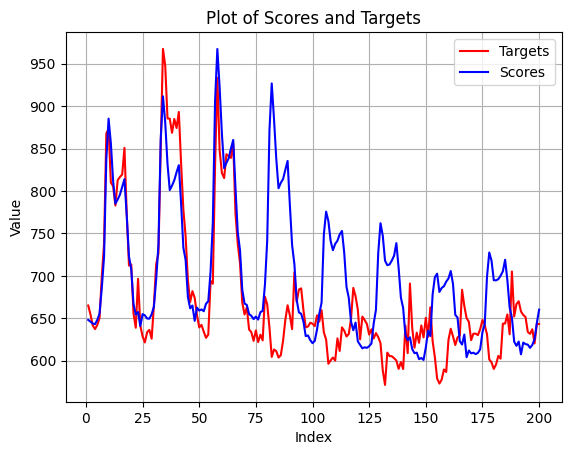

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Example numpy arrays

# Create x values (assuming scores are plotted against index)
x = np.arange(len(all_scores[0:200])) + 1

# Plot both arrays on the same graph with different colors

plt.plot(x, all_targets[0:200], color='red', label='Targets')
plt.plot(x, all_scores[0:200], color='blue', label='Scores')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Scores and Targets')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()